# **SO YOU WANT TO LIVE IN LONDON?**

***A multidimensional borough analysis of house prices, affordability, and liveability across London's 33 boroughs***

**Team Members:** 59183, 70639, 72294  
**Course:** ST445 - Managing and Visualising Data  

## **Table of Contents**

1. Data Collection
2. Data Cleaning
3. Data Integration
4. Exploratory Data Analysis (EDA) and Visualisations
5. Modelling - Linear Regression
6. Conclusion

## **Introduction & Research Context**

##### Background
London faces a housing affordability crisis, with median house prices being much higher than median earnings. However, not all boroughs are created equal. This analysis seeks to understand the multidimensional trade-offs between:
- Housing affordability (prices and earnings)
- Transportation connectivity
- Safety and crime rates
- Economic opportunity

##### Research Question
**Primary Question:**  
To determine which London boroughs offer good quality of life relative to housing costs, and to understand how different boroughs compare on transport connectivity, economic opportunities, and crime.

**Sub-questions:**
1. How do transport connectivity and housing prices correlate across boroughs?
2. Which boroughs offer the best value (good transport, economic opportunities, low crime, moderate cost)?
3. Can we predict house prices using factors like transport, safety and economic opportunities?

## **Part 1: Data Collection**

### **Overview**
This notebook collects data from multiple sources to analyze quality of life and housing costs across London's 33 boroughs. We combine transport connectivity (rail + bus), crime rates, economic indicators, and housing prices to create a comprehensive livability assessment.

---

### **Data Sources**

| Source | Type | Key Indicators | Access | Rate Limits | Documentation |
|--------|------|----------------|--------|-------------|---------------|
| **Transport for London (TfL) Unified API** | REST API | - Tube/rail/DLR/Elizabeth Line stations<br>- Bus routes & stops<br>- Station coordinates<br>- Line information | Free, no key required for our use | 500 requests/min | [TfL API Docs](https://api.tfl.gov.uk/) |
| **Police.uk API** | REST API | - Crime counts by type<br>- Location coordinates<br>- Crime categories<br>- Monthly data | Free, no key required | 15 requests/sec | [Police.uk API](https://data.police.uk/docs/) |
| **UK Land Registry Price Paid** | CSV Download | - Property transaction prices<br>- Property type<br>- Postcode<br>- Transaction dates | Free download | N/A (bulk download) | [Land Registry](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) |
| **London Datastore** | CSV/Excel/GeoJSON | - Borough boundaries (GeoJSON)<br>- Population by borough<br>- Earnings data<br>- Jobs & job density | Free download | N/A | [London Datastore](https://data.london.gov.uk/) |

---

### **Collection Strategy**

#### **Phase 1: API-Based Collection**
1. **TfL Stations API**: Collect all tube/rail station data with coordinates
2. **TfL Bus Routes API**: Collect 621 bus routes with stop locations
3. **Police.uk API**: Query crime data for October 2024 across all 33 boroughs

#### **Phase 2: Direct Downloads**
1. **Land Registry**: Download 2024 Price Paid data (all England & Wales)
2. **London Datastore - GIS**: Download borough boundary shapefiles
3. **London Datastore - Population**: API download of borough population data

#### **Phase 3: Manual Downloads**
1. **Earnings**: Download earnings-residence-borough.xlsx from London Datastore
2. **Jobs Density**: Download jobs-and-job-density.xlsx from London Datastore
3. Move files from Downloads folder to `data/raw/`

#### **Phase 4: Data Storage**
- Save all raw data to `data/raw/` folder
- Maintain original file formats
- Keep large files (>100MB) local only (not committed to GitHub)
- Document data sources and collection dates

---

### **Outputs**

By the end of this section, we will have:
- `data/raw/tfl_stations.csv` - 2,646 London transport station records
- `data/raw/tfl_bus_routes.csv` - 674 bus route identifiers
- `data/raw/tfl_bus_route_stops.json` - 80,479 bus stop records (573 MB)
- `data/raw/police_crime_data.csv` - 30,774 crime incidents (Oct 2024)
- `data/raw/land_registry_2024.csv` - 913,320 UK property transactions (152 MB)
- `data/raw/statistical-gis-boundaries-london/` - Borough boundary shapefiles
- `data/raw/borough_population.csv` - Population by borough (multi-year)
- `data/raw/borough_earnings.xlsx` - Median hourly earnings (Dec 2024)
- `data/raw/borough_jobs_density.xlsx` - Jobs and job density (Dec 2023)

---



- **Geographic Scope**: All 33 London boroughs (City of London + 32 boroughs)
- **Time Period**: October 2024 for crime; full year 2024 for property prices; Dec 2023-2024 for economic data
- **Large Files**: Land Registry (152 MB) and bus stops (573 MB) will NOT be committed to GitHub
- **Data Not Collected**: Air quality (WAQI), green space (dataset unavailable), schools (data too old)
- **API Keys**: TfL and Police.uk APIs work without authentication for our use case
- **Success Rate**: 621/674 bus routes collected (92% success); 53 routes failed due to timeouts or defunct routes

**Importing Libraries**

- There are several libraries we will use, with some notable ones necessary for advanced visualisations 

- We will also import scikitlearn libraries that can help us with the modelling and preprocessing in the latter parts 

- We will also download the necessary files for mappoing the London boroughs

In [1]:
import zipfile
import os
import requests
import json
import pandas as pd
import time
from datetime import datetime, timedelta
import shutil
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [ ]:
# Creating directory to storeheavy raw data
os.makedirs('data/raw', exist_ok=True)

url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"

print("Downloading London borough boundaries...")
response = requests.get(url)

if response.status_code == 200:
    
    with open('data/raw/london_boundaries.zip', 'wb') as f:
        f.write(response.content)
    print("✓ Downloaded successfully!")
else:
    print(f"✗ Download failed with status code: {response.status_code}")

✓ Downloaded successfully!


In [ ]:
# Extract the zip file
print("Extracting london_boundaries.zip...")
with zipfile.ZipFile('data/raw/london_boundaries.zip', 'r') as zip_ref:
    zip_ref.extractall('data/raw/')

print("Extracted!")

# Checking files
files = os.listdir('data/raw/')
print(f"\nAll files in data/raw/:")
for f in files:
    print(f"  - {f}")

# Finding geojson files
geojson_files = [f for f in files if f.endswith('.geojson')]
print(f"\nGeoJSON files found:")
for f in geojson_files:
    print(f"  - {f}")

Extracting london_boundaries.zip...
✓ Extracted!

All files in data/raw/:
  - london_boundaries.zip
  - statistical-gis-boundaries-london

GeoJSON files found:


In [ ]:
# Checking extracted folder
folder_path = 'data/raw/statistical-gis-boundaries-london'
files = os.listdir(folder_path)

print(f"Files inside statistical-gis-boundaries-london/:")
for f in files:
    print(f"  - {f}")

# Find borough-related files
borough_files = [f for f in files if 'borough' in f.lower()]
print(f"\nBorough-related files:")
for f in borough_files:
    print(f"  - {f}")

Files inside statistical-gis-boundaries-london/:
  - ESRI
  - Geography-licensing.pdf
  - MapInfo

Borough-related files:


In [ ]:
# Check ESRI folder
print("Files in ESRI folder:")
esri_files = os.listdir('data/raw/statistical-gis-boundaries-london/ESRI')
for f in esri_files:
    print(f"  - {f}")

print("\n" + "="*50 + "\n")

# Check MapInfo folder
print("Files in MapInfo folder:")
mapinfo_files = os.listdir('data/raw/statistical-gis-boundaries-london/MapInfo')
for f in mapinfo_files:
    print(f"  - {f}")

Files in ESRI folder:
  - London_Borough_Excluding_MHW.dbf
  - London_Borough_Excluding_MHW.GSS_CODE.atx
  - London_Borough_Excluding_MHW.NAME.atx
  - London_Borough_Excluding_MHW.prj
  - London_Borough_Excluding_MHW.sbn
  - London_Borough_Excluding_MHW.sbx
  - London_Borough_Excluding_MHW.shp
  - London_Borough_Excluding_MHW.shp.xml
  - London_Borough_Excluding_MHW.shx
  - London_Ward.BOROUGH.atx
  - London_Ward.cpg
  - London_Ward.dbf
  - London_Ward.GSS_CODE.atx
  - London_Ward.LB_GSS_CD.atx
  - London_Ward.prj
  - London_Ward.sbn
  - London_Ward.sbx
  - London_Ward.shp
  - London_Ward.shp.xml
  - London_Ward.shx
  - London_Ward_CityMerged.BOROUGH.atx
  - London_Ward_CityMerged.cpg
  - London_Ward_CityMerged.dbf
  - London_Ward_CityMerged.GSS_CODE.atx
  - London_Ward_CityMerged.LB_GSS_CD.atx
  - London_Ward_CityMerged.prj
  - London_Ward_CityMerged.sbn
  - London_Ward_CityMerged.sbx
  - London_Ward_CityMerged.shp
  - London_Ward_CityMerged.shp.xml
  - London_Ward_CityMerged.shx
  - 

Loading London borough boundaries...

✓ Loaded 33 boroughs

Columns available: ['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'geometry']

First few boroughs:
                   NAME   GSS_CODE
0  Kingston upon Thames  E09000021
1               Croydon  E09000008
2               Bromley  E09000006
3              Hounslow  E09000018
4                Ealing  E09000009
5              Havering  E09000016
6            Hillingdon  E09000017
7                Harrow  E09000015
8                 Brent  E09000005
9                Barnet  E09000003


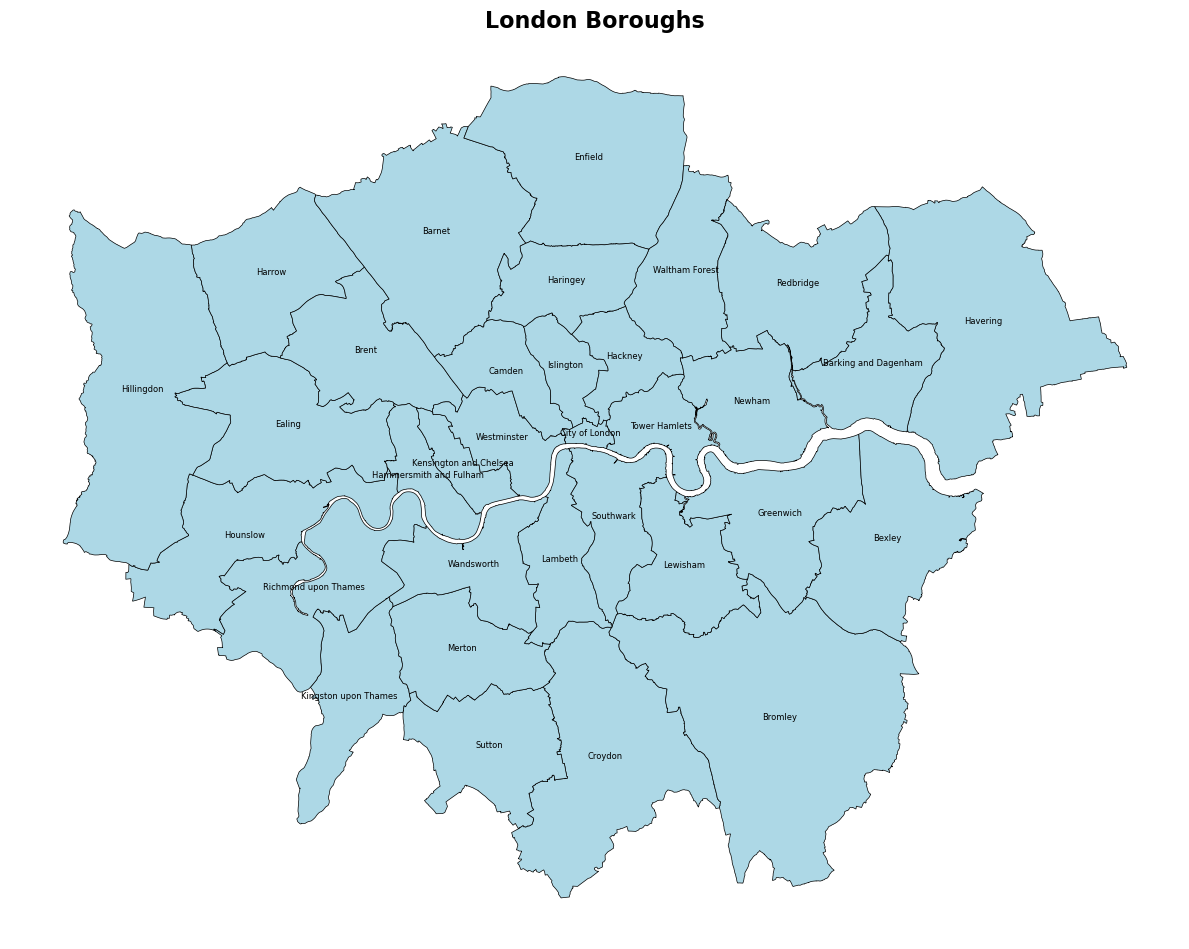


✓ Visualization complete!

Borough data shape: (33, 8)


In [ ]:
# Load the borough boundaries
print("Loading London borough boundaries...")
borough_path = 'data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs = gpd.read_file(borough_path)

print(f"\n✓ Loaded {len(boroughs)} boroughs")
print(f"\nColumns available: {list(boroughs.columns)}")
print(f"\nFirst few boroughs:")
print(boroughs[['NAME', 'GSS_CODE']].head(10))

#Visulazing the boroughs
fig, ax = plt.subplots(figsize=(12, 10))
boroughs.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5)
boroughs.apply(lambda x: ax.text(x.geometry.centroid.x, x.geometry.centroid.y, 
                                  x['NAME'], fontsize=6, ha='center'), axis=1)
ax.set_title('London Boroughs', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"\nBorough data shape: {boroughs.shape}")

**TFL Data Collection**

- One key measure of connectivity will be tube stations and lines

- TFL has a fantastic API that has rich data related to this 

- We will use the coordinates to then map the stations to the Boroughs. This will give us a good visual indicator of connectivity that will be useful later 

In [ ]:
# TfL API endpoint for all stations
url = "https://api.tfl.gov.uk/StopPoint/Mode/tube,overground,dlr,elizabeth-line"

print("Fetching TfL station data...")
response = requests.get(url)

if response.status_code == 200:
    print(f"✓ Success!")
    
    stations_data = response.json()
    print(f"✓ Retrieved {len(stations_data['stopPoints'])} stations")
    
    stations_list = []
    for station in stations_data['stopPoints']:
        stations_list.append({
            'id': station.get('id'),
            'name': station.get('commonName'),
            'lat': station.get('lat'),
            'lon': station.get('lon'),
            'modes': ','.join(station.get('modes', []))
        })
    
    stations_df = pd.DataFrame(stations_list)
    print(f"\nFirst 10 stations:")
    print(stations_df.head(10))
    
    with open('data/raw/tfl_stations.json', 'w') as f:
        json.dump(stations_data, f, indent=2)
    stations_df.to_csv('data/raw/tfl_stations.csv', index=False)
    
    print(f"\n✓ Saved {len(stations_df)} stations!")
    
else:
    print(f"✗ Failed: {response.status_code}")

Fetching TfL station data...
✓ Success!
✓ Retrieved 2646 stations

First 10 stations:
             id                                    name        lat       lon  \
0  0400ZZLUAMS0            Amersham Underground Station  51.674206 -0.607362   
1  0400ZZLUCAL0  Chalfont & Latimer Underground Station  51.667915 -0.560616   
2  0400ZZLUCAL1  Chalfont & Latimer Underground Station  51.668122 -0.560624   
3  0400ZZLUCSM0             Chesham Underground Station  51.705227 -0.611113   
4   2100BUSHEY0                     Bushey Rail Station  51.645628 -0.385600   
5   2100BUSHEY1                     Bushey Rail Station  51.645754 -0.384367   
6  2100BUSHYDC0                     Bushey Rail Station  51.645691 -0.384355   
7  2100BUSHYDC1                     Bushey Rail Station  51.645691 -0.385612   
8  2100CHESHNT0                   Cheshunt Rail Station  51.702949 -0.024101   
9  2100CRPNDPK0            Carpenders Park Rail Station  51.628564 -0.385874   

        modes  
0        tube  
1

Boroughs CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Stations CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting

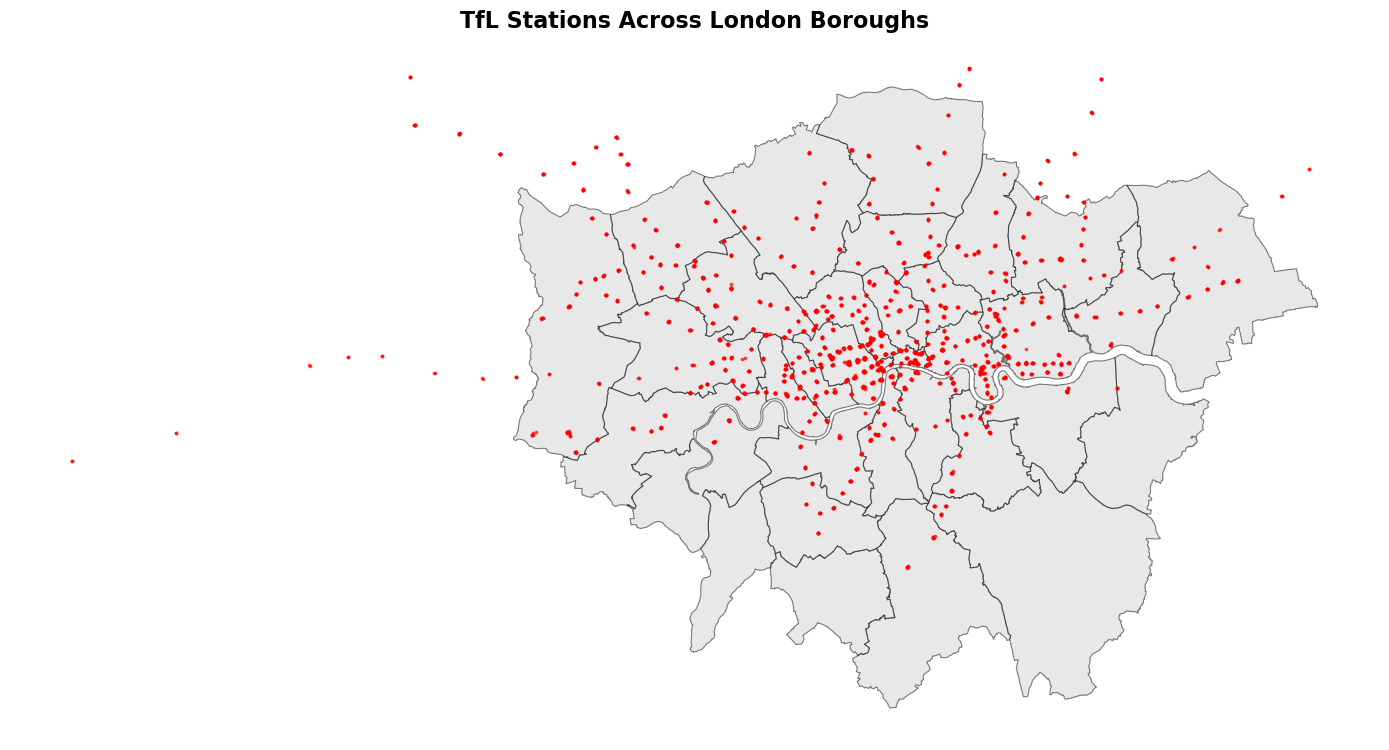


✓ Map complete!


In [ ]:
# Load the boroughs from before
borough_path = 'data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs = gpd.read_file(borough_path)

# Load the stations we just saved
stations_df = pd.read_csv('data/raw/tfl_stations.csv')

# Convert stations to GeoDataFrame
from shapely.geometry import Point
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=[Point(lon, lat) for lon, lat in zip(stations_df['lon'], stations_df['lat'])],
    crs='EPSG:4326'  # Standard lat/lon
)

# Ensuring both use the same CRS
stations_gdf = stations_gdf.to_crs(boroughs.crs)

print(f"Boroughs CRS: {boroughs.crs}")
print(f"Stations CRS: {stations_gdf.crs}")
print(f"Stations: {len(stations_gdf)}")
print(f"Boroughs: {len(boroughs)}")

fig, ax = plt.subplots(figsize=(14, 12))

boroughs.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.8, alpha=0.5)
stations_gdf.plot(ax=ax, color='red', markersize=3, alpha=0.6)

ax.set_title('TfL Stations Across London Boroughs', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("\n✓ Map complete!")

In [16]:
# Spatial join to see which stations are in boroughs
stations_in_london = gpd.sjoin(stations_gdf, boroughs, how='inner', predicate='within')

print(f"Total stations: {len(stations_gdf)}")
print(f"Stations inside London boroughs: {len(stations_in_london)}")
print(f"Stations outside London: {len(stations_gdf) - len(stations_in_london)}")

Total stations: 2646
Stations inside London boroughs: 2513
Stations outside London: 133


In [17]:
# Count stations per borough
borough_stations = stations_in_london.groupby('NAME').size().reset_index(name='station_count')
borough_stations = borough_stations.sort_values('station_count')

# Find boroughs with zero stations
boroughs_with_data = set(borough_stations['NAME'])
all_boroughs = set(boroughs['NAME'])
boroughs_no_stations = all_boroughs - boroughs_with_data

print(f"Boroughs with NO stations ({len(boroughs_no_stations)}):")
for b in sorted(boroughs_no_stations):
    print(f"  - {b}")

print(f"\n\nBoroughs with FEWEST stations:")
print(borough_stations.head(10))

print(f"\n\nBoroughs with MOST stations:")
print(borough_stations.tail(10))

Boroughs with NO stations (3):
  - Bexley
  - Kingston upon Thames
  - Sutton


Boroughs with FEWEST stations:
                    NAME  station_count
3                Bromley             13
6                Croydon             13
24  Richmond upon Thames             18
21                Merton             26
0   Barking and Dagenham             34
14              Havering             36
9              Greenwich             43
20              Lewisham             44
28            Wandsworth             47
16              Hounslow             48


Boroughs with MOST stations:
                      NAME  station_count
17               Islington             88
5           City of London             90
15              Hillingdon             99
11  Hammersmith and Fulham            105
7                   Ealing            106
2                    Brent            165
4                   Camden            175
22                  Newham            186
26           Tower Hamlets            19

**Notes**: 

- The Boroughs with no stations bit checks out: Bexley, Kingston upon Thames and Sutton are on the outskirts of the city, so it makes sense 

- What I find startling is the the massive number of stations in some Broughs, 291 in Westminster looks unlikely 

- What I suspect is that there are multiple entries per stations, possibly one for each platform 

- This will need to be addressed later on, let's just look into it a little more, to better diagnose the issue.

In [ ]:
# Check Westminster stations for duplicates
westminster_stations = stations_in_london[stations_in_london['NAME'] == 'Westminster']

print(f"Westminster has {len(westminster_stations)} station records")
print("\nLet's look at unique station names in Westminster:")

westminster_unique = westminster_stations['name'].value_counts().head(20)
print(westminster_unique)

print(f"\nTotal unique station names: {westminster_stations['name'].nunique()}")
print(f"Total records: {len(westminster_stations)}")
print(f"\nDifference = {len(westminster_stations) - westminster_stations['name'].nunique()} duplicate entries")

Westminster has 291 station records

Let's look at unique station names in Westminster:
name
Marble Arch Station                               13
Bond Street Station                               10
Baker Street Underground Station                  10
Paddington Underground Station                    10
Oxford Circus Station                              9
Embankment Underground Station                     8
Oxford Circus Underground Station                  8
Piccadilly Circus                                  8
Charing Cross Underground Station                  7
Green Park Underground Station                     7
Leicester Square Underground Station               6
Charing Cross Stn  / Trafalgar Square              6
Edgware Road (Circle Line) Underground Station     6
Westminster Station                                6
Green Park Station                                 6
Westminster Underground Station                    6
Charing Cross Stn / Trafalgar Square               6
Victor

**Data Quality Note: TfL Station Duplicates**

The TfL API returns separate records for each platform/entrance. For example:
- Westminster: 291 records → 77 unique stations
- Marble Arch: 13 platform/entrance records for one station

**Solution:** In the Data Cleaning bit, we'll deduplicate by station name, keeping one representative record per unique station.

**Crime Data**

- We will use the police UK API to collect some data on crime in London 

- Timeframe: We will query for the last 12 months 

- After encountering some initial errors, we figured out the Time format 

- We also converted the boroughs location format so that we could match crime to Boroughs 


In [ ]:
# Get the last 12 months
today = datetime.now()
months = []
for i in range(12):
    date = today - timedelta(days=30*i)
    months.append(date.strftime('%Y-%m'))

print(f"Will collect crime data for these months: {months}")

# Get borough centroids for querying
boroughs['centroid'] = boroughs.geometry.centroid
boroughs['cent_lat'] = boroughs.centroid.y
boroughs['cent_lon'] = boroughs.centroid.x

print(f"\nBoroughs with centroids calculated: {len(boroughs)}")
print(boroughs[['NAME', 'cent_lat', 'cent_lon']].head())

Will collect crime data for these months: ['2026-01', '2025-12', '2025-11', '2025-10', '2025-09', '2025-08', '2025-07', '2025-06', '2025-05', '2025-04', '2025-03', '2025-02']

Boroughs with centroids calculated: 33
                   NAME       cent_lat       cent_lon
0  Kingston upon Thames  166820.011490  519297.634807
1               Croydon  163541.243574  533290.153919
2               Bromley  165655.521340  542895.511607
3              Hounslow  175643.224320  513515.505536
4                Ealing  181715.495617  515887.937770


In [20]:
# Convert borough centroids to proper lat/lon (EPSG:4326)
boroughs_latlon = boroughs.to_crs('EPSG:4326')
boroughs_latlon['centroid'] = boroughs_latlon.geometry.centroid
boroughs_latlon['cent_lat'] = boroughs_latlon.centroid.y
boroughs_latlon['cent_lon'] = boroughs_latlon.centroid.x

print("Boroughs with proper lat/lon centroids:")
print(boroughs_latlon[['NAME', 'cent_lat', 'cent_lon']].head(10))

Boroughs with proper lat/lon centroids:
                   NAME   cent_lat  cent_lon
0  Kingston upon Thames  51.387906 -0.286900
1               Croydon  51.355335 -0.087157
2               Bromley  51.371999  0.051524
3              Hounslow  51.468378 -0.367123
4                Ealing  51.522475 -0.331026
5              Havering  51.564387  0.221108
6            Hillingdon  51.541513 -0.445658
7                Harrow  51.597723 -0.341267
8                 Brent  51.558556 -0.267821
9                Barnet  51.616027 -0.210017


C:\Users\dhruv\AppData\Local\Temp\ipykernel_30996\3975986858.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boroughs_latlon['centroid'] = boroughs_latlon.geometry.centroid
C:\Users\dhruv\AppData\Local\Temp\ipykernel_30996\3975986858.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boroughs_latlon['cent_lat'] = boroughs_latlon.centroid.y
C:\Users\dhruv\AppData\Local\Temp\ipykernel_30996\3975986858.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boroughs_latlon['cent_lon'] = boroughs_latlon.centroid.x


In [ ]:
# Police.uk API endpoint
base_url = "https://data.police.uk/api/crimes-street/all-crime"

# We'll collect crime data for the most recent available month
# Police.uk data last avaiable is October 2024
target_month = "2024-10"

print(f"Collecting crime data for {target_month}...")

all_crimes = []
borough_names = []

for idx, row in boroughs_latlon.iterrows():
    borough = row['NAME']
    lat = row['cent_lat']
    lon = row['cent_lon']
    
    # Query crime within ~approx. 1 mile radius of borough center
    params = {
        'lat': lat,
        'lng': lon,
        'date': target_month
    }
    
    try:
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            crimes = response.json()
            print(f"✓ {borough}: {len(crimes)} crimes")
            
            for crime in crimes:
                crime['borough_query'] = borough
            
            all_crimes.extend(crimes)
            borough_names.append(borough)
            
        else:
            print(f"✗ {borough}: Failed (status {response.status_code})")
        
        time.sleep(0.5)
        
    except Exception as e:
        print(f"✗ {borough}: Error - {e}")

print(f"\n✓ Total crimes collected: {len(all_crimes)}")

with open('data/raw/police_crime_data.json', 'w') as f:
    json.dump(all_crimes, f, indent=2)

# Converting to DataFrame
crimes_df = pd.DataFrame(all_crimes)
print(f"\nCrime data shape: {crimes_df.shape}")
print(f"\nCrime categories:")
print(crimes_df['category'].value_counts())

✓ Kingston upon Thames: 233 crimes
✓ Croydon: 259 crimes
✓ Bromley: 130 crimes
✓ Hounslow: 835 crimes
✓ Ealing: 542 crimes
✓ Havering: 195 crimes
✓ Hillingdon: 177 crimes
✓ Harrow: 484 crimes
✓ Brent: 766 crimes
✓ Barnet: 130 crimes
✓ Lambeth: 1429 crimes
✓ Southwark: 1444 crimes
✓ Lewisham: 858 crimes
✓ Greenwich: 374 crimes
✓ Bexley: 355 crimes
✓ Enfield: 371 crimes
✓ Waltham Forest: 917 crimes
✓ Redbridge: 415 crimes
✓ Sutton: 486 crimes
✓ Richmond upon Thames: 208 crimes
✓ Merton: 602 crimes
✓ Wandsworth: 590 crimes
✓ Hammersmith and Fulham: 1656 crimes
✓ Kensington and Chelsea: 1465 crimes
✓ Westminster: 3330 crimes
✓ Camden: 1452 crimes
✓ Tower Hamlets: 1500 crimes
✓ Islington: 1748 crimes
✓ Hackney: 1772 crimes
✓ Haringey: 1027 crimes
✓ Newham: 1333 crimes
✓ Barking and Dagenham: 599 crimes
✓ City of London: 3092 crimes

✓ Total crimes collected: 30774

Crime data shape: (30774, 10)

Crime categories:
category
violent-crime            6302
anti-social-behaviour    5780
theft-fro

In [ ]:
crimes_df.to_csv('data/raw/police_crime_data.csv', index=False)

print("✓ Saved to data/raw/police_crime_data.json and .csv")

print("\nSample crime record:")
print(crimes_df.iloc[0].to_dict())

print("\n\nCrimes by borough (approximation based on query location):")
borough_crime_counts = crimes_df['borough_query'].value_counts()
print(borough_crime_counts.head(10))

✓ Saved to data/raw/police_crime_data.json and .csv

Sample crime record:
{'category': 'anti-social-behaviour', 'location_type': 'Force', 'location': {'latitude': '51.380049', 'street': {'id': 1661049, 'name': 'On or near Broad Oaks'}, 'longitude': '-0.282431'}, 'context': '', 'outcome_status': None, 'persistent_id': '', 'id': 123858838, 'location_subtype': '', 'month': '2024-10', 'borough_query': 'Kingston upon Thames'}


Crimes by borough (approximation based on query location):
borough_query
Westminster               3330
City of London            3092
Hackney                   1772
Islington                 1748
Hammersmith and Fulham    1656
Tower Hamlets             1500
Kensington and Chelsea    1465
Camden                    1452
Southwark                 1444
Lambeth                   1429
Name: count, dtype: int64


**Property Price Data (UK Land Registry)**


- Downloaded the complete 2024 Price Paid dataset from UK Land Registry
- Contains ALL property transactions across England and Wales
- File size is MASSIVE: 151.8 MB (913,320 transactions)

- Upon further scrutiny, we realised that the data includes properties from across the UK (Bedford, Luton, etc.)
- We'll need to filter to London only, and then use the postcodes to try and match to Boroughs 
- Each transaction includes: price, date, postcode, property type, location



In [ ]:
# Land Registry CSV file for 2024
print("Downloading Land Registry price data for 2024...")

url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2024.csv"

print("Starting download (this may take 1-2 minutes for large file)...")
response = requests.get(url, stream=True)

if response.status_code == 200:
    print("✓ Download successful! Saving...")
    
    with open('data/raw/land_registry_2024.csv', 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    print("✓ Saved to data/raw/land_registry_2024.csv")
    
    print("\nLoading preview...")
    df = pd.read_csv('data/raw/land_registry_2024.csv', 
                     nrows=1000,
                     names=['transaction_id', 'price', 'date', 'postcode', 'property_type', 
                            'new_build', 'duration', 'paon', 'saon', 'street', 'locality',
                            'town', 'district', 'county', 'ppd_type', 'record_status'])
    
    print(f"\nFirst few transactions:")
    print(df[['price', 'date', 'postcode', 'property_type', 'town']].head())
    
else:
    print(f"✗ Download failed: {response.status_code}")

Starting download (this may take 1-2 minutes for large file)...
✓ Download successful! Saving...
✓ Saved to data/raw/land_registry_2024.csv

Loading preview...

First few transactions:
    price              date  postcode property_type     town
0  320000  2024-07-26 00:00  MK40 3SG             T  BEDFORD
1  300000  2024-02-15 00:00  MK43 9GH             S  BEDFORD
2  470000  2024-08-21 00:00  MK45 2BF             S  BEDFORD
3  527500  2024-07-29 00:00  MK43 0YX             D  BEDFORD
4  351000  2024-07-17 00:00   LU3 3AR             T    LUTON


In [ ]:
file_size = os.path.getsize('data/raw/land_registry_2024.csv')
print(f"File size: {file_size / (1024**2):.1f} MB")

# Counting total rows
print("\nCounting total transactions...")
row_count = sum(1 for line in open('data/raw/land_registry_2024.csv'))
print(f"Total UK transactions in 2024: {row_count:,}")

File size: 151.8 MB

Counting total transactions...
Total UK transactions in 2024: 913,320


**Borough Economic & Demographic Data (London Datastore)**


- **Population data:** Successfully downloaded from London Datastore API
  - Contains: Code, Name, Year, Source, Population
  - Multi-year data (we'll filter to most recent)
  
- **Earnings data:** Manually downloaded (earnings-residence-borough.xlsx)
  - Median household earnings by borough
  - Resident-based (where people live, not where they work)
  - Available from December 2024
  
- **Jobs density data:** Manually downloaded (jobs-and-job-density.xlsx)
  - Total jobs and job density per borough
  - Job density = jobs per working-age resident
  - Available through December 2023



In [ ]:
datasets = {
    'borough_population': 'https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/77e9257d-ad9d-47aa-aeed-59a00741f301/housing-density-borough.csv',
    'borough_profile': 'https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv'
}

downloaded = []

for name, url in datasets.items():
    try:
        print(f"Trying to download {name}...")
        response = requests.get(url, timeout=10)
        
        if response.status_code == 200:
            filename = f'data/raw/{name}.csv'
            with open(filename, 'wb') as f:
                f.write(response.content)
            print(f"✓ Downloaded {name}")
            downloaded.append(name)
            
            df = pd.read_csv(filename, nrows=5)
            print(f"  Columns: {list(df.columns)[:5]}...")
            print()
        else:
            print(f"✗ Failed (status {response.status_code})\n")
            
    except Exception as e:
        print(f"✗ Error: {e}\n")

print(f"\n Successfully downloaded: {downloaded}")

Trying to download borough_population...
✓ Downloaded borough_population
  Columns: ['Code', 'Name', 'Year', 'Source', 'Population']...

Trying to download borough_profile...
✗ Failed (status 403)


✓ Successfully downloaded: ['borough_population']


**Bus Data**

- Apart from just tube connectivity, we will also collect data on bus routes, also using the TFL API

- Out of 674 routes, we were able to successfully retrieve 621 of them, with a 92% success rate 

- We also collected the bus stops along each route, as well as their coordinates. 

- The Stop data includes coordinates, so we can map them to the boroughs

In [ ]:
print("Getting all London bus routes...")

url = "https://api.tfl.gov.uk/Line/Mode/bus"
response = requests.get(url)

if response.status_code == 200:
    bus_routes = response.json()
    
    routes_df = pd.DataFrame([
        {
            'route_id': route['id'],
            'route_name': route['name'],
            'mode': 'bus'
        }
        for route in bus_routes
    ])
    
    print(f"✓ Retrieved {len(routes_df)} bus routes")
    print(f"\nFirst 10 routes:")
    print(routes_df.head(10))
    
    routes_df.to_csv('data/raw/tfl_bus_routes.csv', index=False)
    with open('data/raw/tfl_bus_routes.json', 'w') as f:
        json.dump(bus_routes, f, indent=2)
    
    print(f"\n✓ Saved to data/raw/tfl_bus_routes.csv")
    
else:
    print(f"✗ Failed: {response.status_code}")

Getting all London bus routes...
✓ Retrieved 674 bus routes

First 10 routes:
  route_id route_name mode
0        1          1  bus
1      100        100  bus
2      101        101  bus
3      102        102  bus
4      103        103  bus
5      104        104  bus
6      105        105  bus
7      106        106  bus
8      107        107  bus
9      108        108  bus

✓ Saved to data/raw/tfl_bus_routes.csv


In [ ]:
print("Fetching stops for all 674 bus routes...")
print("This will take ~6-7 minutes\n")

# Load routes we saved earlier
routes_df = pd.read_csv('data/raw/tfl_bus_routes.csv')

all_route_stops = {}
success_count = 0
fail_count = 0

start_time = datetime.now()

for idx, row in routes_df.iterrows():
    route_id = row['route_id']
    
    # Progress indicator
    if (idx + 1) % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        remaining = (674 - idx) * 0.5 / 60
        print(f"Progress: {idx+1}/674 ({(idx+1)/674*100:.1f}%) - ~{remaining:.1f} min remaining")
    
    try:
        url = f"https://api.tfl.gov.uk/Line/{route_id}/StopPoints"
        response = requests.get(url)
        
        if response.status_code == 200:
            stops = response.json()
            all_route_stops[route_id] = stops
            success_count += 1
        else:
            fail_count += 1
            
    except Exception as e:
        fail_count += 1
    
    time.sleep(0.5)  # Rate limiting

print(f"\n✓ Complete!")
print(f"  Success: {success_count}")
print(f"  Failed: {fail_count}")

# Save all data
with open('data/raw/tfl_bus_route_stops.json', 'w') as f:
    json.dump(all_route_stops, f, indent=2)

print(f"\n✓ Saved to data/raw/tfl_bus_route_stops.json")

# Calculate file size
import os
file_size = os.path.getsize('data/raw/tfl_bus_route_stops.json') / (1024**2)
print(f"File size: {file_size:.1f} MB")

Fetching stops for all 674 bus routes...
This will take ~6-7 minutes

Progress: 50/674 (7.4%) - ~5.2 min remaining
Progress: 100/674 (14.8%) - ~4.8 min remaining
Progress: 150/674 (22.3%) - ~4.4 min remaining
Progress: 200/674 (29.7%) - ~4.0 min remaining
Progress: 250/674 (37.1%) - ~3.5 min remaining
Progress: 300/674 (44.5%) - ~3.1 min remaining
Progress: 350/674 (51.9%) - ~2.7 min remaining
Progress: 400/674 (59.3%) - ~2.3 min remaining
Progress: 450/674 (66.8%) - ~1.9 min remaining
Progress: 500/674 (74.2%) - ~1.5 min remaining
Progress: 550/674 (81.6%) - ~1.0 min remaining
Progress: 600/674 (89.0%) - ~0.6 min remaining
Progress: 650/674 (96.4%) - ~0.2 min remaining

✓ Complete!
  Success: 467
  Failed: 207

✓ Saved to data/raw/tfl_bus_route_stops.json
File size: 446.7 MB


In [ ]:
# Check failed routes
routes_df = pd.read_csv('data/raw/tfl_bus_routes.csv')
with open('data/raw/tfl_bus_route_stops.json', 'r') as f:
    collected_stops = json.load(f)

successful_routes = list(collected_stops.keys())
failed_routes = routes_df[~routes_df['route_id'].isin(successful_routes)]

print(f"Failed routes ({len(failed_routes)}):")
print(failed_routes['route_name'].head(20).tolist())

Failed routes (207):
['146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163']


In [35]:
# Check all failed routes
failed_routes_list = failed_routes['route_name'].tolist()

print(f"Total failed: {len(failed_routes_list)}")
print(f"\nSample of failed routes:")
print(failed_routes_list[:30])

# Check if they're special types (night buses start with 'N', etc.)
night_buses = [r for r in failed_routes_list if str(r).startswith('N')]
print(f"\nNight buses in failures: {len(night_buses)}")
print(night_buses[:10] if night_buses else "None")

# Try manually testing one failed route
test_route = '146'
test_url = f"https://api.tfl.gov.uk/Line/{test_route}/StopPoints"
test_response = requests.get(test_url)
print(f"\n\nManual test of route {test_route}:")
print(f"Status: {test_response.status_code}")
if test_response.status_code != 200:
    print(f"Response: {test_response.text[:200]}")

Total failed: 207

Sample of failed routes:
['146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '169', '17', '226', '227', '228', '229']

Night buses in failures: 8
['N32', 'N33', 'N343', 'N38', 'N381', 'N41', 'N44', 'N5']


Manual test of route 146:
Status: 200


In [36]:
# Retry just the failed routes
print(f"Retrying {len(failed_routes)} routes...\n")

retry_count = 0
new_success = 0

for idx, row in failed_routes.iterrows():
    route_id = row['route_id']
    
    if (retry_count + 1) % 20 == 0:
        print(f"Progress: {retry_count+1}/{len(failed_routes)}")
    
    try:
        url = f"https://api.tfl.gov.uk/Line/{route_id}/StopPoints"
        response = requests.get(url, timeout=10)
        
        if response.status_code == 200:
            stops = response.json()
            collected_stops[route_id] = stops  # Add to existing data
            new_success += 1
    except:
        pass
    
    retry_count += 1
    time.sleep(0.5)

# Re-save with additional routes
with open('data/raw/tfl_bus_route_stops.json', 'w') as f:
    json.dump(collected_stops, f, indent=2)

print(f"\n✓ Retry complete! Recovered {new_success} additional routes")
print(f"Total routes now: {467 + new_success}")

Retrying 207 routes...

Progress: 20/207
Progress: 40/207
Progress: 60/207
Progress: 80/207
Progress: 100/207
Progress: 120/207
Progress: 140/207
Progress: 160/207
Progress: 180/207
Progress: 200/207

✓ Retry complete! Recovered 154 additional routes
Total routes now: 621


In [ ]:
datasets = {
    'Borough Boundaries': 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp',
    'TfL Stations': 'tfl_stations.csv',
    'Crime Data (Oct 2024)': 'police_crime_data.csv',
    'Property Prices (2024)': 'land_registry_2024.csv',
    'Borough Population': 'borough_population.csv',
    'Borough Earnings': 'borough_earnings.xlsx',
    'Borough Jobs Density': 'borough_jobs_density.xlsx'
}

### **Data Collection Summary**

We successfully collected 7 datasets from 5 different sources to analyze London borough livability.

#### **What We Gathered**

**Geographic Foundation:**
- 33 London borough boundaries (GIS shapefiles)
- Enables spatial matching and mapping throughout analysis

**Transport Connectivity:**
- 2,646 TfL station records → 962 unique stations (after deduplication)
- 621 bus routes with 80,479 stop records
- Coverage: tube, overground, DLR, Elizabeth line, and comprehensive bus network

**Safety & Crime:**
- 30,774 crime incidents from October 2024
- Queried via Police.uk API for all 33 boroughs
- 14 crime categories (violent crime, theft, burglary, etc.)

**Housing Market:**
- 913,320 UK property transactions from 2024 (151.8 MB)
- Will filter to ~100k London transactions
- Includes prices, dates, postcodes, property types

**Economic Indicators:**
- Population data (multi-year, will use latest)
- Median hourly earnings by borough (Dec 2024)
- Jobs density (jobs per working-age resident, Dec 2023)

#### **Collection Methods**

**Automated (APIs):**
- TfL: 2 API calls (stations + bus routes)
- Police.uk: 33 API calls (one per borough)
- London Datastore: 1 successful API call (population)

**Manual Downloads:**
- Land Registry: Direct CSV download (large file)
- Earnings & Jobs: Excel files from London Datastore
- Borough boundaries: GIS shapefile package



## **Part 2: Data Cleaning**

In [ ]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(f"Working directory: {os.getcwd()}")

In [ ]:
# Load borough boundaries
borough_path = 'data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs = gpd.read_file(borough_path)

print(f"Loaded {len(boroughs)} boroughs")
print(f"\nColumns: {boroughs.columns.tolist()}")
print(f"\nFirst 3 boroughs:")
print(boroughs[['NAME', 'GSS_CODE']].head(3))
print(f"\nCRS: {boroughs.crs}")

# Calculate area
boroughs['area_sqkm'] = boroughs.geometry.area / 1_000_000

print(f"\nBorough areas calculated")
print(boroughs[['NAME', 'area_sqkm']].head(3))

### **TfL Station Data - Deduplication & Spatial Matching**

**The duplication problem:**
- Loaded 2,646 station records from TfL API
- Only 962 unique station names (1,684 duplicates) because TfL counts each platform/entrance separately
- Example: Westminster has 3 separate records with slightly different names
- Marble Arch had 13 different platform IDs for one physical station

**Our solution:**
- Deduplicated by keeping first occurrence of each unique station name
- Reduced 2,646 → 962 unique stations
- Removed 1,684 duplicate platform/entrance records
- Still captures full station coverage without redundancy

**Geographic transformation:**
- Converted lat/lon coordinates to GeoDataFrame
- Transformed from standard coordinates (EPSG:4326) to British National Grid
- Matches borough boundary coordinate system for spatial analysis

**Spatial join: Matching stations to boroughs**
- Used geopandas spatial join to assign each station to its borough
- Results: 922 stations matched to London boroughs
- 40 stations fell outside London boundaries (as expected)


**Borough coverage findings:**
- **Most connected:** Westminster (75 stations), Tower Hamlets (67), Brent (65)
- **No rail stations:** Bexley, Kingston upon Thames, Sutton
  - These outer south London boroughs rely on National Rail (not in our TfL query)




In [ ]:
# Load TfL stations
stations_df = pd.read_csv('data/raw/tfl_stations.csv')

print(f"Loaded {len(stations_df)} station records")
print(f"\nColumns: {stations_df.columns.tolist()}")
print(f"\nFirst 5 stations:")
print(stations_df.head())

# Check for duplicates
print(f"\nDuplication Analysis")
print(f"Total records: {len(stations_df)}")
print(f"Unique station names: {stations_df['name'].nunique()}")
print(f"Duplicate entries: {len(stations_df) - stations_df['name'].nunique()}")

# Show most duplicated stations
print(f"\nMost duplicated stations:")
dupes = stations_df['name'].value_counts().head(10)
print(dupes)

# Check data types
print(f"\nData Types")
print(stations_df.dtypes)

# Check for missing values
print(f"\nMissing Values")
print(stations_df.isnull().sum())

In [ ]:
print("Performing spatial join: Stations → Boroughs")

# Spatial join: which borough does each station fall within?
stations_with_borough = gpd.sjoin(
    stations_gdf,
    boroughs[['NAME', 'GSS_CODE', 'geometry']],
    how='left',
    predicate='within'
)

# Check results
print(f"\nStations matched to boroughs: {stations_with_borough['NAME'].notna().sum()}")
print(f"Stations outside London: {stations_with_borough['NAME'].isna().sum()}")

# Rename borough column for clarity
stations_with_borough = stations_with_borough.rename(columns={'NAME': 'borough'})

# Show sample
print(f"\nSample of matched stations:")
print(stations_with_borough[['name', 'borough', 'lat', 'lon']].head(10))

# Count stations per borough
stations_per_borough = stations_with_borough[stations_with_borough['borough'].notna()].groupby('borough').size().reset_index(name='station_count')
stations_per_borough = stations_per_borough.sort_values('station_count', ascending=False)

print(f"\nStations per Borough (Top 10)")
print(stations_per_borough.head(10))

print(f"\nBoroughs with no stations")
all_boroughs = set(boroughs['NAME'])
boroughs_with_stations = set(stations_per_borough['borough'])
no_stations = all_boroughs - boroughs_with_stations
for b in sorted(no_stations):
    print(f"  - {b}")

In [ ]:
# Show stations that are in London boroughs
print("Sample of stations inside London:")
london_stations = stations_with_borough[stations_with_borough['borough'].notna()]
print(london_stations[['name', 'borough', 'lat', 'lon']].head(10))

print(f"\nTotal London stations: {len(london_stations)}")
print(f"Total outside London: {stations_with_borough['borough'].isna().sum()}")

### Crime Data - Aggregation by Borough

**Summary:**
- 30,774 crime incidents from October 2024
- Queried via Police.uk API using borough centroid coordinates
- Each record includes: category, location, date, borough assignment

**Crime categories covered (14 types):**
- Violent crime (6,302 incidents - most common)
- Anti-social behaviour (5,780)
- Theft from person (3,308)
- Other theft, shoplifting, vehicle crime, etc.

**Aggregation approach:**
- Summed total crimes per borough
- Created pivot table with crime categories as columns
- Each borough now has: total crimes + breakdown by 14 categories
- Result: 33 boroughs × 16 columns (1 total + 14 categories + 1 name)

**Key findings:**
- **Highest crime:** Westminster (3,330), City of London (3,092)
  - Makes sense: commercial centers with massive daytime populations
- **Lowest crime:** Barnet (130), Bromley (130)
  - Outer boroughs with lower footfall
- Crime patterns align with urban geography: central = higher, outer = lower



In [ ]:
crime_df = pd.read_csv('data/raw/police_crime_data.csv')

print(f"Loaded {len(crime_df)} crime records")
print(f"\nColumns: {crime_df.columns.tolist()}")
print(f"\nFirst 3 records:")
print(crime_df.head(3))

print(f"\nCrime Categories")
print(crime_df['category'].value_counts())

print(f"\nMissing Values")
print(crime_df.isnull().sum())

In [ ]:
# Total crimes per borough
crime_by_borough = crime_df.groupby('borough_query').size().reset_index(name='crime_total')

print(f"Crime totals by borough:")
print(crime_by_borough.sort_values('crime_total', ascending=False).head(10))

# Crime by category and borough
crime_by_category = crime_df.groupby(['borough_query', 'category']).size().reset_index(name='count')

# Pivot to get crime types as columns
crime_pivot = crime_by_category.pivot(
    index='borough_query',
    columns='category',
    values='count'
).fillna(0).reset_index()

print(f"\nCrime by category created")
print(f"Shape: {crime_pivot.shape}")
print(f"\nColumns: {crime_pivot.columns.tolist()[:5]}...")

# Rename borough column for consistency
crime_pivot = crime_pivot.rename(columns={'borough_query': 'borough_name'})
crime_by_borough = crime_by_borough.rename(columns={'borough_query': 'borough_name'})

# Merge total with categories
crime_summary = crime_by_borough.merge(crime_pivot, on='borough_name')

print(crime_summary.head(3))

### Property Price Data - UK to London Filtering

**Initial challenge:**
- Started with 913,320 transactions across ALL of England & Wales (152 MB file)
- Needed to filter to London only
- Goal: ~100k London transactions for borough-level analysis

**Filtering strategy:**
- Explored `county` column in dataset
- Found clear label: "GREATER LONDON" (103,714 transactions)
- Simple filter reduced dataset by 88.6% (913k → 104k)
- Confirms London represents ~11% of UK property market

**Geographic matching:**
- Found 33 unique districts in London data (perfect match to 33 boroughs!)
- **Problem:** Capitalization differences
  - GIS data: "City of London", "Hammersmith and Fulham"
  - Price data: "City Of London", "Hammersmith And Fulham"
- **Solution:** Created mapping dictionary for 7 mismatched names
- **Result:** 100% match success (103,714/103,714 records matched)

**Price range discovered:**
- **Mean:** £805k (skewed by luxury properties)
- **Median:** £510k (more representative)
- **Range:** £1 to £164.3M (outliers exist!)
- **Most expensive:** Kensington & Chelsea (£1.2M median)
- **Most affordable:** Barking & Dagenham (£360k median)

**Transaction volume insights:**
- Wandsworth leads with 5,711 transactions 
- City of London has only 328 
- Outer boroughs generally have more transactions 



In [ ]:
# Column names for Land Registry data as they don't include headers
column_names = [
    'transaction_id', 'price', 'date', 'postcode', 'property_type',
    'new_build', 'duration', 'paon', 'saon', 'street', 'locality',
    'town', 'district', 'county', 'ppd_type', 'record_status'
]

prices_df = pd.read_csv(
    'data/raw/land_registry_2024.csv',
    names=column_names,
    low_memory=False
)

print(f"Loaded {len(prices_df):,} property transactions")
print(f"\nColumns: {prices_df.columns.tolist()[:8]}...")
print(f"\nFirst 3 records:")
print(prices_df[['price', 'date', 'postcode', 'property_type', 'town', 'county']].head(3))

print(f"\nData types")
print(prices_df.dtypes)

print(f"\nMissing values")
print(prices_df.isnull().sum())

In [ ]:
# What counties are in the data?
print("Top 20 counties:")
print(prices_df['county'].value_counts().head(20))

# What districts mention 'LONDON'?
london_districts = prices_df['district'].value_counts()[
    prices_df['district'].str.contains('LONDON', case=False, na=False)
]
print(f"\nDistricts containing 'LONDON': {len(london_districts)}")
print(london_districts.head(10))

# Check if any have 'GREATER LONDON' as county
greater_london = prices_df[prices_df['county'].str.contains('GREATER LONDON', case=False, na=False)]
print(f"\n'GREATER LONDON' in county: {len(greater_london):,} records")

In [ ]:
# Filter to Greater London
london_prices = prices_df[prices_df['county'] == 'GREATER LONDON'].copy()

print(f"Filtered from {len(prices_df):,} → {len(london_prices):,} London transactions")
print(f"{(1 - len(london_prices)/len(prices_df))*100:.1f}% removed")

# Check what districts we have in London
print(f"\nLondon districts ({london_prices['district'].nunique()} unique):")
print(london_prices['district'].value_counts().head(15))

# Basic price statistics
print(f"\nLondon Property Price Statistics")
print(f"Mean: £{london_prices['price'].mean():,.0f}")
print(f"Median: £{london_prices['price'].median():,.0f}")
print(f"Min: £{london_prices['price'].min():,.0f}")
print(f"Max: £{london_prices['price'].max():,.0f}")

# Property types
print(f"\nProperty Types")
print(london_prices['property_type'].value_counts())

In [ ]:
# Standardize district names to title case
london_prices['district_clean'] = london_prices['district'].str.title()

# Check if they match our borough names
borough_names = set(boroughs['NAME'].unique())
district_names = set(london_prices['district_clean'].unique())

print(f"Borough names from GIS: {len(borough_names)}")
print(f"District names from prices: {len(district_names)}")

# Check for exact matches
exact_matches = borough_names & district_names
print(f"\nExact matches: {len(exact_matches)}")

# Check for differences
borough_not_in_prices = borough_names - district_names
prices_not_in_borough = district_names - borough_names

if borough_not_in_prices:
    print(f"\nBoroughs not found in price data:")
    for b in sorted(borough_not_in_prices):
        print(f"  - {b}")

if prices_not_in_borough:
    print(f"\nPrice districts not in borough list:")
    for d in sorted(prices_not_in_borough):
        print(f"  - {d}")

In [ ]:
# Mapping for the 7 mismatched districts
district_mapping = {
    'Barking And Dagenham': 'Barking and Dagenham',
    'City Of London': 'City of London',
    'City Of Westminster': 'Westminster',
    'Hammersmith And Fulham': 'Hammersmith and Fulham',
    'Kensington And Chelsea': 'Kensington and Chelsea',
    'Kingston Upon Thames': 'Kingston upon Thames',
    'Richmond Upon Thames': 'Richmond upon Thames'
}

london_prices['borough_name'] = london_prices['district_clean'].replace(district_mapping)

# Verify all match now
matched = london_prices['borough_name'].isin(borough_names).sum()
total = len(london_prices)

# Check borough distribution
print(f"\nTransactions per borough (top 10):")
borough_counts = london_prices['borough_name'].value_counts().head(10)
print(borough_counts)

# Check for any remaining unmatched
unmatched = london_prices[~london_prices['borough_name'].isin(borough_names)]
if len(unmatched) > 0:
    print(f"\nWarning: {len(unmatched)} transactions still unmatched")
    print(unmatched['district_clean'].value_counts())
else:
    print(f"\nAll transactions successfully matched to boroughs")

In [ ]:
# Calculate statistics by borough
price_summary = london_prices.groupby('borough_name').agg({
    'price': ['count', 'median', 'mean', 'std', 'min', 'max']
}).reset_index()

price_summary.columns = ['borough_name', 'transaction_count', 'median_price', 
                         'mean_price', 'std_price', 'min_price', 'max_price']

# Sort by median price
price_summary = price_summary.sort_values('median_price', ascending=False)

print("Price statistics by borough (Top 10 most expensive):")
print(price_summary[['borough_name', 'transaction_count', 'median_price', 'mean_price']].head(10))

print("\nBottom 10 (most affordable):")
print(price_summary[['borough_name', 'transaction_count', 'median_price', 'mean_price']].tail(10))

# Clculate by property type
print("\nProperty Type Distribution")
property_type_counts = london_prices.groupby(['borough_name', 'property_type']).size().unstack(fill_value=0)
property_type_counts.columns = [f'property_type_{col}' for col in property_type_counts.columns]
property_type_counts = property_type_counts.reset_index()

# Merge with main price summary
price_summary = price_summary.merge(property_type_counts, on='borough_name', how='left')

print(price_summary.head(3))

### Borough Economic Data - Excel Parsing & Extraction

**Excel Format:**
- Both earnings and jobs files downloaded as multi-sheet Excel workbooks
- Each file contained: Metadata sheet + multiple data sheets by category
- **Earnings sheets:** Total, Full-time, Part-time (Weekly & Hourly) + Male/Female breakdowns
- **Jobs sheets:** Jobs, Jobs Density, 16-64 working age population
- Metadata sheets had ~20-30 rows of documentation before any borough data

**Data Structure Issue:**
- Years stored as INTEGER column headers (2002, 2003, ..., 2024) not strings
- Each year had pair of columns: "Pay (£)" and "conf %" (confidence interval)
- Row 0: Year headers, Row 1: Empty, Row 2+: Borough data
- Special symbols: `#` (suppressed - too few data points), `!` (estimate unavailable), `-` (no data)

**Extraction Pipeline:**
- Used `header=0` parameter to read first row as column headers
- Selected specific sheet: "Total, Hourly" for earnings, "Jobs Density" for jobs
- Extracted columns: `['Area', 2024]` for earnings, `['Area', 2023]` for jobs
- **Note:** Had to use integer 2024, not string "2024"
- Converted special symbols (#, !, -) to NaN using `pd.to_numeric(errors='coerce')`

**Geographic Filtering:**
- Raw data included ALL UK regions, not just London
- Earnings: 47 rows → filtered to 33 London boroughs
- Jobs: 49 rows → filtered to 33 London boroughs
- Removed: England, Wales, Scotland, regional aggregates (Yorkshire, North West, etc.)
- Method: `earnings_clean[earnings_clean['borough_name'].isin(borough_names)]`

**Data quality findings:**

**Earnings (2024 hourly):**
- 33 London boroughs matched successfully
- City of London: NaN (small residential population = insufficient sample)
- Range: £16.89 (Barking & Dagenham) to £24.15 (highest borough)
- Represents resident-based earnings (where people live, not work)

**Jobs Density (2023):**
- All 33 boroughs with complete data
- **Outlier:** City of London = 66.02 jobs per working-age resident!
  - This makes sense: tiny residential base but 759,000 jobs
  - It's a workplace hub, not a residential borough
- Other boroughs: 0.43 to 2.71 (Camden next highest at 2.71)
- Jobs density = total jobs ÷ working-age population (16-64)

**Output created:**
- Clean earnings dataset: 33 boroughs (1 NaN for City of London)
- Clean jobs density: 33 boroughs (all complete)
- Both ready to merge into master dataset

In [ ]:
# 1. Population
population_df = pd.read_csv('data/raw/borough_population.csv')
print(population_df.head(3))

# 2. Earnings
earnings_df = pd.read_excel('data/raw/borough_earnings.xlsx')
print(earnings_df.head(3))

# 3. Jobs density
jobs_df = pd.read_excel('data/raw/borough_jobs_density.xlsx')
print(jobs_df.head(3))

In [ ]:
# 1. Population - filter to most recent year
print("1. Population data:")
# Get most recent year
latest_year = population_df['Year'].max()
print(f"   Latest year available: {latest_year}")

population_latest = population_df[population_df['Year'] == latest_year][['Name', 'Population']].copy()
population_latest = population_latest.rename(columns={'Name': 'borough_name', 'Population': 'population'})

print(population_latest.head(3))

In [ ]:
# 2. Earnings - need to skip metadata rows and find the actual data
print("2. Earnings data")

earnings_raw = pd.read_excel('data/raw/borough_earnings.xlsx', header=None)

# Look at all rows to find data
print("Full earnings file preview:")
print(earnings_raw)

# Try to find where borough names start
for idx, row in earnings_raw.iterrows():
    if 'Barking' in str(row.values) or 'Westminster' in str(row.values) or 'Camden' in str(row.values):
        print(f"Row {idx}: {row.tolist()[:3]}")
        break

In [ ]:
# Same for jobs file
print("Jobs density file:")
jobs_raw = pd.read_excel('data/raw/borough_jobs_density.xlsx', header=None)
print(jobs_raw)

In [ ]:
earnings_sheets = pd.ExcelFile('data/raw/borough_earnings.xlsx')

for sheet in earnings_sheets.sheet_names:
    df = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name=sheet)
    print(f"\nSheet: {sheet}")
    print(df.head(3))

#checking sheets in jobs file
jobs_sheets = pd.ExcelFile('data/raw/borough_jobs_density.xlsx')

for sheet in jobs_sheets.sheet_names:
    df = pd.read_excel('data/raw/borough_jobs_density.xlsx', sheet_name=sheet)
    print(f"\nSheet: {sheet}")
    print(df.head(3))

In [ ]:
# Load without skipping, then find the header row manually
earnings_raw = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name='Total, Hourly', header=None)

# Find where the actual data starts
for idx, row in earnings_raw.iterrows():
    if 'City of London' in str(row.values):
        data_start_row = idx
        header_row = idx - 1
        print(f"Data starts at row {data_start_row}")
        print(f"Header row is {header_row}")
        break

# Now load with the correct header
earnings_df = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name='Total, Hourly', header=0)

print(f"\nColumns with proper header: {earnings_df.columns.tolist()[:10]}")
print(f"\nFirst 5 rows:")
print(earnings_df[['Code', 'Area', '2024']].head() if '2024' in earnings_df.columns else "Need to check columns")

# Show all columns to find 2024
print(f"\nAll columns: {earnings_df.columns.tolist()}")

In [ ]:
# 1. EARNINGS - 2024 hourly data
earnings_df = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name='Total, Hourly', header=0)

earnings_clean = earnings_df[['Area', 2024]].copy()
earnings_clean.columns = ['borough_name', 'median_hourly_earnings']

# Remove any null rows
earnings_clean = earnings_clean.dropna(subset=['borough_name'])

# Clean borough names
earnings_clean['borough_name'] = earnings_clean['borough_name'].str.strip()

# Convert earnings to numeric (handle '#' and '!' symbols)
earnings_clean['median_hourly_earnings'] = pd.to_numeric(
    earnings_clean['median_hourly_earnings'], 
    errors='coerce'
)

print(earnings_clean.head(10))

# 2. JOBS DENSITY - 2023 data
jobs_df = pd.read_excel('data/raw/borough_jobs_density.xlsx', sheet_name='Jobs Density', header=0)

jobs_clean = jobs_df[['Area', 2023]].copy()
jobs_clean.columns = ['borough_name', 'jobs_density']

# Remove NaN rows
jobs_clean = jobs_clean.dropna(subset=['borough_name'])

# Clean borough names
jobs_clean['borough_name'] = jobs_clean['borough_name'].str.strip()

# Convert to numeric
jobs_clean['jobs_density'] = pd.to_numeric(jobs_clean['jobs_density'], errors='coerce')

print(jobs_clean.head(10))


# Check if names match our borough list
borough_names = set(boroughs['NAME'].unique())
earnings_names = set(earnings_clean['borough_name'].unique())
jobs_names = set(jobs_clean['borough_name'].unique())

print(f"Boroughs in GIS: {len(borough_names)}")
print(f"Boroughs in earnings: {len(earnings_names)}")
print(f"Boroughs in jobs: {len(jobs_names)}")

# Check mismatches
earnings_not_in_gis = earnings_names - borough_names
if earnings_not_in_gis:
    print(f"\nEarnings boroughs not in GIS: {earnings_not_in_gis}")

In [ ]:
# Filter earnings to only our boroughs
earnings_london = earnings_clean[earnings_clean['borough_name'].isin(borough_names)].copy()

# Filter jobs to only our boroughs
jobs_london = jobs_clean[jobs_clean['borough_name'].isin(borough_names)].copy()

# Show the filtered data
print(f"\nEarnings Sample")
print(earnings_london.head(10))

print(f"\nJobs Density Sample")
print(jobs_london.head(10))

# Check which boroughs are missing
boroughs_in_earnings = set(earnings_london['borough_name'])
boroughs_in_jobs = set(jobs_london['borough_name'])

missing_from_earnings = borough_names - boroughs_in_earnings
missing_from_jobs = borough_names - boroughs_in_jobs

if missing_from_earnings:
    print(f"\n Boroughs missing from earnings: {missing_from_earnings}")
if missing_from_jobs:
    print(f"\n Boroughs missing from jobs: {missing_from_jobs}")

### Bus Stop Coverage - Spatial Matching & Validation

- Started with 80,479 bus stop records from 621 routes
- Same physical stop appears multiple times (served by different routes)
- Needed to: (1) match stops to boroughs spatially, (2) count unique stops only

**Spatial join execution:**
- Matched 80k stop records to borough boundaries using geopandas
- Surprisingly fast: completed in 0.3 seconds (efficient algorithm)
- **Results:** 78,391 records matched to London, 2,088 outside boundaries
  - Outside stops: Areas beyond London's 33 boroughs (Hertfordshire, Essex edges)

**Deduplication approach:**
- Grouped by `stop_id` to count unique physical locations
- Multiple route records → single stop count
- Example: "Bromley North Station" appears 2+ times (different routes) but counts as 1 stop

**Coverage metrics calculated:**

**1. Unique bus stops per borough:**
- **Highest:** Bromley (1,772), Croydon (1,608), Barnet (1,526)
  - These are large outer boroughs with extensive suburban coverage
- **Lowest:** City of London (149) - tiny geographic area
- Total unique stops across London: ~29,800 (from 80k records)

**2. Bus routes serving each borough:**
- **Highest:** Westminster (112 routes), Camden (79), Lambeth (78)
  - Central hubs where routes converge
- Pattern: Central boroughs = high route density, outer = moderate

**Geographic patterns discovered:**
- Bus stops roughly 300-500m apart (London standard)
- Central boroughs have 3-5x higher stop density than outer
- Even boroughs with NO rail stations (Bexley, Sutton) have 1,000+ bus stops
- Bus network provides universal coverage where rail doesn't reach


In [ ]:
# Load bus route stops
with open('data/raw/tfl_bus_route_stops.json', 'r') as f:
    bus_route_stops = json.load(f)

print(f" Loaded {len(bus_route_stops)} bus routes")

all_stops = []

for route_id, stops in bus_route_stops.items():
    for stop in stops:
        all_stops.append({
            'route_id': route_id,
            'stop_id': stop.get('id'),
            'stop_name': stop.get('commonName'),
            'lat': stop.get('lat'),
            'lon': stop.get('lon')
        })

bus_stops_df = pd.DataFrame(all_stops)

print(f" Total bus stops: {len(bus_stops_df):,}")

# Remove duplicates (same stop served by multiple routes)
print(f"Unique stops: {bus_stops_df['stop_id'].nunique():,}")

# Convert to GeoDataFrame
bus_stops_gdf = gpd.GeoDataFrame(
    bus_stops_df,
    geometry=[Point(lon, lat) for lon, lat in zip(bus_stops_df['lon'], bus_stops_df['lat'])],
    crs='EPSG:4326'
)

# Transform to match borough CRS
bus_stops_gdf = bus_stops_gdf.to_crs(boroughs.crs)

In [ ]:
start_time = time.time()

# Spatial join
bus_stops_with_borough = gpd.sjoin(
    bus_stops_gdf,
    boroughs[['NAME', 'geometry']],
    how='left',
    predicate='within'
)

elapsed = time.time() - start_time

# Check results
print(f"\nStops matched to boroughs: {bus_stops_with_borough['NAME'].notna().sum():,}")
print(f"Stops outside London: {bus_stops_with_borough['NAME'].isna().sum():,}")

# Rename borough column
bus_stops_with_borough = bus_stops_with_borough.rename(columns={'NAME': 'borough'})

# Calculate metrics per borough
# 1. Unique stops per borough (deduplicate by stop_id)
unique_stops_per_borough = bus_stops_with_borough[bus_stops_with_borough['borough'].notna()].groupby('borough')['stop_id'].nunique().reset_index()
unique_stops_per_borough.columns = ['borough_name', 'bus_stop_count']

print("1. Unique stops per borough (top 10):")
print(unique_stops_per_borough.sort_values('bus_stop_count', ascending=False).head(10))

# 2. Number of bus routes serving each borough (unique routes per borough)
routes_per_borough = bus_stops_with_borough[bus_stops_with_borough['borough'].notna()].groupby('borough')['route_id'].nunique().reset_index()
routes_per_borough.columns = ['borough_name', 'bus_route_count']

print("\n2. Bus routes per borough (top 10):")
print(routes_per_borough.sort_values('bus_route_count', ascending=False).head(10))

# Combine bus metrics
bus_summary = unique_stops_per_borough.merge(routes_per_borough, on='borough_name')

print(bus_summary.head())

In [ ]:
# Check number of stops per sq km all boroughs
print("Stops per sq km for all boroughs:")
borough_density = bus_summary.merge(boroughs[['NAME', 'area_sqkm']], left_on='borough_name', right_on='NAME')
borough_density['stops_per_sqkm'] = borough_density['bus_stop_count'] / borough_density['area_sqkm']
borough_density = borough_density.sort_values('stops_per_sqkm', ascending=False)
print(borough_density[['borough_name', 'bus_stop_count', 'area_sqkm', 'stops_per_sqkm']].head(15))

## **Part 3: Data Integration**

### Master Dataset Creation - Merging All Data Sources

**Integration strategy:**
- Started with borough boundaries as the foundation (33 boroughs)
- Sequentially merged 7 cleaned datasets using `borough_name` as the key
- Left joins ensured all 33 boroughs retained even if missing data
- Result: One row per borough, multiple indicator columns

**Data sources merged:**

1. **Geographic foundation:** Area (sq km), GSS codes
2. **Population:** Latest year (2050 projection data)
3. **Transport:** Rail station counts (30 boroughs have stations)
4. **Crime:** Total incidents (October 2024)
5. **Property prices:** Median, mean, transaction counts (2024)
6. **Economic:** Earnings (2024), jobs density (2023)
7. **Bus coverage:** Stop counts, route counts (all 33 boroughs)

**Missing value handling:**
- Station counts: Filled 0 for boroughs without rail (Bexley, Kingston, Sutton)
- Bus coverage: Filled 0 for any boroughs without bus data (none needed)
- Earnings: City of London has NaN (small sample size) - only missing value in final dataset

**Feature engineering - Calculated fields:**

**1. Crime rate per 1,000 residents:**
- Formula: `(crime_total / population) × 1000`
- Normalizes crime by population (fairer comparison)
- Example: Westminster has high total crimes but also massive daytime population

**2. Transport accessibility score (0-100):**
- Used MinMaxScaler to normalize station and bus route counts
- Separate scores: `station_score`, `bus_route_score` (both 0-100)
- **Composite score:** 60% stations + 40% buses
  - Rationale: Rail provides stronger connectivity than buses alone
- Example: Brent scores 68.28 (high rail + bus coverage)
- Kingston scores 3.26 (no rail, moderate bus)

**3. Population density:**
- Formula: `population / area_sqkm`
- Identifies urban intensity (high-rise vs suburban)
- Range: 2,524 (Bromley - sprawling) to 21,298 (highest density)

**Final dataset specifications:**
- **Dimensions:** 33 boroughs × 18 indicators
- **File size:** 3.3 KB (tiny! suitable for GitHub)
- **Completeness:** Only 1 missing value (City of London earnings)
- **Time period:** All data from 2023-2024


In [ ]:
# Recreate intermediate datasets if needed
# 1. Borough transport (from stations)
borough_transport = stations_with_borough[stations_with_borough['borough'].notna()].groupby('borough').size().reset_index(name='station_count')
borough_transport = borough_transport.rename(columns={'borough': 'borough_name'})

# 2. Start building master dataset
master_df = boroughs[['NAME', 'GSS_CODE', 'area_sqkm']].copy()
master_df = master_df.rename(columns={'NAME': 'borough_name', 'GSS_CODE': 'gss_code'})

# 3. Add population
master_df = master_df.merge(population_latest, on='borough_name', how='left')

# 4. Add transport (stations)
master_df = master_df.merge(borough_transport, on='borough_name', how='left')
master_df['station_count'] = master_df['station_count'].fillna(0).astype(int)

# 5. Add crime
master_df = master_df.merge(crime_summary[['borough_name', 'crime_total']], on='borough_name', how='left')

# 6. Add property prices
master_df = master_df.merge(
    price_summary[['borough_name', 'transaction_count', 'median_price', 'mean_price']], 
    on='borough_name', 
    how='left'
)

# 7. Add earnings
master_df = master_df.merge(earnings_london, on='borough_name', how='left')

# 8. Add jobs density
master_df = master_df.merge(jobs_london, on='borough_name', how='left')

# 9. Add bus coverage
master_df = master_df.merge(bus_summary, on='borough_name', how='left')
master_df['bus_stop_count'] = master_df['bus_stop_count'].fillna(0).astype(int)
master_df['bus_route_count'] = master_df['bus_route_count'].fillna(0).astype(int)

print(master_df.head())

print(f"\nMissing Values:")
print(master_df.isnull().sum())

print(f"\nMaster dataset with {master_df.shape[0]} boroughs and {master_df.shape[1]} indicators")

## **Part 4: Exploratory Data Analysis (EDA) and Visualisations**

In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
master_df = pd.read_csv('../data/processed/borough_master_dataset.csv')

boroughs = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

### Handling missing median hourly earnings for the City of London

Median hourly earnings for the City of London are not reported in the source dataset. However, the dataset provides the mean and selected lower-tail percentiles (25th and 30th). To retain the City of London in the borough-level analysis, we approximate the median (50th percentile) by locally extrapolating from the 25th–30th percentile segment of the earnings distribution.

Specifically, we assume the quantile function is approximately linear between the 25th and 30th percentiles, estimate the local slope, and extrapolate from the 30th percentile to the 50th:

Formula:
```
median = p30 + [20 × ((p30 - p25)/5)]
```


Using the available City of London values (mean = 36.12, P25 = 23.04, P30 = 24.91), this gives an estimated median hourly earnings of **£32.39**. This estimate is plausibly below the mean, consistent with the expected right-skew in earnings.


In [4]:
# Estimate City of London median earnings from available percentiles
p25 = 23.04  # 25th percentile
p30 = 24.91  # 30th percentile
mean = 36.12  # Mean

print("City of London earnings statistics from ONS ASHE:")
print(f"  25th percentile: £{p25:.2f}/hour")
print(f"  30th percentile: £{p30:.2f}/hour")
print(f"  Mean: £{mean:.2f}/hour")

# Linear interpolation from p25 and p30 to p50 (median)
slope = (p30 - p25) / 5  # Change per percentile point
estimated_median = p30 + slope * 20  # Extrapolate 20 points to median

print(f"\nCalculation:")
print(f"  Slope: (£{p30:.2f} - £{p25:.2f})/5 = £{slope:.4f} per percentile")
print(f"  Median estimate: £{p30:.2f} + (£{slope:.4f} × 20) = £{estimated_median:.2f}/hour")

print(f"\n Estimated median for City of London: £{estimated_median:.2f}/hour")

# Update dataframe
master_df.loc[master_df['borough_name'] == 'City of London', 'median_hourly_earnings'] = estimated_median

City of London earnings statistics from ONS ASHE:
  25th percentile: £23.04/hour
  30th percentile: £24.91/hour
  Mean: £36.12/hour

Calculation:
  Slope: (£24.91 - £23.04)/5 = £0.3740 per percentile
  Median estimate: £24.91 + (£0.3740 × 20) = £32.39/hour

 Estimated median for City of London: £32.39/hour


In [5]:
master_df

borough_name   gss_code   area_sqkm  population  station_count  \
0     Kingston upon Thames  E09000021   37.261178      228514              0   
1                  Croydon  E09000008   86.494436      490900              6   
2                  Bromley  E09000006  150.134858      378948              7   
3                 Hounslow  E09000018   55.926233      345756             18   
4                   Ealing  E09000009   55.544350      438773             45   
5                 Havering  E09000016  112.349669      316043             19   
6               Hillingdon  E09000017  115.700544      363708             42   
7                   Harrow  E09000015   50.463301      308750             26   
8                    Brent  E09000005   43.232640      418595             65   
9                   Barnet  E09000003   86.748314      503490             28   
10                 Lambeth  E09000022   26.810042      399029             28   
11               Southwark  E09000028   28.862035      412254             29   
12                Lewisham  E09000023   35.149085      388806             20   
13               Greenwich  E09000011   47.334073      383314             18   
14                  Bexley  E09000004   60.580233      304657              0   
15                 Enfield  E09000010   82.200191      402838             21   
16          Waltham Forest  E09000031   38.807965      353239             28   
17               Redbridge  E09000026   56.419224      386513             28   
18                  Sutton  E09000029   43.846975      242239              0   
19    Richmond upon Thames  E09000027   57.353283      227030              8   
20                  Merton  E09000024   37.624744      255498             10   
21              Wandsworth  E09000032   34.264163      405231             19   
22  Hammersmith and Fulham  E09000013   16.397618      270774             45   
23  Kensington and Chelsea  E09000020   12.123848      178691             25   
24             Westminster  E09000033   21.486977      292403             75   
25                  Camden  E09000007   21.789296      304798             57   
26           Tower Hamlets  E09000030   19.777937      421229             67   
27               Islington  E09000019   14.856653      274967             32   
28                 Hackney  E09000012   19.049028      351640             27   
29                Haringey  E09000014   29.598387      345855             25   
30                  Newham  E09000025   36.201727      480671             63   
31    Barking and Dagenham  E09000002   36.107810      322490             14   
32          City of London  E09000001    2.903926       10604             27   

    crime_total  transaction_count  median_price    mean_price  \
0           233               2261      525000.0  6.825611e+05   
1           259               4854      400000.0  4.829604e+05   
2           130               4853      480000.0  5.791933e+05   
3           835               2679      466000.0  6.928364e+05   
4           542               3929      505000.0  6.844271e+05   
5           195               3682      430000.0  4.695090e+05   
6           177               3147      480000.0  5.976944e+05   
7           484               2354      510000.0  5.904374e+05   
8           766               2498      525000.0  7.109056e+05   
9           130               4457      545000.0  7.793881e+05   
10         1429               4165      530000.0  7.195517e+05   
11         1444               3668      552000.0  7.717259e+05   
12          858               3563      450000.0  5.533367e+05   
13          374               3528      450000.0  5.694072e+05   
14          355               3178      415000.0  4.463506e+05   
15          371               3149      446000.0  5.648188e+05   
16          917               3259      504000.0  5.491160e+05   
17          415               2693      475000.0  5.478458e+05   
18          486               2672     

## 4.1 - Data Dictionary

**Geographic & Demographic**
- `borough_name`: Official borough name (string)
- `gss_code`: Government Statistical Service code (string)
- `area_sqkm`: Land area in square kilometers (float)
- `population`: Resident population (2021 census) (int)
- `population_density`: People per sq km (float)

**Transport Connectivity**
- `station_count`: Number of tube/rail stations (int)
- `bus_stop_count`: Number of bus stops (int)
- `bus_route_count`: Unique bus routes serving borough (int)
- `station_score`: Normalized station density score (0-100)
- `bus_route_score`: Normalized bus connectivity score (0-100)
- `transport_score`: Composite transport connectivity (0-100) = (0.6)x`station_score` + (0.4)x`bus_route_score`

**Public Safety**
- `crime_total`: Total reported crimes (12-month period) (int)
- `crime_rate_per_1000`: Crimes per 1000 residents (float)

**Housing & Economics**
- `transaction_count`: Number of property sales (12-month period) (int)
- `median_price`: Median house price (£) (int)
- `mean_price`: Mean house price (£) (int)
- `median_hourly_earnings`: Median hourly wage (£) (float)
- `jobs_density`: Jobs per resident (float)

**Calculated Metrics (to be created)**

Scores (0-100 scale)
- `safety_score`: Inverted crime rate (higher = safer)
- `economic_score`: Jobs density (60%) + earnings (40%)
- `urban_quality_score`: Optimal density metric (~7,500/km sq.)
- `affordability_score`: Inverted price-to-earnings ratio (higher = more affordable)

Composite Indices
- `absolute_liveability`: Pure quality of life (30% transport, 25% safety, 30% economic, 15% urban)
- `value_adjusted_liveability`: Quality relative to cost (30% transport, 20% safety, 30% economic, 20% affordability)


## 4.2 - Data Overview and Summary Statistics

### Data Quality Check

In [7]:
df = master_df.copy()

print(f"\n1. DATASET SHAPE")
print(f"Total boroughs: {len(df)}")
print(f"Total variables: {len(df.columns)}")

print(f"\n2. MISSING VALUES")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values")
else:
    print(missing[missing > 0])


print(f"\n3. SUMMARY STATISTICS")
print(df.describe().round(2))



1. DATASET SHAPE
Total boroughs: 33
Total variables: 18

2. MISSING VALUES
No missing values

3. SUMMARY STATISTICS
       area_sqkm  population  station_count  crime_total  transaction_count  \
count      33.00       33.00          33.00        33.00              33.00   
mean       47.68   339643.85          27.94       932.55            3142.85   
std        32.75    98369.01          19.88       788.40             985.30   
min         2.90    10604.00           0.00       130.00             328.00   
25%        26.81   292403.00          18.00       371.00            2679.00   
50%        37.62   351640.00          26.00       602.00            2949.00   
75%        56.42   402838.00          32.00      1444.00            3563.00   
max       150.13   503490.00          75.00      3330.00            5711.00   

       median_price  mean_price  median_hourly_earnings  jobs_density  \
count         33.00       33.00                   33.00         33.00   
mean      565564.24   879

### Borough Snapshot

In [ ]:
print("BOROUGH SNAPSHOT: KEY METRICS")

# Show a sample of boroughs with key metrics
display_cols = ['borough_name', 'population', 'median_price', 'station_count', 
                'bus_route_count', 'crime_rate_per_1000', 'median_hourly_earnings','jobs_density','population_density']

print("\nRandom sample of 10 boroughs:")
print(df[display_cols].to_string(index=False))

print("EXTREME VALUES (Min/Max)")

metrics = {
    'Median Price': 'median_price',
    'Population': 'population',
    'Crime Rate (per 1000)': 'crime_rate_per_1000',
    'Number of unique bus routes': 'bus_route_count',
    'Number of Tube Stations': 'station_count',
    'Earnings': 'median_hourly_earnings',
    'Job Density': 'jobs_density',
    'Population Density': 'population_density'}

for metric_name, col in metrics.items():
    max_borough = df.nlargest(1, col)['borough_name'].values[0]
    min_borough = df.nsmallest(1, col)['borough_name'].values[0]
    print(f"\n{metric_name}:")
    print(f"  Highest: {max_borough} ({df[col].max():,.2f})")
    print(f"  Lowest: {min_borough} ({df[col].min():,.2f})")
    print(f"  Range: {df[col].max() - df[col].min():,.2f}")

BOROUGH SNAPSHOT: KEY METRICS

Random sample of 10 boroughs:
          borough_name  population  median_price  station_count  bus_route_count  crime_rate_per_1000  median_hourly_earnings  jobs_density  population_density
  Kingston upon Thames      228514      525000.0              0               33                 1.02                   20.42          0.82              6133.0
               Croydon      490900      400000.0              6               57                 0.53                   20.10          0.57              5676.0
               Bromley      378948      480000.0              7               63                 0.34                   23.30          0.63              2524.0
              Hounslow      345756      466000.0             18               44                 2.41                   17.76          0.90              6182.0
                Ealing      438773      505000.0             45               49                 1.24                   18.59          0.65

**Borough Overview**


Median Price (GBP):
- Highest: Kensington and Chelsea (1,200,000.00)
- Lowest: Barking and Dagenham (360,000.00)
- Range: 840,000.00


Population:
- Highest: Barnet (503,490.00)
- Lowest: City of London (10,604.00)
- Range: 492,886.00

Crime Rate (crimes comitted over 12 months per 1000 people):
- Highest: City of London (291.59)
- Lowest: Barnet (0.26)
- Range: 291.33

Number of unique bus routes:
- Highest: Westminster (112.00)
- Lowest: Sutton (26.00)
- Range: 86.00


Number of Tube Stations:
- Highest: Westminster (75.00)
- Lowest: Kingston upon Thames (0.00)
- Range: 75.00

Earnings (median hourly earnings in pounds):
- Highest: City of London (32.39)
- Lowest: Barking and Dagenham (16.89)
- Range: 15.5

Job Density (jobs per resident):
- Highest: City of London (66.02)
- Lowest: Lewisham (0.43)
- Range: 65.59

Population Density (popultaion per square kilometer):
- Highest: Tower Hamlets (21,298.00)
- Lowest: Bromley (2,524.00)
- Range: 18,774.00

### Median House Prices by Borough

In [10]:
# Show top 5 most/least expensive with prices formatted in GBP
print("MOST EXPENSIVE BOROUGHS")
top5 = master_df.nlargest(5, 'median_price')[['borough_name', 'median_price']]
for i, (idx, row) in enumerate(top5.iterrows(), 1):
    print(f"{i}. {row['borough_name']:30s} £{row['median_price']:>10,.0f}")

print("MOST AFFORDABLE BOROUGHS")
bottom5 = master_df.nsmallest(5, 'median_price')[['borough_name', 'median_price']]
for i, (idx, row) in enumerate(bottom5.iterrows(), 1):
    print(f"{i}. {row['borough_name']:30s} £{row['median_price']:>10,.0f}")

print(f"\nPrice Range: £{master_df['median_price'].min():,.0f} - £{master_df['median_price'].max():,.0f}")
print(f"London Median: £{master_df['median_price'].median():,.0f}")
print(f"London Mean: £{master_df['median_price'].mean():,.0f}")

MOST EXPENSIVE BOROUGHS
1. Kensington and Chelsea         £ 1,200,000
2. Westminster                    £   956,000
3. City of London                 £   901,250
4. Camden                         £   780,000
5. Hammersmith and Fulham         £   765,000
MOST AFFORDABLE BOROUGHS
1. Barking and Dagenham           £   360,000
2. Croydon                        £   400,000
3. Bexley                         £   415,000
4. Havering                       £   430,000
5. Newham                         £   435,000

Price Range: £360,000 - £1,200,000
London Median: £510,000
London Mean: £565,564


## 4.3 - Feature Engineering: Liveability Scores

We create two complementary liveability indices:

1. **Absolute Liveability**: Pure quality of life (ignores cost)
- Components: Transport (30%), Safety (25%), Economic Prospects (30%), Urban Quality (15%)
   
2. **Value-Adjusted Liveability**: Quality relative to housing cost
- Components: Transport (30%), Safety (20%), Economic Prospects (30%), Affordability (20%)

In [12]:
print("FEATURE ENGINEERING: LIVEABILITY SCORES")

print("1. Creating Safety Score")
# Apply log transformation to handle extreme right-skew
df['crime_log'] = np.log1p(df['crime_rate_per_1000'])

print(f"  Original crime range: {df['crime_rate_per_1000'].min():.2f} to {df['crime_rate_per_1000'].max():.2f}")
print(f"  Log-transformed range: {df['crime_log'].min():.2f} to {df['crime_log'].max():.2f}")

# Normalize log-transformed values (0-1 scale)
crime_log_min = df['crime_log'].min()
crime_log_max = df['crime_log'].max()
crime_normalized = (df['crime_log'] - crime_log_min) / (crime_log_max - crime_log_min)

# Create safety score (inverted: low crime = high safety)
df['safety_score'] = 100 * (1 - crime_normalized)

print(f"\nSafety score created (0-100 scale, log-normalized)")
print(f"  Mean: {df['safety_score'].mean():.2f}")
print(f"  Std Dev: {df['safety_score'].std():.2f}")

print(f"\nTop 5 Safest Boroughs:")
top_safe = df.nlargest(5, 'safety_score')[['borough_name', 'crime_rate_per_1000', 'safety_score']]
for _, row in top_safe.iterrows():
    print(f"  {row['borough_name']:30s} Crime: {row['crime_rate_per_1000']:6.2f} - Safety: {row['safety_score']:6.2f}")

print(f"\nBottom 5 Boroughs (Safety):")
bottom_safe = df.nsmallest(5, 'safety_score')[['borough_name', 'crime_rate_per_1000', 'safety_score']]
for _, row in bottom_safe.iterrows():
    print(f"  {row['borough_name']:30s} Crime: {row['crime_rate_per_1000']:6.2f} - Safety: {row['safety_score']:6.2f}")

# Drop intermediate column
df = df.drop('crime_log', axis=1)

print("\n2. Creating Economic Score")

df['jobs_log'] = np.log1p(df['jobs_density'])  # log(1 + x)
scaler = MinMaxScaler()
jobs_log_normalized = scaler.fit_transform(df[['jobs_log']]) * 100
earnings_normalized = scaler.fit_transform(df[['median_hourly_earnings']]) * 100
df['economic_score'] = (jobs_log_normalized * 0.6 + earnings_normalized * 0.4).flatten().round(2)

print(f"Economic score created (0-100 scale) = (0.6)x(normalised job density) + (0.4)x(normalised earnings)")
print(f"  - Mean: {df['economic_score'].mean():.2f}")

# Show top 5 economic opportunity boroughs
print("\nTop 5 Economic Opportunity Boroughs:")
print(df[['borough_name', 'jobs_density', 'median_hourly_earnings', 
          'economic_score']].sort_values('economic_score', ascending=False).head())


print("\n3. Creating Urban Quality Score")
# Optimal density: moderate is best (around 7,500 people/sq km)
optimal_density = 7500

# Calculate distance from optimal (penalize extremes)
distance_from_optimal = np.abs(df['population_density'] - optimal_density) / optimal_density

# Exponential decay: score highest at optimal, decreases for extremes
df['urban_quality_score'] = (100 * np.exp(-distance_from_optimal)).round(2)

print(f"Urban quality score created (0-100 scale)")
print(f"  - Optimal density: {optimal_density:,} people/sq km")
print(f"  - Mean: {df['urban_quality_score'].mean():.2f}")

# Show boroughs closest to optimal density
print("\nBoroughs with Best Urban Quality (closest to optimal population density):")
print(df[['borough_name', 'population_density', 'urban_quality_score']].sort_values(
    'urban_quality_score', ascending=False).head())

print("\n4. Creating Affordability Metrics")

# Calculate annual earnings (UK standard: 40 hr/week, 52 weeks)
df['annual_earnings'] = (df['median_hourly_earnings'] * 40 * 52).round(0)

# Affordability ratio: how many years of earnings to buy median house
df['affordability_ratio'] = (df['median_price'] / df['annual_earnings']).round(2)

# Affordability score (invert so higher = more affordable)
afford_scaler = MinMaxScaler()
afford_normalized = afford_scaler.fit_transform(df[['affordability_ratio']])
df['affordability_score'] = (100 - (afford_normalized * 100)).flatten().round(2)

print("MOST AFFORDABLE BOROUGHS")

most_affordable = df[['borough_name', 'median_price', 'annual_earnings', 
                      'affordability_ratio', 'affordability_score']].sort_values('affordability_ratio').head()

rank = 1
for idx, row in most_affordable.iterrows():
    borough = row['borough_name']
    price = row['median_price']
    earnings = row['annual_earnings']
    ratio = row['affordability_ratio']
    score = row['affordability_score']
    
    print(f"{rank}. {borough}")
    print(f"   Price: £{price:,.0f} | Earnings: £{earnings:,.0f} | Ratio: {ratio:.2f}x | Score: {score:.1f}")
    rank += 1

print("LEAST AFFORDABLE BOROUGHS")

least_affordable = df[['borough_name', 'median_price', 'annual_earnings', 
                       'affordability_ratio', 'affordability_score']].sort_values(
                           'affordability_ratio', ascending=False).head()

rank = 1
for idx, row in least_affordable.iterrows():
    borough = row['borough_name']
    price = row['median_price']
    earnings = row['annual_earnings']
    ratio = row['affordability_ratio']
    score = row['affordability_score']
    
    print(f"{rank}. {borough}")
    print(f"   Price: £{price:,.0f} | Earnings: £{earnings:,.0f} | Ratio: {ratio:.2f}x | Score: {score:.1f}")
    rank += 1

print('\n')

print("\n5. Creating ABSOLUTE LIVEABILITY SCORE")
print("="*70)

# Weights: Transport 30%, Safety 25%, Economic 30%, Urban 15%
df['absolute_liveability'] = (
    df['transport_score'] * 0.30 +
    df['safety_score'] * 0.25 +
    df['economic_score'] * 0.30 +
    df['urban_quality_score'] * 0.15
).round(2)


print(f"\nAbsolute liveability score created (0-100 scale)")
print(f"  - Mean: {df['absolute_liveability'].mean():.2f}")
print(f"  - Std: {df['absolute_liveability'].std():.2f}")

print("\nTOP 10 MOST LIVEABLE BOROUGHS (Absolute)")
top10 = df[['borough_name', 'absolute_liveability', 'transport_score', 
            'safety_score', 'economic_score','urban_quality_score', 'median_price']].sort_values(
    'absolute_liveability', ascending=False).head(11)
print(top10.to_string(index=False))

print("\nBOTTOM 5 BOROUGHS (Absolute Liveability)")
bottom5 = df[['borough_name', 'absolute_liveability', 'transport_score', 
              'safety_score', 'economic_score', 'urban_quality_score', 'median_price']].sort_values(
    'absolute_liveability').head(5)
print(bottom5.to_string(index=False))

print("\n6. Creating VALUE-ADJUSTED LIVEABILITY SCORE")

# Weights: Transport 30%, Safety 20%, Economic 30%, Affordability 20%
df['value_adjusted_liveability'] = (
    df['transport_score'] * 0.30 +
    df['safety_score'] * 0.20 +
    df['economic_score'] * 0.30 +
    df['affordability_score'] * 0.20
).round(2)

print(f"Value-adjusted liveability score created (0-100 scale)")
print(f"  - Mean: {df['value_adjusted_liveability'].mean():.2f}")

print("\nTOP 10 BEST VALUE BOROUGHS (Value-Adjusted Liveability)")
value_top10 = df[['borough_name', 'value_adjusted_liveability', 'absolute_liveability',
                  'median_price', 'affordability_score']].sort_values(
    'value_adjusted_liveability', ascending=False).head(10)
print(value_top10.to_string(index=False))


FEATURE ENGINEERING: LIVEABILITY SCORES
1. Creating Safety Score
  Original crime range: 0.26 to 291.59
  Log-transformed range: 0.23 to 5.68

Safety score created (0-100 scale, log-normalized)
  Mean: 80.92
  Std Dev: 17.86

Top 5 Safest Boroughs:
  Barnet                         Crime:   0.26 - Safety: 100.00
  Bromley                        Crime:   0.34 - Safety:  98.87
  Hillingdon                     Crime:   0.49 - Safety:  96.92
  Croydon                        Crime:   0.53 - Safety:  96.44
  Havering                       Crime:   0.62 - Safety:  95.39

Bottom 5 Boroughs (Safety):
  City of London                 Crime: 291.59 - Safety:   0.00
  Westminster                    Crime:  11.39 - Safety:  58.04
  Kensington and Chelsea         Crime:   8.20 - Safety:  63.51
  Islington                      Crime:   6.36 - Safety:  67.60
  Hammersmith and Fulham         Crime:   6.12 - Safety:  68.21

2. Creating Economic Score
Economic score created (0-100 scale) = (0.6)x(normalis

**FEATURE ENGINEERING SUMMARY**

---

We created **composite scores** to measure different aspects of borough quality, combining raw data into meaningful 0-100 scales:

**1. Safety Score (25% in absolute, 20% in value-adjusted)**
- Log-transformed inverted crime rate: Higher score = Safer
- Formula: 100 × (1 - normalized(log(1 + crime rate per 1000)))
- Safest: Barnet (100), Bromley (98.87), Hillingdon (96.92)
- Least Safe: City of London (0), Westminster (58.04), Kensington & Chelsea (63.51)

**2. Economic Score (30% weight in both indices)**
- Combines job opportunities + earnings with log transformed job-density
- Formula: 60% normalized logged jobs density + 40% normalized median earnings
- Best: City of London (100), Westminster (36.36), Camden (27.49)

**3. Urban Quality Score (15% weight in absolute only)**
- Moderate density is ideal (~7,500 people/sq km)
- Formula: 100 × exp(-|density - 7500| / 7500) (exponential decay from optimal density )
- Best: Ealing (94.81), Greenwich (92.34), Redbridge (91.71)

**4. Affordability Score (20% weight in value-adjusted only)**
- Lower house price-to-earnings ratio = More affordable
- Ratio: Median house price ÷ median annual salary (40 hrs/week × 52 weeks)
- Most Affordable: Croydon (9.57x, score 100), Bromley (9.90x, score 97.7), Bexley (9.91x, score 97.7)
- Least Affordable: Kensington & Chelsea (24.05x, score 0), Westminster (20.90x, score 21.8), Camden (17.22x, score 47.2)

---
**Final Composite Scores:**

**Absolute Liveability**
Formula: 30% Transport + 25% Safety + 30% Economic + 15% Urban

Range: 35.47 to 62.06 | Mean: 44.43 | Std: 5.77

**Top 3:**
1. Westminster (62.06) - Perfect transport (100), strong economic opportunities (36.36), moderate safety (58.04)
2. Brent (54.04) - Strong transport (68.28), very safe (85.15), lower economic score (3.53)
3. Camden (53.66) - Excellent transport (70.25), moderate safety (72.10), strong economic (27.49)

**Bottom 3:**
1. Sutton (35.47) - Zero transport score, outer London isolation
2. Hackney (36.48) - Poor transport (35.09), lower safety (71.23)
3. Barking & Dagenham (37.51) - Weak transport (12.60), minimal economic opportunity (0.32)

---

**Value-Adjusted Liveability**
Formula: 30% Transport + 20% Safety + 30% Economic + 20% Affordability

Range: 29.37 to 56.87 | Mean: 46.42

**Top 3:**
1. Westminster (56.87) - High absolute liveability (62.06) and strong economic (36.36) partially offset unaffordability (21.75)
2. Tower Hamlets (56.75) - Good transport (60.58), affordable (£492,500 median house price, score 88.05), moderate safety (72.95)
3. City of London (53.59) - Very high economic score (100) and moderate affordability (73.69) offset safety concerns

## **4.4 - Distribution Analysis: Understanding Our Data**

Now that we've created our metrics, we examine how different variables are distributed across London's 33 boroughs. This will help us identify -
- **Typical values** (what's normal for London)
- **Outliers** (boroughs that deviate significantly)
- **Patterns** (clusters, gaps, or unusual distributions)

### **Distribution of Core Variables**

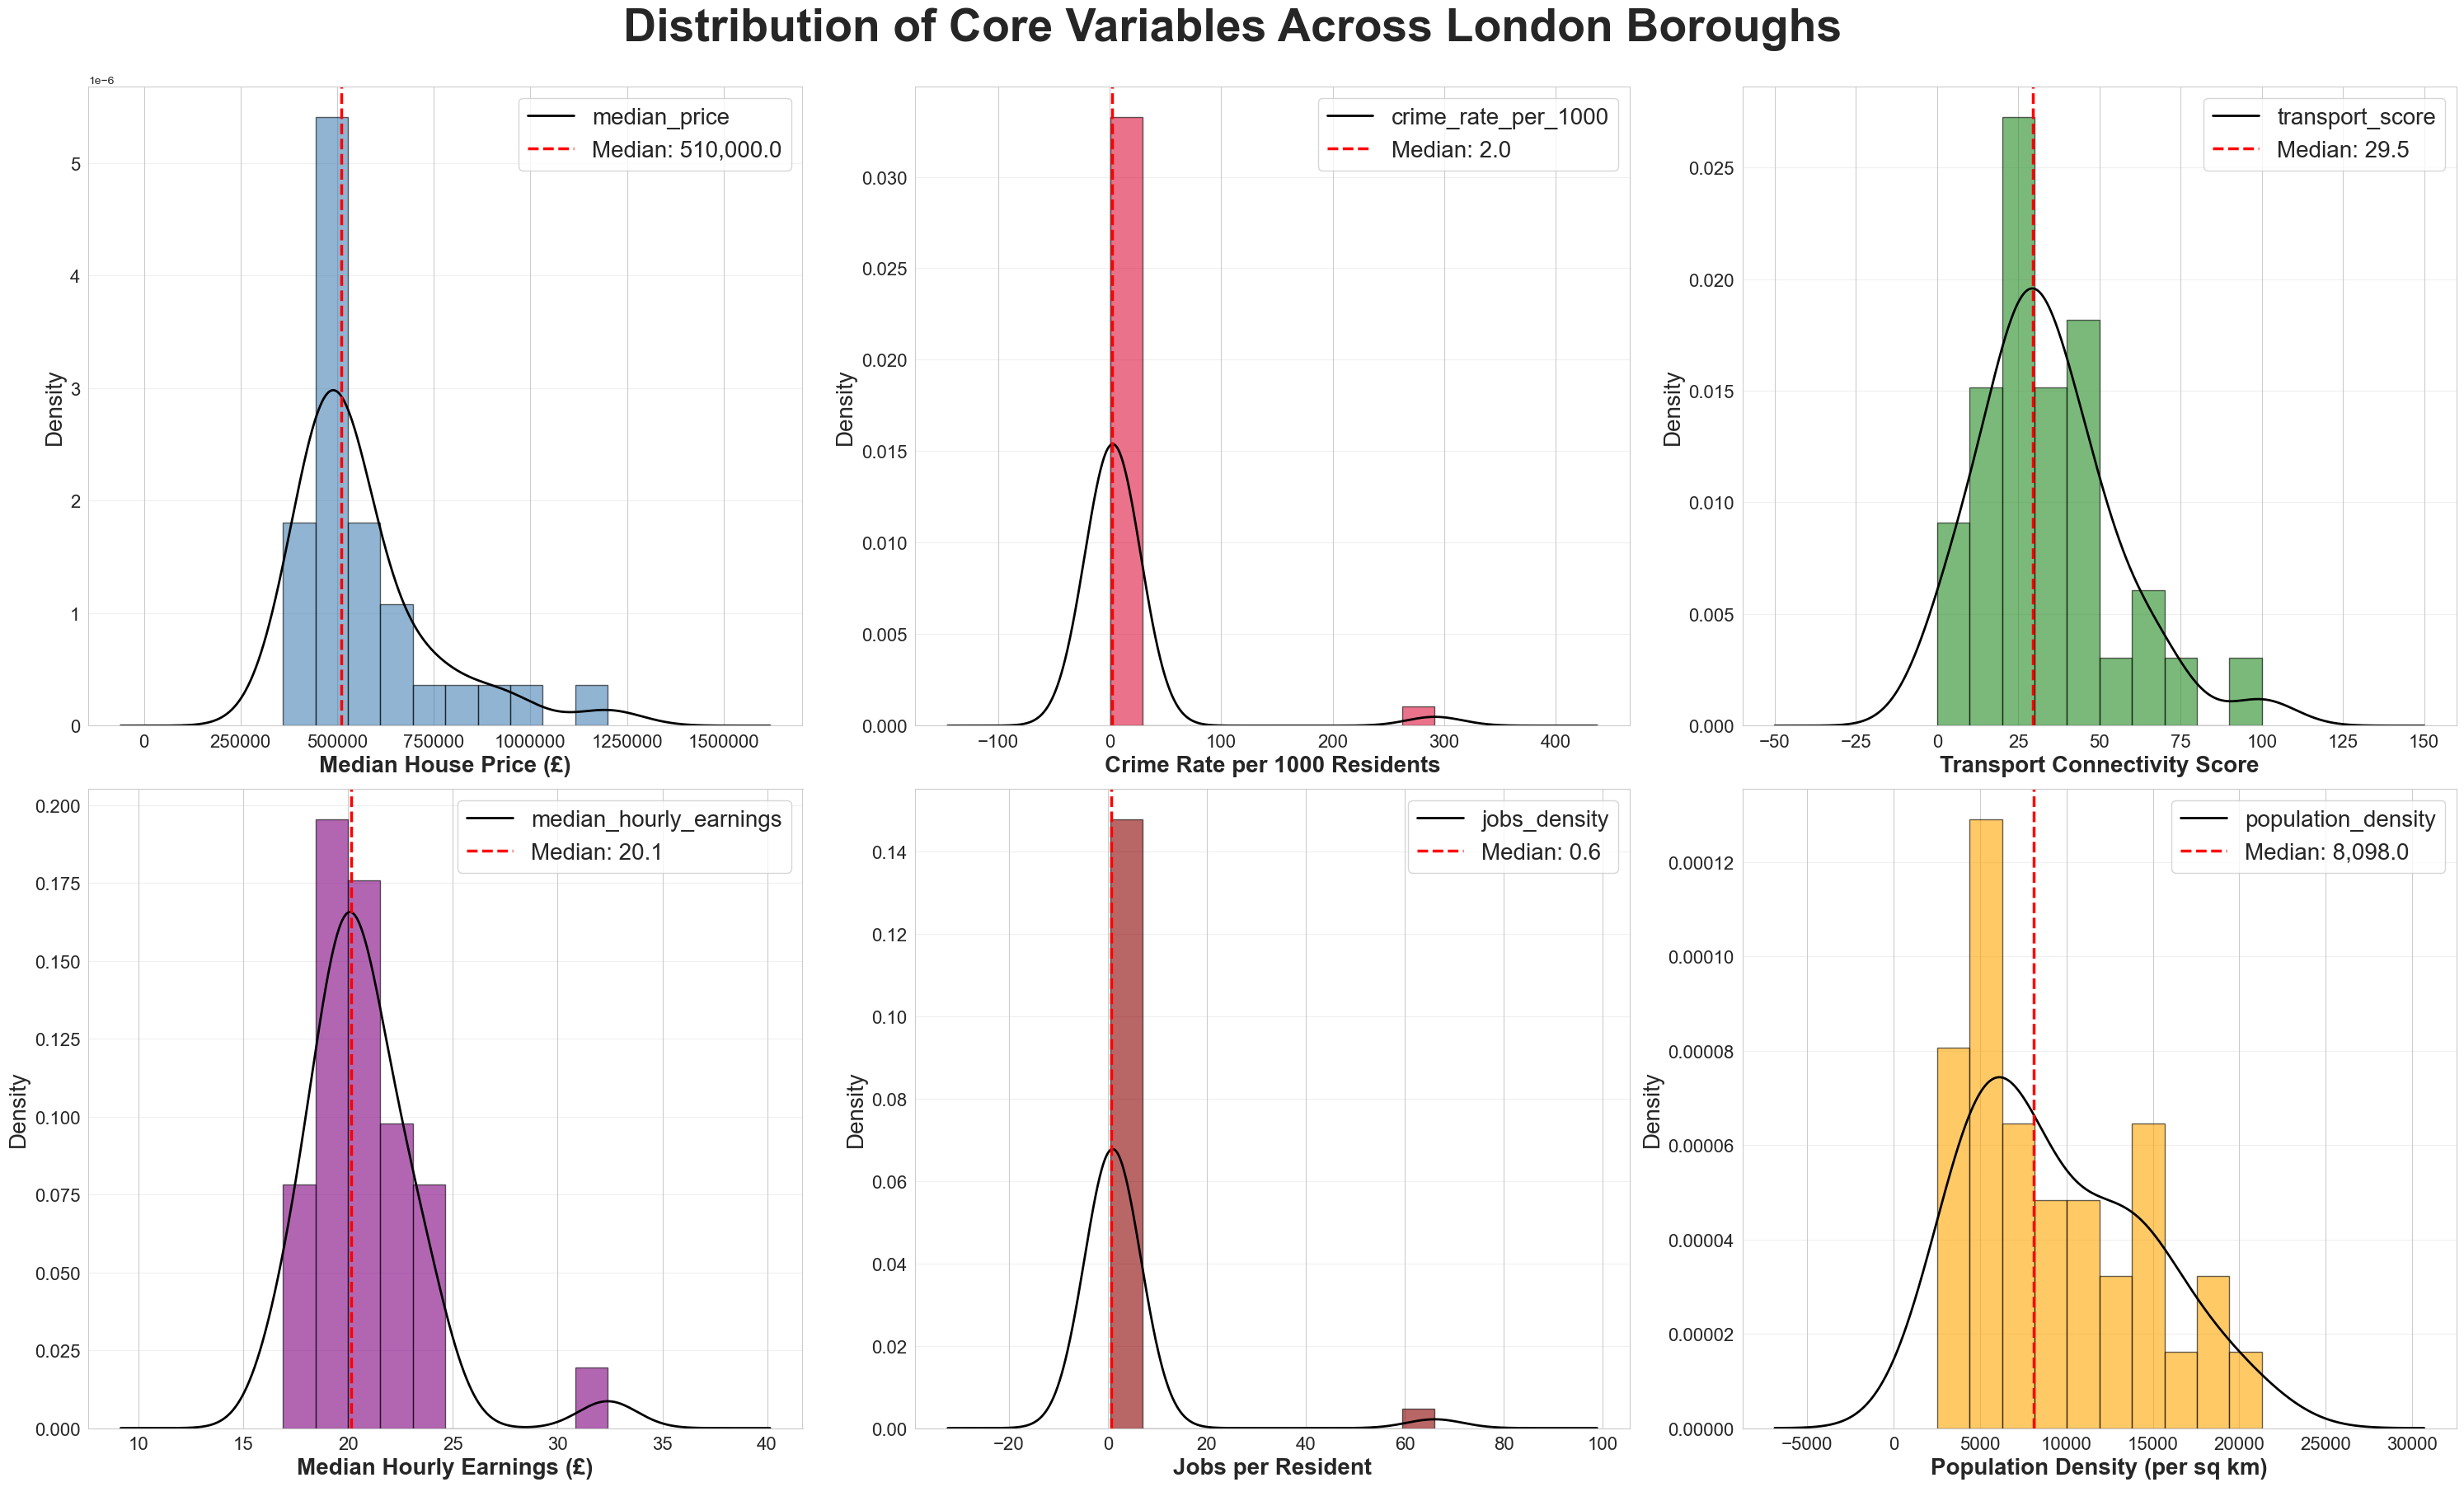

In [13]:
# Distribution of 6 key raw variables
fig, axes = plt.subplots(2, 3, figsize=(30, 18))
fig.suptitle('Distribution of Core Variables Across London Boroughs', 
             fontsize=40, fontweight='bold', y=1.00)

variables = [
    ('median_price', 'Median House Price (£)', 'steelblue'),
    ('crime_rate_per_1000', 'Crime Rate per 1000 Residents', 'crimson'),
    ('transport_score', 'Transport Connectivity Score', 'forestgreen'),
    ('median_hourly_earnings', 'Median Hourly Earnings (£)', 'purple'),
    ('jobs_density', 'Jobs per Resident', 'darkred'),
    ('population_density', 'Population Density (per sq km)', 'orange')
]

for ax, (col, title, color) in zip(axes.flatten(), variables):
    # Histogram with KDE overlay
    ax.hist(df[col], bins=10, color=color, alpha=0.6, edgecolor='black', density=True)
    df[col].plot(kind='density', ax=ax, color='black', linewidth=2)
    
    # Add median line
    median_val = df[col].median()
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2.5, 
               label=f'Median: {median_val:,.1f}')
    
    # Formatting
    ax.set_xlabel(title, fontsize=20, fontweight='bold')
    ax.set_ylabel('Density', fontsize=20)
    ax.legend(loc='upper right', fontsize=20)
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Format x-axis for price and density
    if 'price' in col.lower() or 'density' in col.lower():
        ax.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

**Key Observations:**

- **House Prices:** Right-skewed distribution - most boroughs cluster around £450-550k, but a few ultra-expensive outliers (Westminster, Kensington) push the tail

- **Crime Rate:** Extremely right-skewed - most boroughs are very safe (<2 per 1000), but City of London is a massive outlier due to its tiny residential population and high total crimes

- **Transport Score:** Bimodal distribution shows divide between well-connected Inner London and poorly-connected Outer London

- **Earnings:** Relatively normal distribution with slight right skew - most boroughs between £18-22/hour, City of London being the outlier at £32/hour

- **Jobs Density:** Most boroughs <1 job per resident (residential), but City of London (60+) is an extreme outlier as a business district

- **Population Density:** Wide spread from sparse outer boroughs (~3000/km sq) to dense inner areas (~15000/km sq)

### **Outlier Analysis**

Let's identify and understand the boroughs that deviate significantly from the norm.

OUTLIER DETECTION: EXTREME BOROUGHS

Crime Rate per 1000 Outliers (3 borough(s)):
--------------------------------------------------------------------------------
  • Kensington and Chelsea                 8.20
  • Westminster                           11.39
  • City of London                       291.59

Jobs Density Outliers (3 borough(s)):
--------------------------------------------------------------------------------
  • Westminster                            5.33
  • Camden                                 2.71
  • City of London                        66.02

Median House Price Outliers (3 borough(s)):
--------------------------------------------------------------------------------
  • Kensington and Chelsea         1,200,000.00
  • Westminster                      956,000.00
  • City of London                   901,250.00

Population Density: No outliers detected

Median Hourly Earnings Outliers (1 borough(s)):
--------------------------------------------------------------------

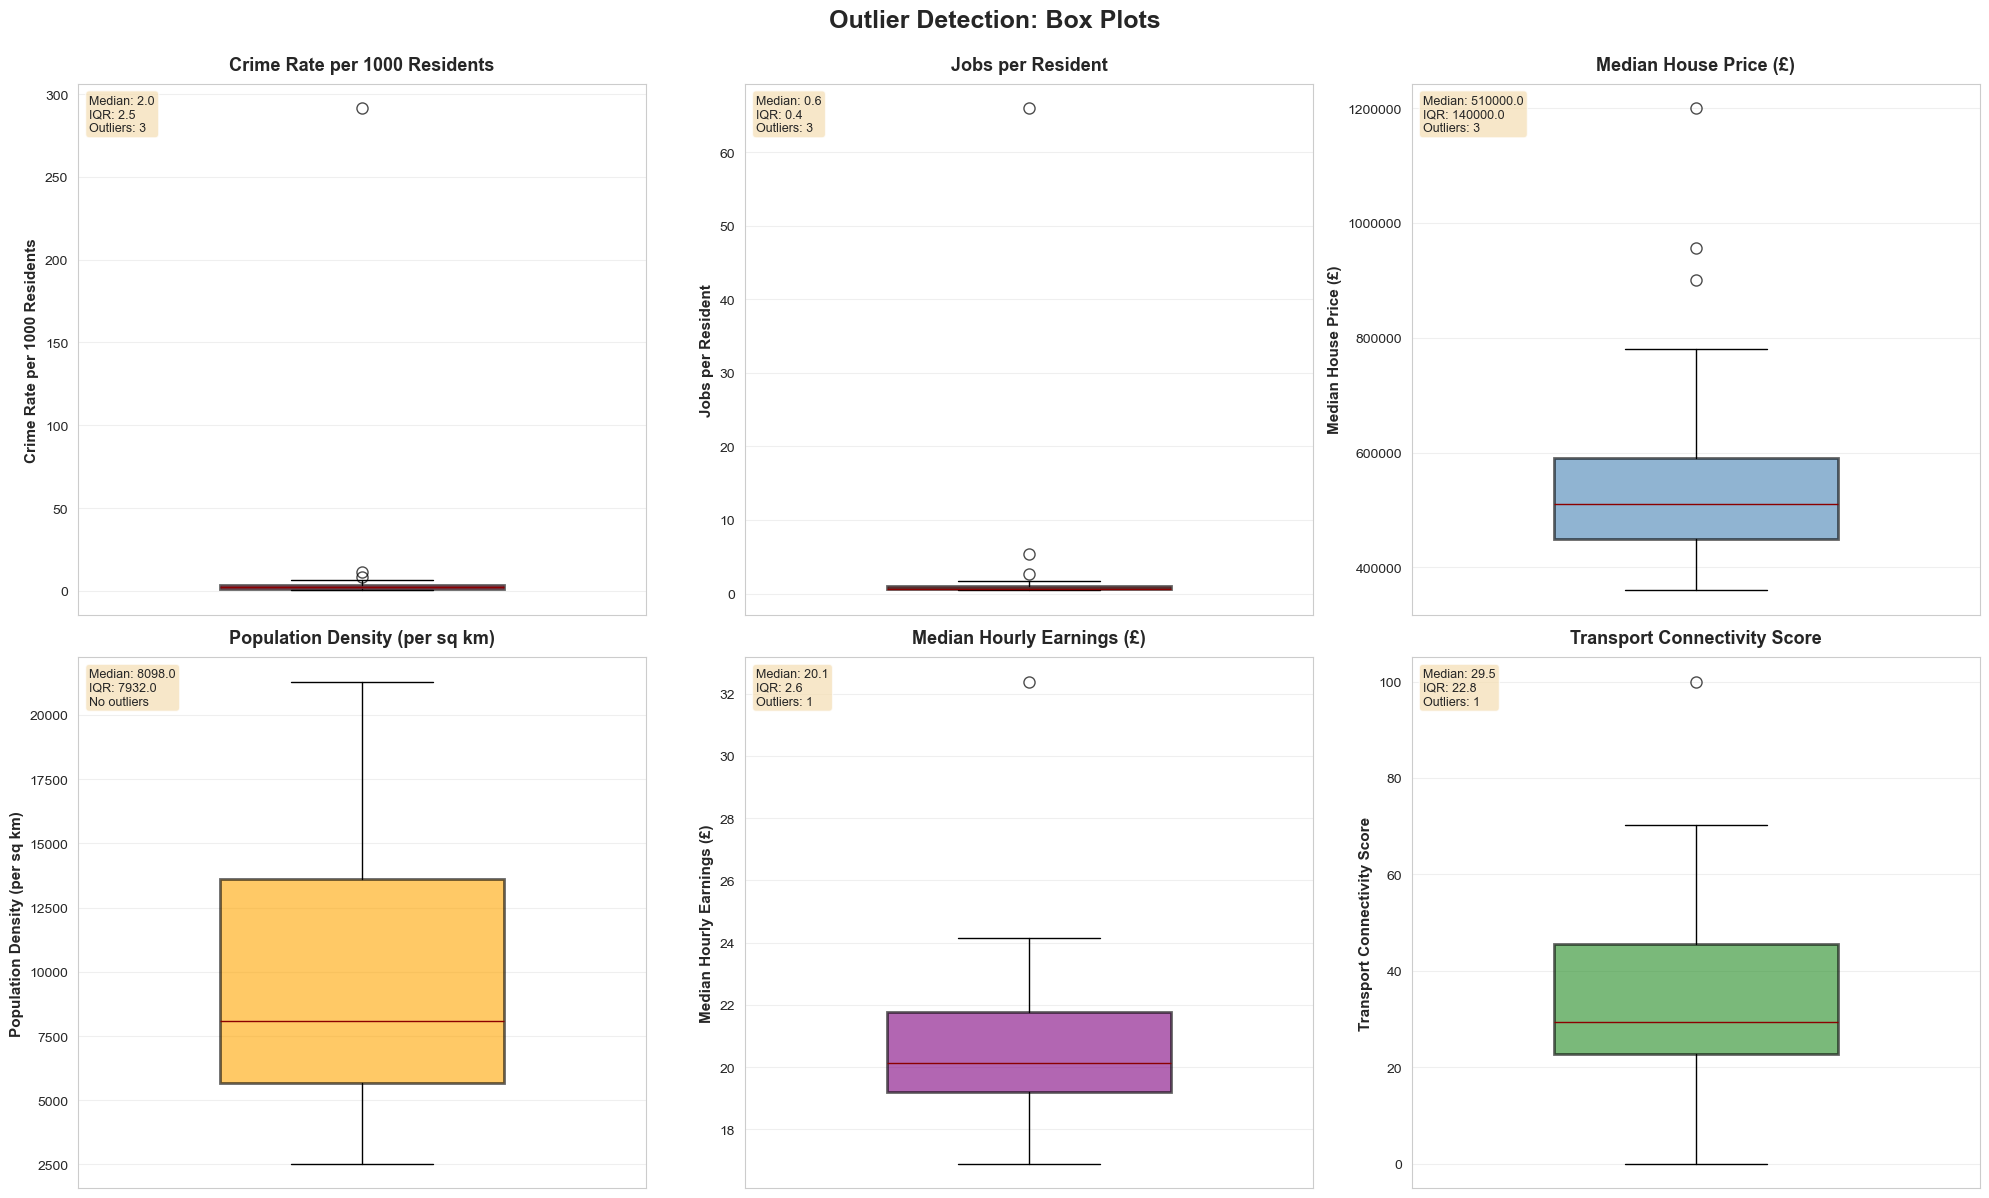

In [14]:
# Identify outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

print("OUTLIER DETECTION: EXTREME BOROUGHS")

outlier_vars = {
    'crime_rate_per_1000': 'Crime Rate per 1000',
    'jobs_density': 'Jobs Density',
    'median_price': 'Median House Price',
    'population_density': 'Population Density',
    'median_hourly_earnings': 'Median Hourly Earnings',
    'transport_score': 'Transport Score'
}

for col, name in outlier_vars.items():
    outliers = detect_outliers(df, col)
    if len(outliers) > 0:
        print(f"\n{name} Outliers ({len(outliers)} borough(s)):")
        print("-" * 80)
        for idx, row in outliers.iterrows():
            print(f"  • {row['borough_name']:30s} {row[col]:>12,.2f}")
    else:
        print(f"\n{name}: No outliers detected")

# Simple box plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Outlier Detection: Box Plots', 
             fontsize=18, fontweight='bold', y=0.995)

box_vars = [
    ('crime_rate_per_1000', 'Crime Rate per 1000 Residents', 'crimson'),
    ('jobs_density', 'Jobs per Resident', 'darkred'),
    ('median_price', 'Median House Price (£)', 'steelblue'),
    ('population_density', 'Population Density (per sq km)', 'orange'),
    ('median_hourly_earnings', 'Median Hourly Earnings (£)', 'purple'),
    ('transport_score', 'Transport Connectivity Score', 'forestgreen')
]

for ax, (col, title, color) in zip(axes.flatten(), box_vars):
    bp = ax.boxplot(df[col], vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][0].set_edgecolor('black')
    bp['boxes'][0].set_linewidth(2)
    bp['medians'][0].set_color('darkred')
    bp['medians'][0].set_linewidth=3
    
    # Style outliers
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.7, markersize=8)
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_xticks([])
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(axis='y', labelsize=10)
    
    if 'price' in col.lower() or 'population_density' in col.lower():
        ax.ticklabel_format(style='plain', axis='y')
    
    # statistics text box
    outliers = detect_outliers(df, col)
    median_val = df[col].median()
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    if len(outliers) > 0:
        stats_text = f'Median: {median_val:.1f}\nIQR: {IQR:.1f}\nOutliers: {len(outliers)}'
    else:
        stats_text = f'Median: {median_val:.1f}\nIQR: {IQR:.1f}\nNo outliers'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

**Outlier Detection Summary**


Crime Rate per 1000 (3 outliers):
- City of London (291.59) - extreme outlier due to tiny residential population and high total crimes due to high footfall
- Westminster (11.39), Kensington & Chelsea (8.20) - tourist/commercial areas

Jobs Density (3 outliers):
- City of London (66.02) - financial district, minimal housing
- Westminster (5.33), Camden (2.71) - major employment centers

Median House Price (3 outliers):
- Kensington & Chelsea (£1.2M), Westminster (£956k), City of London (£901k)
- Ultra-prime central London boroughs

Transport Score (1 outlier):
- Westminster (100.00) - maximum connectivity, hub of all major lines

No Outliers:
- Population Density - all boroughs within normal range
- Median Hourly Earnings - 

### **Liveability Scores Distribution**

How do our calculated liveability metrics distribute across boroughs?

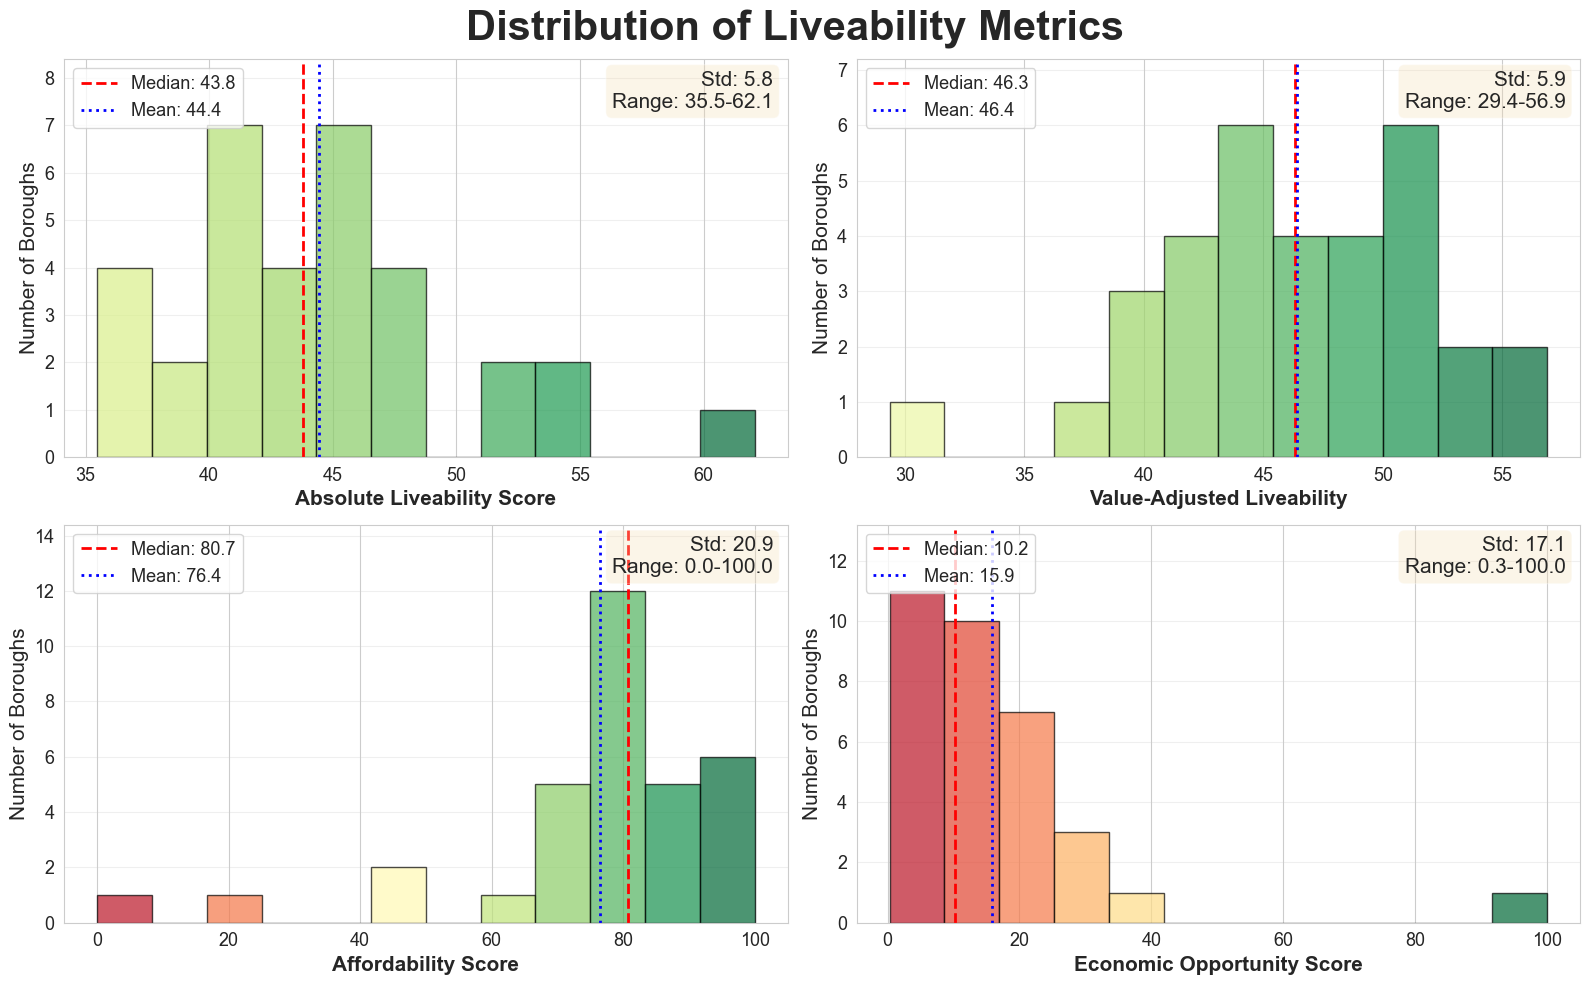

In [15]:
# Distribution of liveability scores
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Distribution of Liveability Metrics', fontsize=30, fontweight='bold')

liveability_vars = [
    ('absolute_liveability', 'Absolute Liveability Score', 'teal'),
    ('value_adjusted_liveability', 'Value-Adjusted Liveability', 'darkgreen'),
    ('affordability_score', 'Affordability Score', 'purple'),
    ('economic_score', 'Economic Opportunity Score', 'navy')
]

for ax, (col, title, color) in zip(axes.flatten(), liveability_vars):
    n, bins, patches = ax.hist(df[col], bins=12, color=color, alpha=0.7, 
                                edgecolor='black', density=False)
    
    # Color bars by value (gradient)
    cm = plt.cm.RdYlGn
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col_map = cm(bin_centers / max(bin_centers))
    for c, p in zip(col_map, patches):
        p.set_facecolor(c)
    
    # Statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()
    
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, 
               label=f'Median: {median_val:.1f}')
    ax.axvline(mean_val, color='blue', linestyle=':', linewidth=2,
               label=f'Mean: {mean_val:.1f}')
    
    ax.set_xlabel(title, fontsize=15, fontweight='bold')
    ax.set_ylabel('Number of Boroughs', fontsize=15)
    ax.legend(loc='upper left', fontsize=13)
    ax.grid(alpha=0.3, axis='y')
    ax.set_ylim(0, max(n) * 1.2)

    ax.tick_params(axis='both', which='major', labelsize=13)
    
    # Add text box with stats
    textstr = f'Std: {std_val:.1f}\nRange: {df[col].min():.1f}-{df[col].max():.1f}'
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

**Distribution Insights:**

London's liveability metrics reveal fundamental structural inequality.

**Absolute liveability** clusters around 43.8 (median) with a 26.6-point range (35.5-62.1), showing all boroughs maintain baseline quality but no dramatic outliers. Westminster (62.06) leads by a modest 8 points above the next tier, with most boroughs occupying the 40-50 range.

**Value-adjusted liveability** shifts the median to 46.3, creating wider differentiation (27.5-point range: 29.4-56.9). The distribution spreads more evenly than absolute scores as incorporating affordability reshapes rankings substantially. Westminster and Tower Hamlets both score near 57, while expensive boroughs with weak transport drop below 40. This wider range confirms that cost considerations amplify differences invisible in pure quality metrics.

**Affordability** shows the starkest divide - most boroughs cluster at 70-90 (affordable), but Central London (Westminster, K&C, Camden) scores near zero, requiring 20-24 years of median earnings to purchase a house with median price. This range captures the city's extreme economic divide.

**Economic opportunity** is heavily right-skewed with median 10.2 far below mean 15.9. Over 27 boroughs score below 20, clustering in the 0-15 range, confirming most function as residential areas. The extreme right tail (City of London at 100, Westminster 36.4, Camden 27.5) pulls the mean upward, showing that employment is concentrated in the financial core while most Londoners commute to access it.

## **4.5 - Correlation Analysis**

Understanding how variables relate to each other reveals the underlying dynamics of London's housing market and quality of life trade-offs.

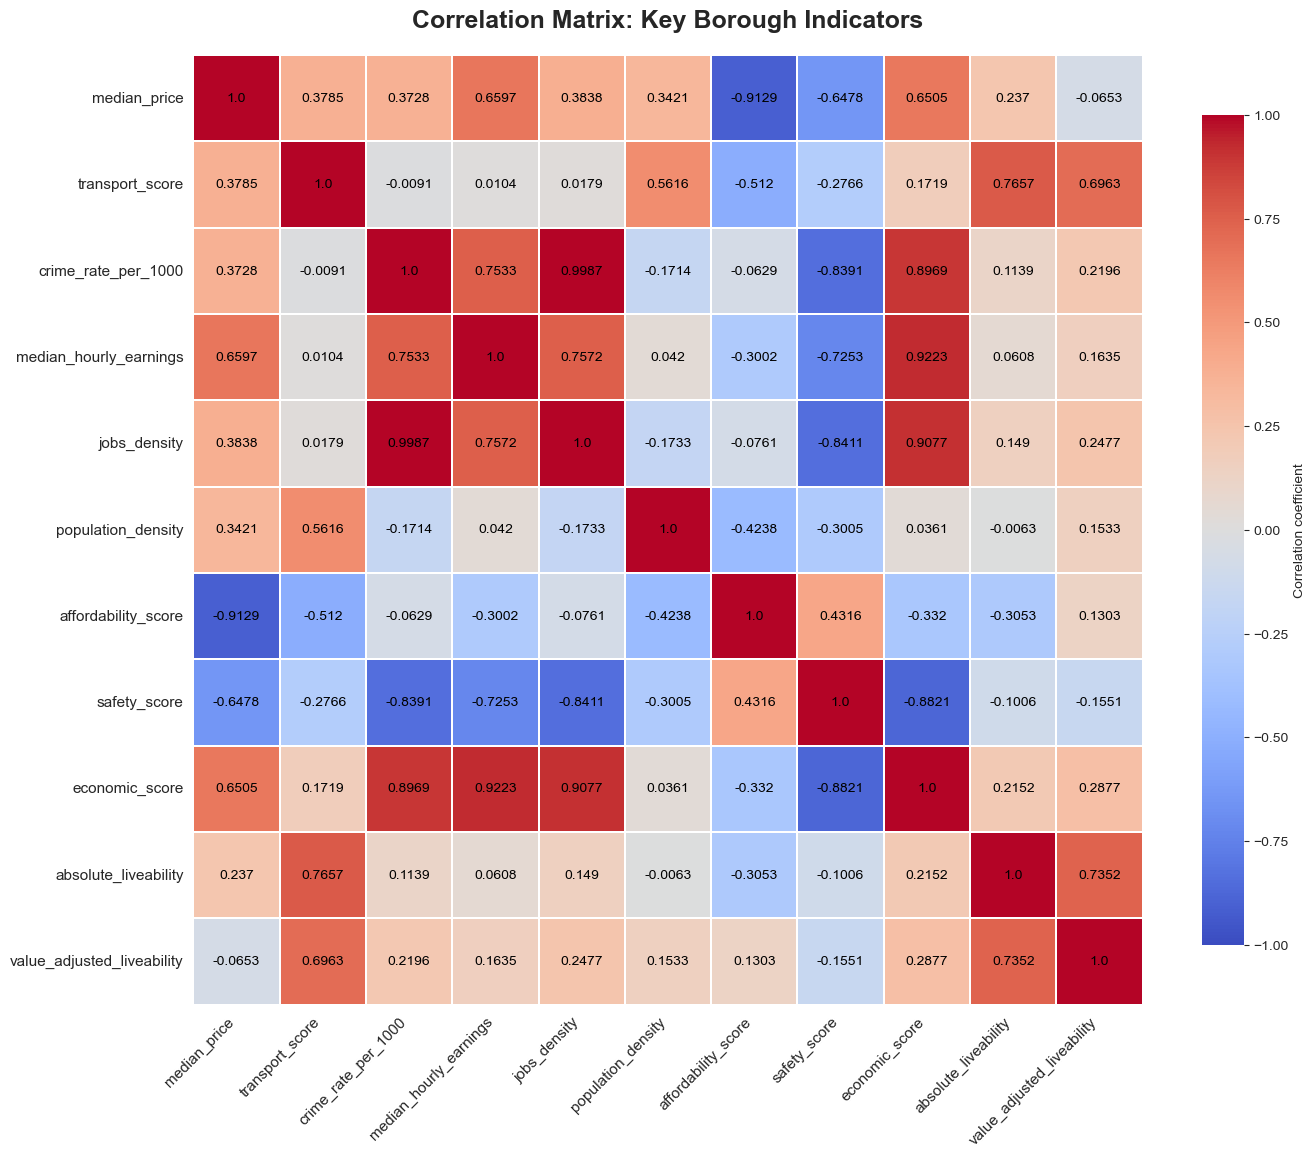

In [16]:
corr_vars = [
    'median_price',
    'transport_score',
    'crime_rate_per_1000',
    'median_hourly_earnings',
    'jobs_density',
    'population_density',
    'affordability_score',
    'safety_score',
    'economic_score',
    'absolute_liveability',
    'value_adjusted_liveability'
]

# Correlation matrix
corr = df[corr_vars].corr()

# Plot heatmap without annotations
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=1.2,
    cbar_kws={"shrink": 0.8, "label": "Correlation coefficient"},
    ax=ax
)

# Adding text to every cell
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{round(corr.iloc[i, j],4)}",
            ha="center",
            va="center",
            color="black",
            fontsize=10
        )

ax.set_xticks(np.arange(len(corr_vars)) + 0.5)
ax.set_yticks(np.arange(len(corr_vars)) + 0.5)
ax.set_xticklabels(corr_vars, rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(corr_vars, rotation=0, fontsize=11)

plt.title(
    "Correlation Matrix: Key Borough Indicators",
    fontsize=18,
    fontweight="bold",
    pad=20
)

plt.tight_layout()
plt.show()


**Correlation analysis: key patterns and interpretation**

The correlation matrix highlights clear and intuitive relationships between housing costs, economic opportunity, transport connectivity, and the constructed liveability measures across London boroughs.

- Housing prices are most strongly associated with economic fundamentals

Median house prices show a strong positive correlation with median hourly earnings and job density, indicating that boroughs with higher incomes and stronger employment conditions tend to command significantly higher property prices. This aligns with a demand-side interpretation: areas with better labour market opportunities attract higher willingness to pay for housing. Transport connectivity also exhibits a moderate positive correlation with prices, suggesting that households are willing to pay more to live in well-connected boroughs with better access to employment and services.


- Crime and employment concentration

An interesting pattern emerges in the relationship between crime and economic activity. Crime rates are highly positively correlated with job density and median hourly earnings and moderately positively correlated with median house prices, implying that boroughs with intense economic activity and high employment concentration also experience higher recorded crime. This likely reflects greater population density, footfall, commercial activity and reporting intensity in central and economically active areas.

- Liveability metrics and internal consistency

The composite liveability measures display strong correlations with their underlying components, particularly transport connectivity and economic conditions. These relationships largely reflect index construction and serve as validation that the composite measures behave as intended. Absolute liveability remains positively correlated with house prices, indicating that boroughs performing well across multiple dimensions also tend to be more expensive. In contrast, the value-adjusted liveability metric shows a weaker and slightly negative association with prices, suggesting that it captures relative quality of life after accounting for cost differences.

- Overall takeaway

Overall, the correlation analysis suggests that housing prices across London boroughs are primarily driven by economic opportunity and income, with transport connectivity playing a secondary but meaningful role. Crime patterns reflect higher footfall and commercial activity, while the constructed liveability measures help distinguish between boroughs that are expensive because they concentrate economic activity and those that may offer comparatively strong living conditions at lower cost. 


## **4.6 - Geographic Patterns: Choropleth Maps**


Visualising how key metrics vary spatially across London reveals distinct geographic clusters and helps identify which areas of the city concentrate different advantages and disadvantages.

### **Median House Price**

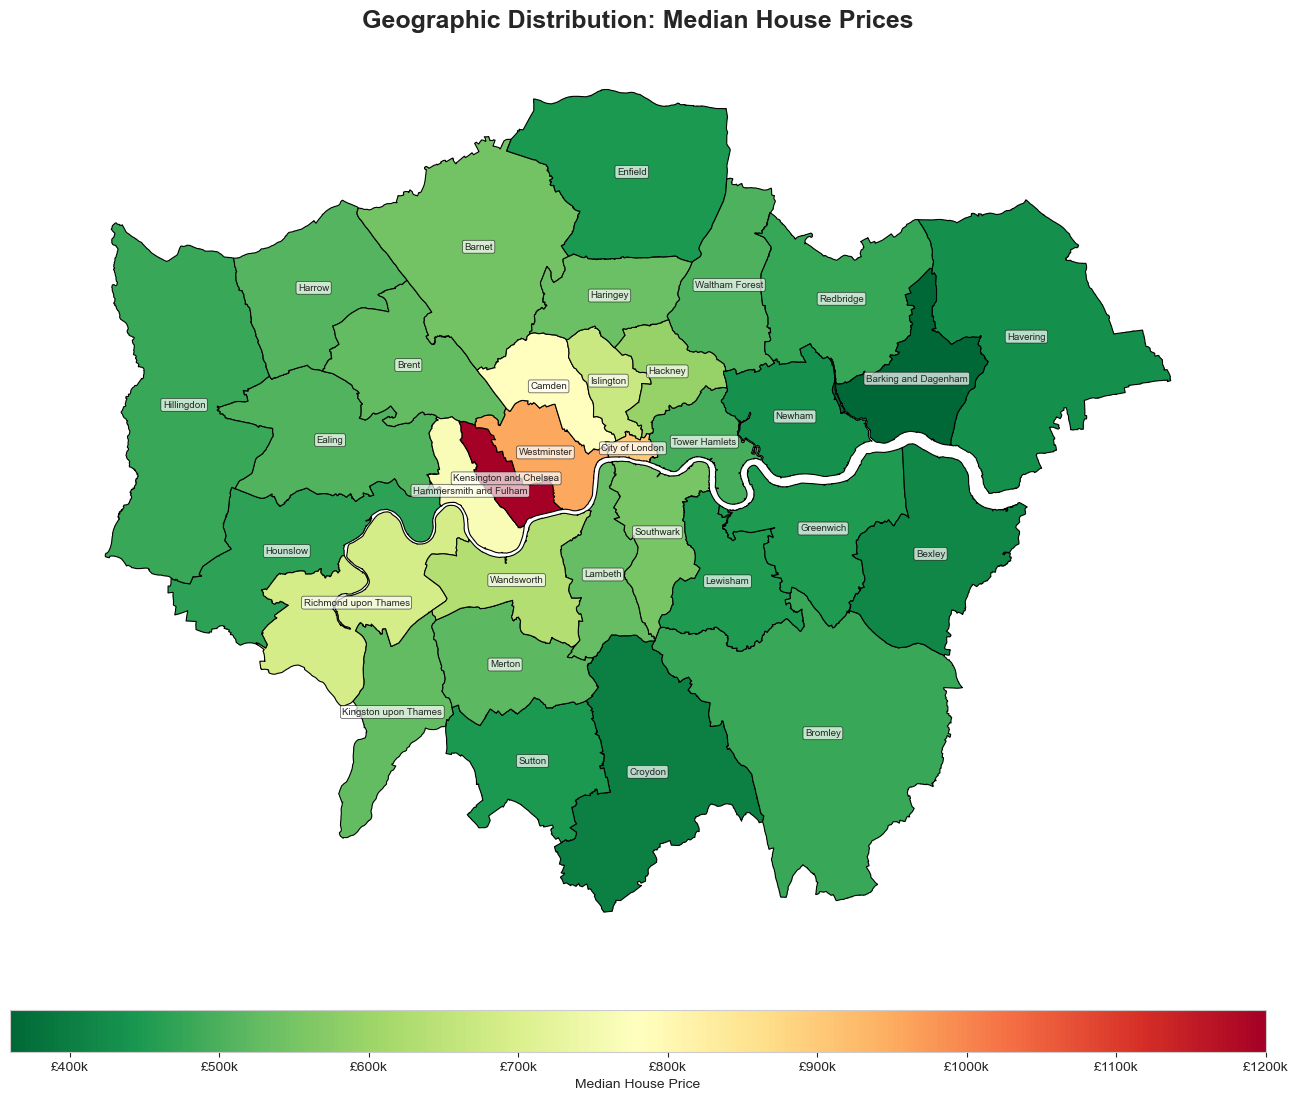

Most expensive:
  Kensington and Chelsea         £ 1,200,000
  Westminster                    £   956,000
  City of London                 £   901,250

Most affordable:
  Barking and Dagenham           £   360,000
  Croydon                        £   400,000
  Bexley                         £   415,000


In [17]:
# Choropleth Map: Median House Price
fig, ax = plt.subplots(figsize=(16, 12))

borough_map = boroughs.merge(df, left_on='NAME', right_on='borough_name', how='left')

borough_map.plot(
    column='median_price',
    ax=ax,
    legend=True,
    cmap='RdYlGn_r',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={
        'label': 'Median House Price', 
        'orientation': 'horizontal',
        'shrink': 0.8, 
        'aspect': 30,
        'pad': 0.05,
        'format': ticker.FuncFormatter(lambda x, p: f'£{int(x/1000)}k')  # Format HERE
    }
)

#borough labels
for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(
        text=row['borough_name'], 
        xy=(centroid.x, centroid.y),
        ha='center', 
        va='center',
        fontsize=7, 
        fontweight='normal',
        bbox=dict(
            boxstyle='round,pad=0.2', 
            facecolor='white', 
            edgecolor='black', 
            alpha=0.7, 
            linewidth=0.5
        )
    )

ax.set_title('Geographic Distribution: Median House Prices', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Most expensive:")
for _, row in df.nlargest(3, 'median_price').iterrows():
    print(f"  {row['borough_name']:30s} £{row['median_price']:>10,.0f}")

print(f"\nMost affordable:")
for _, row in df.nsmallest(3, 'median_price').iterrows():
    print(f"  {row['borough_name']:30s} £{row['median_price']:>10,.0f}")

The house price map reveals a clear reduction in price from central London outward. The most expensive boroughs (Kensington & Chelsea £1.2M, Westminster £956k, Camden £780k) form a central cluster, with prices systematically declining toward the periphery. 

A distinct East-West divide is visible: at equivalent distances from the center, Western boroughs (Richmond, Kingston) command higher prices than Eastern counterparts (Barking, Havering). The River Thames creates a rough axis of symmetry, with North and South banks showing similar pricing patterns within the same zones.

The most affordable boroughs (Barking & Dagenham £360k, Bexley £415k, Croydon £400k) form an outer ring in East and Southeast London.

### **Transport Connectivity Score**

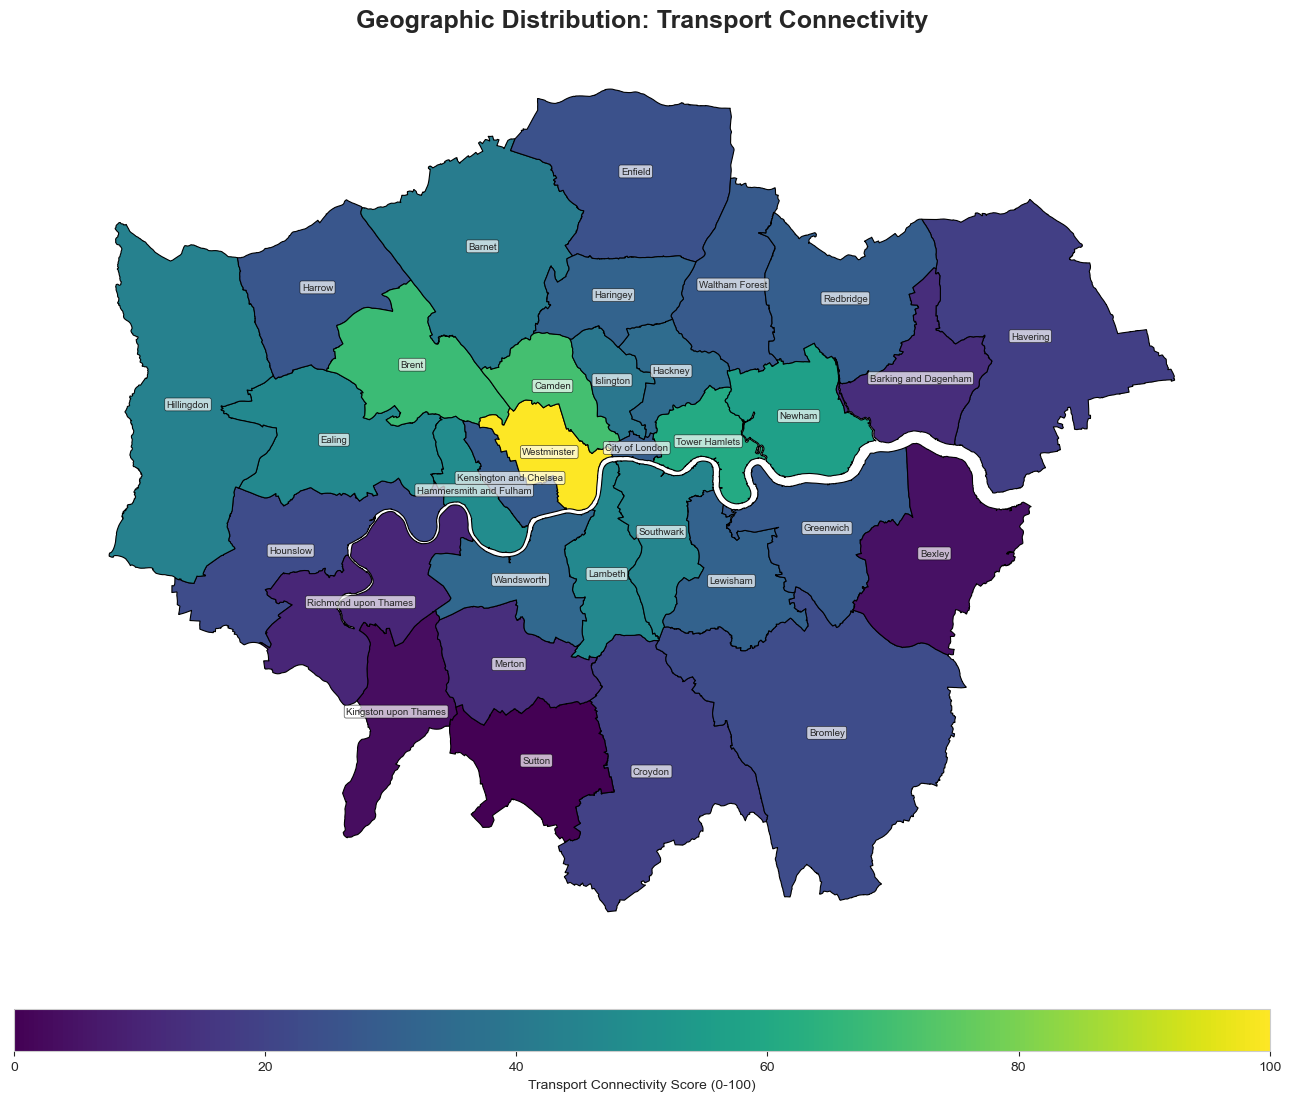

Best connected:  borough_name  transport_score  station_count  bus_route_count
  Westminster           100.00             75              112
       Camden            70.25             57               79
        Brent            68.28             65               61
Tower Hamlets            60.58             67               41
       Newham            56.45             63               39

Worst connected:         borough_name  transport_score  station_count  bus_route_count
              Sutton             0.00              0               26
Kingston upon Thames             3.26              0               33
              Bexley             4.65              0               36
Richmond upon Thames            10.59              8               35
Barking and Dagenham            12.60             14               29


In [18]:
# Choropleth Map: Transport Score
fig, ax = plt.subplots(figsize=(16, 12))

borough_map.plot(
    column='transport_score',
    ax=ax,
    legend=True,
    cmap='viridis',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Transport Connectivity Score (0-100)', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

# borough labels
for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['borough_name'], 
               xy=(centroid.x, centroid.y),
               ha='center', 
               va='center',
               fontsize=7, 
               fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Transport Connectivity', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Best connected: {df.nlargest(5, 'transport_score')[['borough_name', 'transport_score','station_count','bus_route_count']].to_string(index=False)}")
print(f"\nWorst connected: {df.nsmallest(5, 'transport_score')[['borough_name', 'transport_score','station_count','bus_route_count']].to_string(index=False)}")


The map shows that central London is. largely well connected. Westminster (100) dominates with 75 tube stations and 112 bus routes, surrounded by well-connected areas - Camden (70), Brent (68), Tower Hamlets (61).

Connectivity drops sharply with distance. Outer South and East London - Sutton (0), Kingston (3), Bexley (5) - score poorly despite having bus routes because they lack tube stations. Buses alone can't substitute for rail access to central areas with high job density.

### **Housing Affordability**

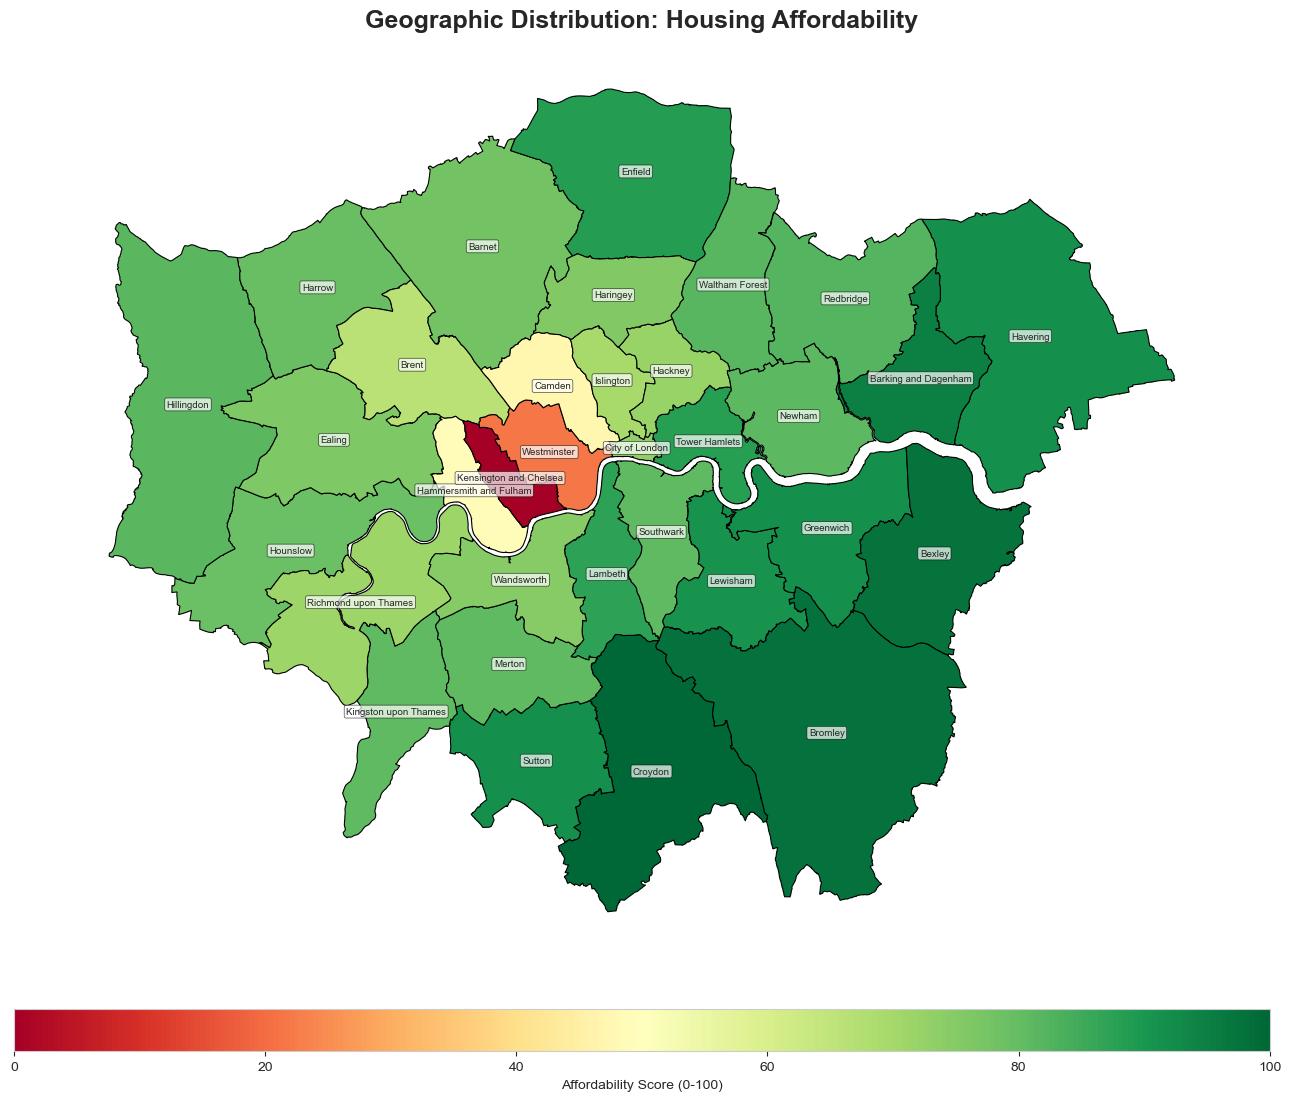


Most affordable: borough_name  affordability_ratio  affordability_score
     Croydon                 9.57               100.00
     Bromley                 9.90                97.72
      Bexley                 9.91                97.65

Least affordable:           borough_name  affordability_ratio  affordability_score
Kensington and Chelsea                24.05                 0.00
           Westminster                20.90                21.75
                Camden                17.22                47.17


In [19]:
# Choropleth Map: Affordability
fig, ax = plt.subplots(figsize=(16, 12))

borough_map.plot(
    column='affordability_score',
    ax=ax,
    legend=True,
    cmap='RdYlGn',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Affordability Score (0-100)', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['borough_name'], 
               xy=(centroid.x, centroid.y),
               ha='center', 
               va='center',
               fontsize=7, 
               fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Housing Affordability', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nMost affordable: {df.nlargest(3, 'affordability_score')[['borough_name', 'affordability_ratio', 'affordability_score']].to_string(index=False)}")
print(f"\nLeast affordable: {df.nsmallest(3, 'affordability_score')[['borough_name', 'affordability_ratio', 'affordability_score']].to_string(index=False)}")


The affordability map is almost the exact inverse of the price map, as expected by construction. The affordable crescent in outer East and Southeast London (Croydon, Bromley, Bexley, Barking, Havering) shows bright green, while central London shows red and orange.

Kensington & Chelsea (24.0x annual earnings), Westminster (20.9x), and Camden (17.2x) require nearly two decades of median income to purchase a house worth the median price, effectively pricing out all but the wealthy elite or dual-high-income households.

Even "middle-tier" boroughs like Wandsworth (12.3x) or Islington (13.4x) require more than a decade of earnings. Only the outer boroughs approach single-digit multiples, making them the only realistic options for buyers without substantial existing wealth or parental support.

### **Crime Rate**

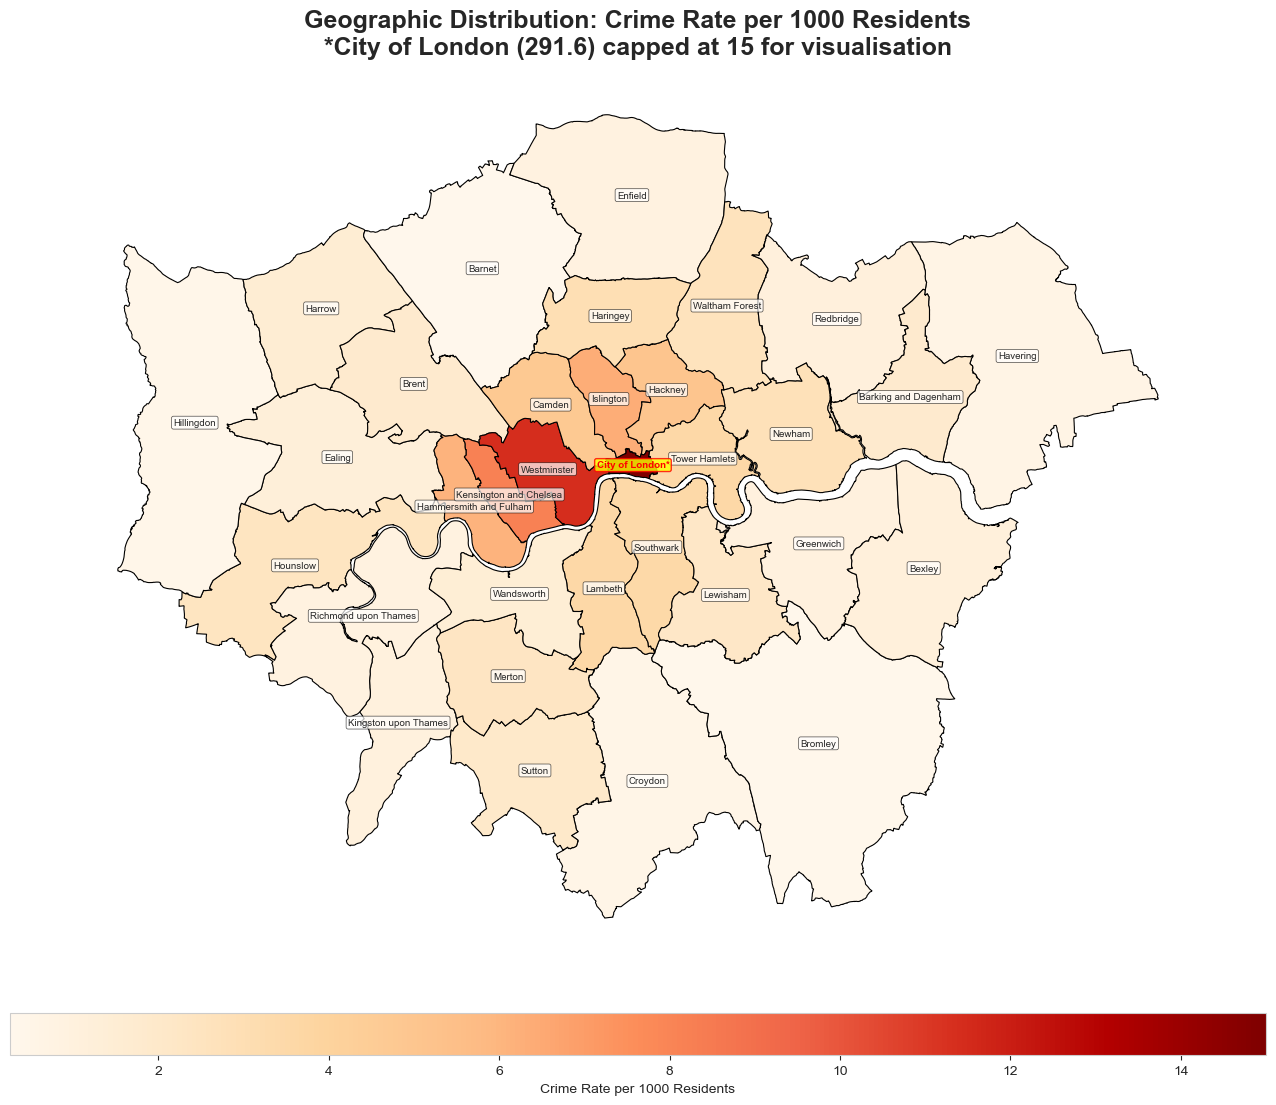

Note: City of London's extreme value (291.6) is capped at 15 for map readability

Highest crime (excluding City):           borough_name  crime_rate_per_1000
           Westminster                11.39
Kensington and Chelsea                 8.20
             Islington                 6.36

Lowest crime: borough_name  crime_rate_per_1000
      Barnet                 0.26
     Bromley                 0.34
  Hillingdon                 0.49


In [ ]:
# Choropleth Map: Crime Rate
fig, ax = plt.subplots(figsize=(16, 12))

# version with City of London capped for visualisation
borough_map_viz = borough_map.copy()
borough_map_viz.loc[borough_map_viz['borough_name'] == 'City of London', 'crime_rate_per_1000'] = 15  # Cap for viz

borough_map_viz.plot(
    column='crime_rate_per_1000',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Crime Rate per 1000 Residents', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

# Add ALL borough labels (with special marker for City of London)
for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    label_text = row['borough_name']
    
    # Mark City of London with asterisk
    if row['borough_name'] == 'City of London':
        label_text = 'City of London*'
        ax.annotate(text=label_text, 
                   xy=(centroid.x, centroid.y),
                   ha='center', 
                   va='center',
                   fontsize=7, 
                   fontweight='bold',
                   color='red',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', 
                            edgecolor='red', alpha=0.8, linewidth=1))
    else:
        ax.annotate(text=label_text, 
                   xy=(centroid.x, centroid.y),
                   ha='center', 
                   va='center',
                   fontsize=7, 
                   fontweight='normal',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                            edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Crime Rate per 1000 Residents\n*City of London (291.6) capped at 15 for visualisation', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: City of London's extreme value (291.6) is capped at 15 for map readability")
print(f"\nHighest crime (excluding City): {df[df['borough_name'] != 'City of London'].nlargest(3, 'crime_rate_per_1000')[['borough_name', 'crime_rate_per_1000']].to_string(index=False)}")
print(f"\nLowest crime: {df.nsmallest(3, 'crime_rate_per_1000')[['borough_name', 'crime_rate_per_1000']].to_string(index=False)}")


The crime map reveals central hotspots (Westminster 11.4, K&C 8.2) surrounded by a safe periphery. City of London's 291.6 rate is off the scale, due to large amounts of tourists, workers, and commercial activity, and also a relatively small resident population.

The crime pattern seems to inversely correlate with affordability, not price. High-crime central boroughs are expensive, with high commercial activity and employment concentration (r = 0.9987 with jobs density). 

The safest outer boroughs (Barnet, Bromley, Havering, all near 1.0 per 1000) are also among the most affordable - delivering both safety and low cost. However, these same areas score low on liveability due to poor transport connectivity and economic opportunity.

### **Absolute Liveability**

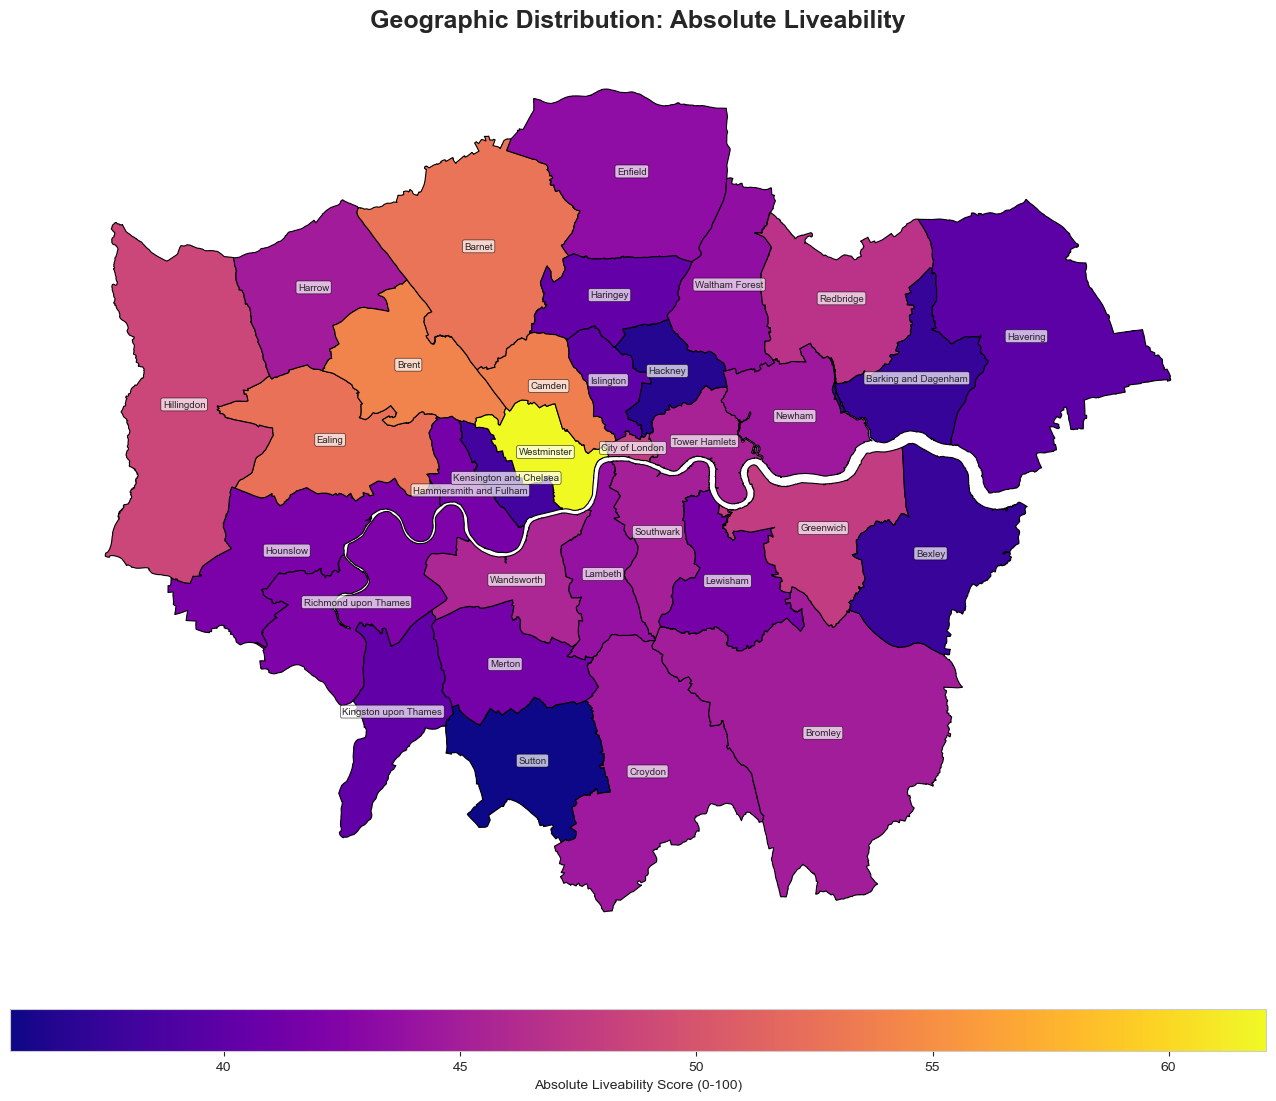

Highest liveability: borough_name  absolute_liveability
 Westminster                 62.06
       Brent                 54.04
      Camden                 53.66
      Barnet                 52.80
      Ealing                 52.58

Lowest liveability:           borough_name  absolute_liveability
                Sutton                 35.47
               Hackney                 36.48
  Barking and Dagenham                 37.51
                Bexley                 37.64
Kensington and Chelsea                 38.26


In [21]:
# Choropleth Map: Absolute Liveability
fig, ax = plt.subplots(figsize=(16, 12))

borough_map.plot(
    column='absolute_liveability',
    ax=ax,
    legend=True,
    cmap='plasma',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Absolute Liveability Score (0-100)', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['borough_name'], 
               xy=(centroid.x, centroid.y),
               ha='center', 
               va='center',
               fontsize=7, 
               fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Absolute Liveability', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Highest liveability: {df.nlargest(5, 'absolute_liveability')[['borough_name', 'absolute_liveability']].to_string(index=False)}")
print(f"\nLowest liveability: {df.nsmallest(5, 'absolute_liveability')[['borough_name', 'absolute_liveability']].to_string(index=False)}")

Westminster (62.06) leads, but the geography is patchy rather than smoothly radial. A North-Northwest corridor (Barnet 52.80, Brent 54.04, Ealing 52.58) performs well despite distance from the center, benefiting from moderate transport and low crime rate.

East London struggles - Hackney (36.48) ranks second-worst despite being Inner London, undermined by poor transport (35.09) and elevated crime (safety 71.23). Kensington & Chelsea (38.26) ranks among the five worst boroughs, appearing in deep purple alongside outer areas. Weak transport (28.84) and high crime (safety 63.51) generate low scores despite extreme wealth.

The map confirms no borough is unliveable - the 27-point range (35.5-62.1) is narrow for a composite metric - but quality varies substantially across a compact city. Geographic patterns reflect transport access and economic opportunity.

### **Value-Adjusted Liveability**

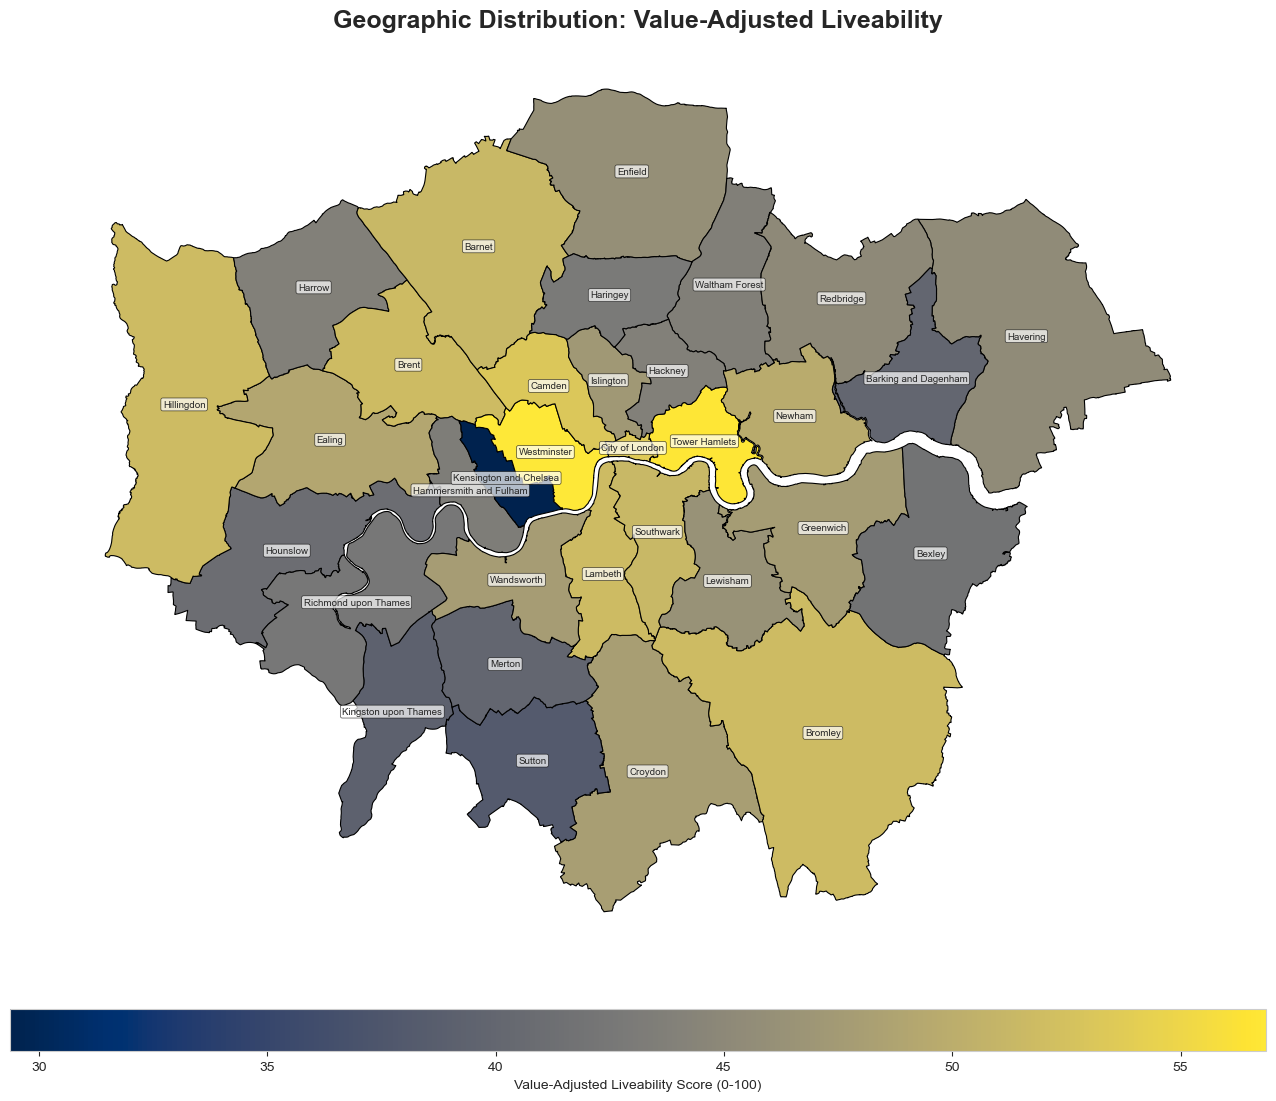

Best value boroughs:   borough_name  value_adjusted_liveability  median_price
   Westminster                       56.87      956000.0
 Tower Hamlets                       56.75      492500.0
City of London                       53.59      901250.0
        Camden                       53.18      780000.0
       Lambeth                       51.82      530000.0

Lowest value adjusted liveability:           borough_name  value_adjusted_liveability  median_price
Kensington and Chelsea                       29.37     1200000.0
                Sutton                       38.09      445750.0
  Kingston upon Thames                       39.25      525000.0
  Barking and Dagenham                       39.93      360000.0
                Merton                       39.96      520000.0


In [22]:
# Choropleth Map: Value-Adjusted Liveability
fig, ax = plt.subplots(figsize=(16, 12))

borough_map.plot(
    column='value_adjusted_liveability',
    ax=ax,
    legend=True,
    cmap='cividis',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Value-Adjusted Liveability Score (0-100)', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['borough_name'], 
               xy=(centroid.x, centroid.y),
               ha='center', 
               va='center',
               fontsize=7, 
               fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Value-Adjusted Liveability', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Best value boroughs: {df.nlargest(5, 'value_adjusted_liveability')[['borough_name', 'value_adjusted_liveability', 'median_price']].to_string(index=False)}")
print(f"\nLowest value adjusted liveability: {df.nsmallest(5, 'value_adjusted_liveability')[['borough_name', 'value_adjusted_liveability', 'median_price']].to_string(index=False)}")


The value-adjusted map reshapes London's geography. Westminster (56.87) and Tower Hamlets (56.75) tie for top value despite different profiles - Westminster housing costs £956k for maximum connectivity and economic access, Tower Hamlets delivers similar value at £492k through balanced trade-offs. City of London (53.59, £901k) ranks third, its high economic opportunities offsetting high crime and high cost.

Camden (53.18), Lambeth (51.82), and the North-Northwest corridor (Brent, Barnet, Hillingdon, Bromley) show yellow, clustering in the 51-54 range. These boroughs combine decent connectivity with moderate affordability and economic opportunities, avoiding the extremes that sink others.

Kensington & Chelsea (29.37) collapses from mid-tier absolute liveability to worst value borough. At £1.2M with weak transport (28.84) and elevated crime (safety 63.51), extreme unaffordability overwhelms any quality advantages. Similarly, expensive Southwest boroughs (Richmond, Kingston, Merton) drop to dark blue despite good absolute scores.

Outer boroughs split by connectivity. Those with moderate transport (Hillingdon, Bromley) achieve yellow through affordability bonuses. But the truly isolated (Sutton 38.09, Barking & Dagenham 39.93) remain dark despite low prices, which suggests that connectivity must exceed a minimum threshold for affordability to create value.

### **Job Density**

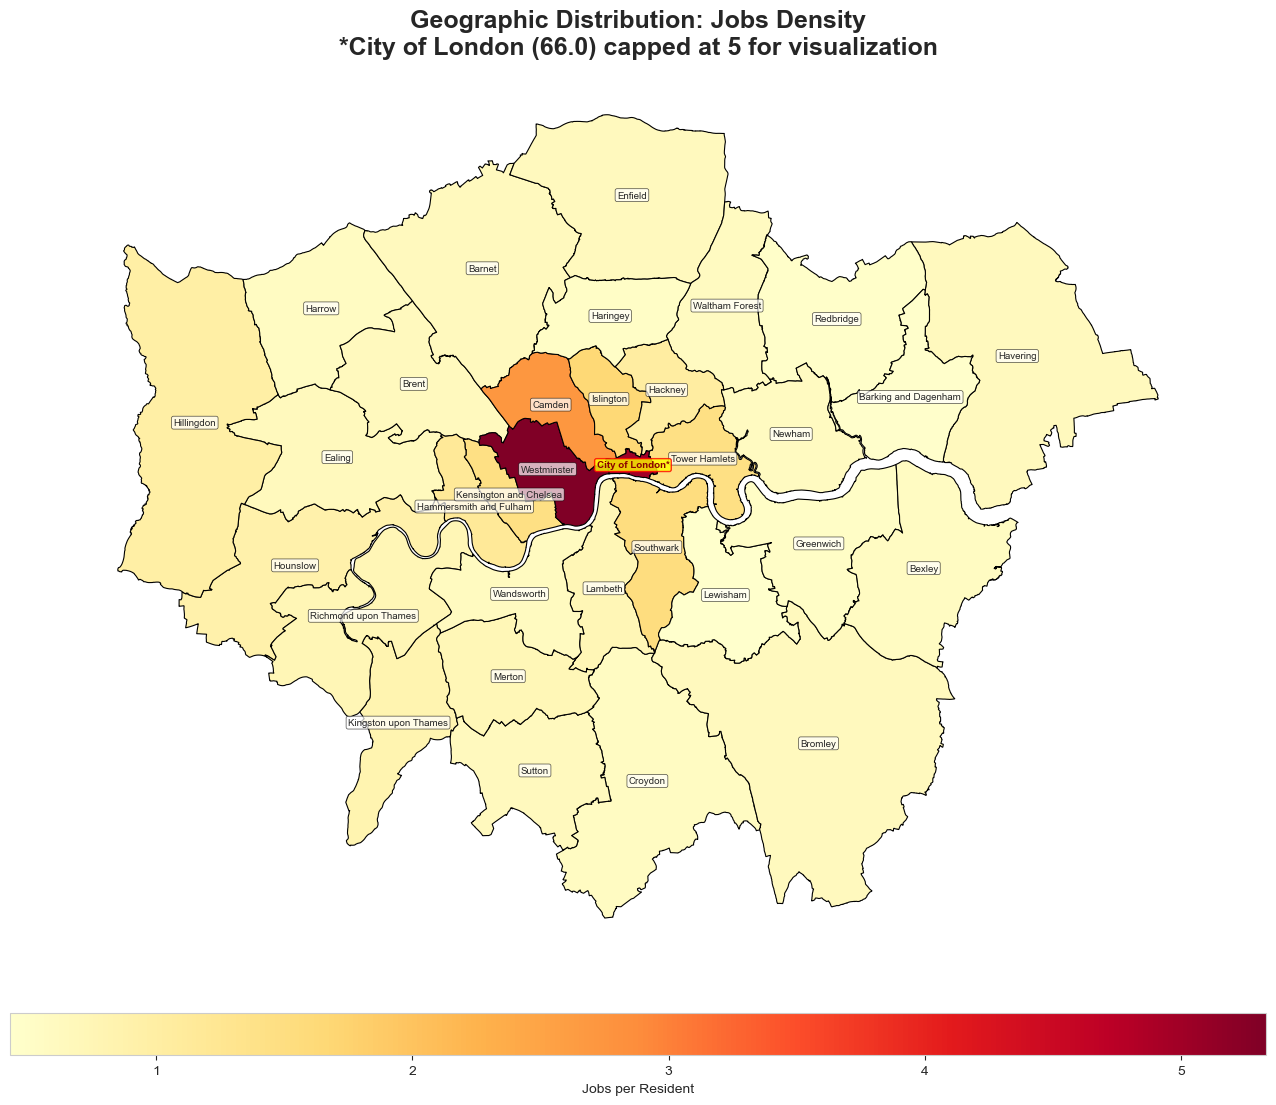

Note: City of London's extreme value (66.0 jobs per resident) is capped at 5 for map readability

Highest jobs density (excluding City):
  Westminster                      5.33
  Camden                           2.71
  Islington                        1.67
  Southwark                        1.53
  Tower Hamlets                    1.46

Lowest jobs density:
  Lewisham                         0.43
  Barking and Dagenham             0.46
  Redbridge                        0.48
  Greenwich                        0.51
  Haringey                         0.52


In [ ]:
# Choropleth Map 7: Jobs Density
fig, ax = plt.subplots(figsize=(16, 12))

# version with City of London capped for visualization
borough_map_viz = borough_map.copy()
borough_map_viz.loc[borough_map_viz['borough_name'] == 'City of London', 'jobs_density'] = 5  # Cap for viz

borough_map_viz.plot(
    column='jobs_density',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Jobs per Resident', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

# Add ALL borough labels (with special marker for City of London)
for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    label_text = row['borough_name']
    
    # Mark City of London with asterisk
    if row['borough_name'] == 'City of London':
        label_text = 'City of London*'
        ax.annotate(text=label_text, 
                   xy=(centroid.x, centroid.y),
                   ha='center', 
                   va='center',
                   fontsize=7, 
                   fontweight='bold',
                   color='darkred',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', 
                            edgecolor='red', alpha=0.8, linewidth=1))
    else:
        ax.annotate(text=label_text, 
                   xy=(centroid.x, centroid.y),
                   ha='center', 
                   va='center',
                   fontsize=7, 
                   fontweight='normal',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                            edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Jobs Density\n*City of London (66.0) capped at 5 for visualization', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: City of London's extreme value (66.0 jobs per resident) is capped at 5 for map readability")
print(f"\nHighest jobs density (excluding City):")
for _, row in df[df['borough_name'] != 'City of London'].nlargest(5, 'jobs_density').iterrows():
    print(f"  {row['borough_name']:30s} {row['jobs_density']:>6.2f}")

print(f"\nLowest jobs density:")
for _, row in df.nsmallest(5, 'jobs_density').iterrows():
    print(f"  {row['borough_name']:30s} {row['jobs_density']:>6.2f}")

Jobs concentrate intensely in a tiny central core. City of London (66.0 jobs per resident) dominates as the financial district, surrounded by Westminster (5.33) and Camden (2.71) in dark red-orange. These three boroughs function as London's primary employment hub.

The rest of London is uniformly pale yellow, clustering at 0.4-1.0 jobs per resident. Inner London boroughs like Islington, Tower Hamlets, and Southwark show between 1 and 2 jobs per resident. The map suggests that in most boroughs, people live there but work elsewhere.

This extreme concentration explains why transport connectivity matters so critically for liveability. Without tube access to the central employment core, residents in outer boroughs are effectively excluded from London's economic opportunities regardless of housing affordability.

### **Median Hourly Earnings**

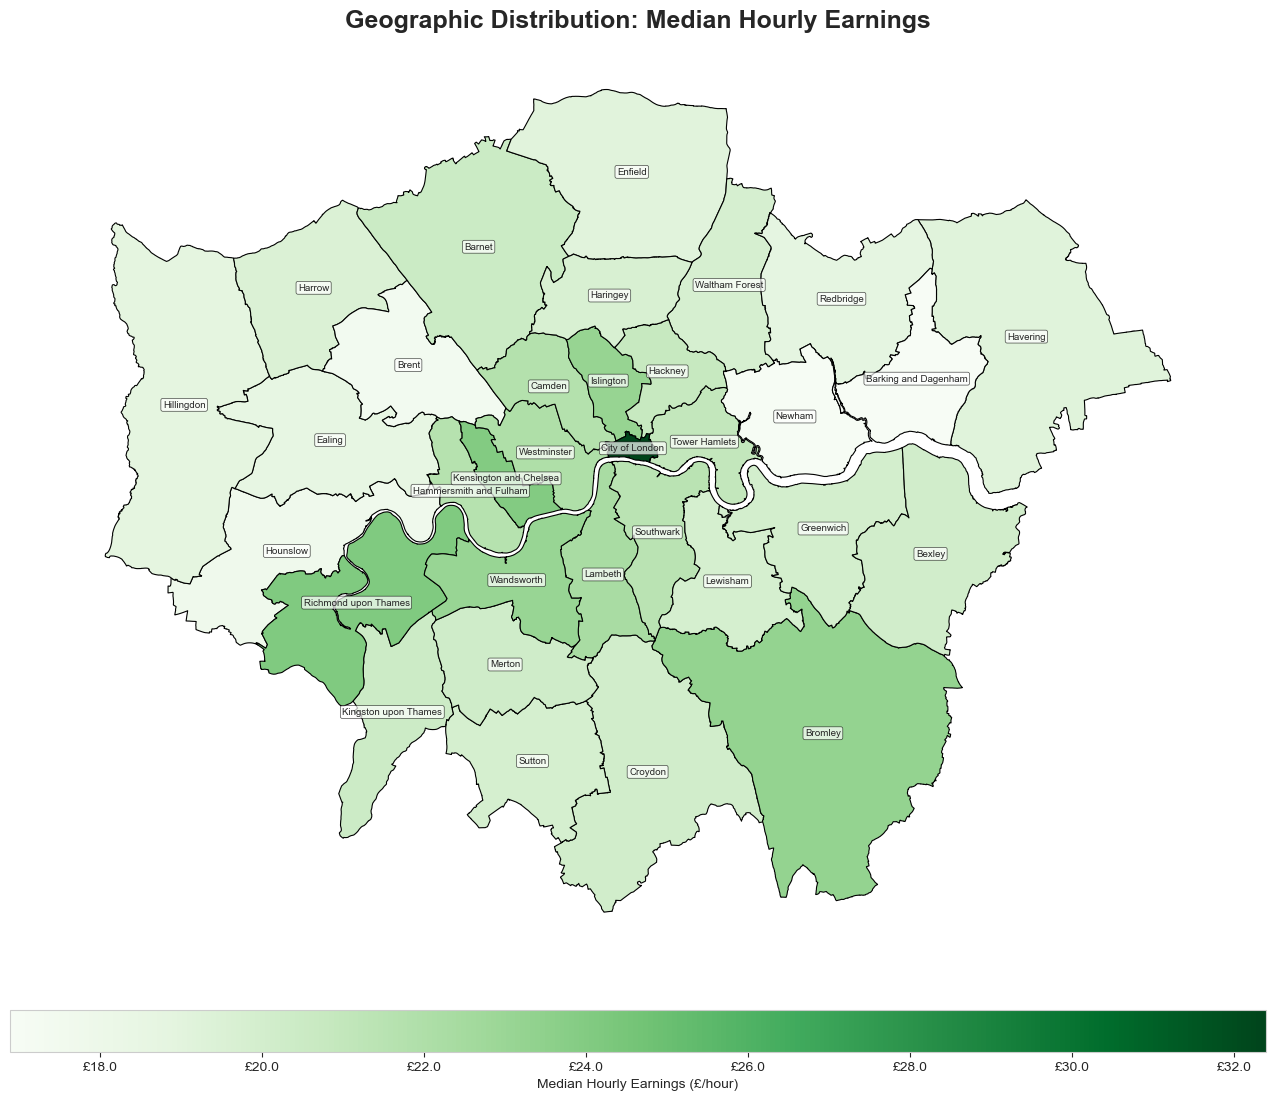

Highest earnings:
  City of London                 £ 32.39/hour
  Richmond upon Thames           £ 24.15/hour
  Kensington and Chelsea         £ 23.99/hour
  Bromley                        £ 23.30/hour
  Islington                      £ 23.13/hour

Lowest earnings:
  Barking and Dagenham           £ 16.89/hour
  Newham                         £ 16.96/hour
  Brent                          £ 17.43/hour
  Hounslow                       £ 17.76/hour
  Ealing                         £ 18.59/hour


In [23]:
# Choropleth Map: Median Hourly Earnings
fig, ax = plt.subplots(figsize=(16, 12))

borough_map.plot(
    column='median_hourly_earnings',
    ax=ax,
    legend=True,
    cmap='Greens',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Median Hourly Earnings (£/hour)', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05,
                 'format': ticker.FuncFormatter(lambda x, p: f'£{x:.1f}')}
)
for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['borough_name'], 
               xy=(centroid.x, centroid.y),
               ha='center', 
               va='center',
               fontsize=7, 
               fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Median Hourly Earnings', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Highest earnings:")
for _, row in df.nlargest(5, 'median_hourly_earnings').iterrows():
    print(f"  {row['borough_name']:30s} £{row['median_hourly_earnings']:>6.2f}/hour")

print(f"\nLowest earnings:")
for _, row in df.nsmallest(5, 'median_hourly_earnings').iterrows():
    print(f"  {row['borough_name']:30s} £{row['median_hourly_earnings']:>6.2f}/hour")

Earnings are remarkably uniform across London - the entire city clusters within £16-24/hour, showing mostly light to mid-green. This narrow £8 range contrasts sharply with house prices (£360k-£1.2M) and jobs density (0.4-66 per resident).

City of London (£32.39, darkest green) is an outlier with the highest hourly earning rate. Excluding it, Richmond (£24.15), Kensington & Chelsea (£23.99), and Bromley (£23.30) lead by only 50% over East London's lowest earners (Barking & Dagenham £16.89, Newham £16.96, Brent £17.43). Differences in median hourly earning are much less compared to London's housing geography.

## **Part 5: Modelling - Linear Regression**

### *Can we predict house prices using factors like transport connectivity, safety, and economic opportunity?*

### Approach
We use **Ordinary Least Squares (OLS) regression** to model median house prices as a function of key borough characteristics. This allows us to:
1. Quantify the relationship between each factor and house prices
2. Identify which factors are most predictive of price
3. Assess how much of the variation in London house prices can be explained by measurable borough attributes

### Methodology
- **Target variable**: `median_price` (median house price per borough, £)
- **Features**: 
  - `median_hourly_earnings`: Median hourly wage (£)
  - `jobs_density_log`: Log-transformed jobs per resident
  - `crime_rate_per_1000`: Crimes per 1000 residents (12-month period)
  - `transport_score`: Composite transport connectivity (0-100)
- **Validation**: Leave-One-Out Cross-Validation (LOOCV), appropriate for small sample sizes
- **Exclusion**: City of London is excluded as it is a financial district rather than a residential borough. With a population of just ~10,600 and 66 jobs per resident (compared to ~0.5 for typical boroughs), it represents a statistical outlier that distorts model estimates. When included, it caused the cross-validated R² to become negative, indicating that a single observation was dominating the fit. Conceptually, our research question concerns residential liveability, and City of London functions primarily as a workplace rather than a neighbourhood where people choose to live.

We apply a log transformation to `jobs_density` due to its heavy right skew.

### i. Setup and Feature Selection

In [ ]:
model_df = master_df.drop(master_df[master_df['borough_name'] == 'City of London'].index)

# log-transforming jobs_density
model_df['jobs_density_log'] = np.log1p(model_df['jobs_density'])

# defining features and target
feature_cols = ['median_hourly_earnings', 'jobs_density_log', 'crime_rate_per_1000', 'transport_score']
target_col = 'median_price'

X = model_df[feature_cols].copy()
y = model_df[target_col].copy()

print(f"Sample size: n = {len(y)} boroughs (City of London excluded)")
print(f"\nTarget variable (median_price):")
print(f"  Mean:  £{y.mean()}")
print(f"  Std:   £{y.std()}")
print(f"  Range: £{y.min()} – £{y.max()}")
print(f"\nFeature summary:")
print(X.describe().round(2))

Sample size: n = 32 boroughs (City of London excluded)

Target variable (median_price):
  Mean:  £555074.0625
  Std:   £171191.38425824483
  Range: £360000.0 – £1200000.0

Feature summary:
       median_hourly_earnings  jobs_density_log  crime_rate_per_1000  \
count                   32.00             32.00                32.00   
mean                    20.39              0.63                 2.69   
std                      1.92              0.31                 2.49   
min                     16.89              0.36                 0.26   
25%                     19.17              0.46                 1.01   
50%                     20.12              0.49                 1.94   
75%                     21.67              0.69                 3.52   
max                     24.15              1.85                11.39   

       transport_score  
count            32.00  
mean             34.09  
std              21.46  
min               0.00  
25%              21.88  
50%         

### ii. OLS Regression Results
We fit an OLS model using `statsmodels` to obtain coefficient estimates, standard errors, and p-values for statistical inference.

In [20]:
# adding constant for intercept
X_const = sm.add_constant(X)

# fitting model
ols_model = sm.OLS(y, X_const).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           median_price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     21.31
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           4.99e-08
Time:                        22:27:45   Log-Likelihood:                -407.72
No. Observations:                  32   AIC:                             825.4
Df Residuals:                      27   BIC:                             832.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.94

### iii. Model Validation: Leave-One-Out Cross-Validation

With only 32 observations, a traditional train/test split would be unreliable. Instead, we use **Leave-One-Out Cross-Validation (LOOCV)**, which:
- Trains on 31 boroughs, predicts the held-out borough
- Repeats for all 32 boroughs
- Provides an unbiased estimate of out-of-sample performance

In [46]:
loo = LeaveOneOut()
lr = LinearRegression()

# cross-validated predictions
y_pred_cv = cross_val_predict(lr, X, y, cv=loo)

# CV metrics
cv_r2 = r2_score(y, y_pred_cv)
cv_rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
cv_mae = np.mean(np.abs(y - y_pred_cv))

# Training metrics
lr.fit(X, y)
y_pred_train = lr.predict(X)
train_r2 = r2_score(y, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y, y_pred_train))

print("MODEL PERFORMANCE")
print("\nMetric\t\tTraining Set\t\tLOOCV")
print(f"R²\t\t {train_r2:.3f} \t\t\t {cv_r2:.3f}")
print(f"RMSE\t\t £{train_rmse:,.0f} \t\t £{cv_rmse:,.0f}")
print(f"MAE\t\t —\t\t\t £{cv_mae:,.0f}")

print(f"\nInterpretation:")
print(f"The model explains {train_r2*100:.1f}% of variance in training dataand {cv_r2*100:.1f}% under cross-validation. Average prediction error: £{cv_mae:.0f} ({(cv_mae/y.mean())*100:.1f}% of mean price)")

MODEL PERFORMANCE

Metric		Training Set		LOOCV
R²		 0.759 			 0.557
RMSE		 £82,644 		 £112,093
MAE		 —			 £78,831

Interpretation:
The model explains 75.9% of variance in training dataand 55.7% under cross-validation. Average prediction error: £78831 (14.2% of mean price)


### iv. Coefficient Analysis

The regression coefficients tell us how much median house price changes for each unit increase in a predictor, holding other factors constant.

In [63]:
# coefficient summary table
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr.coef_,
    'Std Error': ols_model.bse[1:].values,
    't-value': ols_model.tvalues[1:].values,
    'p-value': ols_model.pvalues[1:].values
})
coef_df['Significant'] = coef_df['p-value'].apply(
    lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.1 else ''))
)
coef_df = coef_df.sort_values('p-value')

print("COEFFICIENT SUMMARY")
print(f"\nIntercept: £{lr.intercept_:,.0f}\n")
print(coef_df.to_string(index=False))
print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.1")

print("\nCOEFFICIENT INTERPRETATION:")
for _, row in coef_df.iterrows():
    feat = row['Feature']
    coef = row['Coefficient']
    pval = row['p-value']
    
    if pval < 0.05: # significant
        if feat == 'median_hourly_earnings':
            print(f"\n• Median Hourly Earnings (significant, p={pval:.3f}):")
            print(f"  Each additional £1/hour in median wages - £{coef:,.0f} in house price")
        elif feat == 'jobs_density_log':
            print(f"\n• Jobs Density - log transformed (significant, p={pval:.3f}):")
            print(f"  Doubling jobs per resident - ~£{coef * np.log(2):,.0f} in house price")
        elif feat == 'crime_rate_per_1000':
            print(f"\n• Crime Rate (significant, p={pval:.3f}):")
            direction = "decrease" if coef < 0 else "increase"
            print(f"  Each additional crime per 1000 residents - £{abs(coef):,.0f} {direction} in house price")
        elif feat == 'transport_score':
            print(f"\n• Transport Score (significant, p={pval:.3f}):")
            direction = "increase" if coef > 0 else "decrease"
            print(f"  Each point on transport score (0-100) - £{abs(coef):,.0f} {direction} in house price")
    else:
        print(f"\n• {feat} (not significant, p={pval:.3f}):")
        print(f"  No statistically significant relationship.")

COEFFICIENT SUMMARY

Intercept: £-294,190

               Feature   Coefficient     Std Error   t-value  p-value Significant
   crime_rate_per_1000  42844.132328  11589.625649  3.696766 0.000981         ***
median_hourly_earnings  35801.381080   9983.167254  3.586175 0.001308         ***
       transport_score    316.111343   1110.150022  0.284747 0.778011            
      jobs_density_log -10800.203463 108962.493250 -0.099119 0.921776            

Significance levels: *** p<0.01, ** p<0.05, * p<0.1

COEFFICIENT INTERPRETATION:

• Crime Rate (significant, p=0.001):
  Each additional crime per 1000 residents - £42,844 increase in house price

• Median Hourly Earnings (significant, p=0.001):
  Each additional £1/hour in median wages - £35,801 in house price

• transport_score (not significant, p=0.778):
  No statistically significant relationship.

• jobs_density_log (not significant, p=0.922):
  No statistically significant relationship.


### v. Diagnostic Plots

To assess the validity of our regression assumptions, we examine four diagnostic plots:
1. **Actual vs Predicted**: Points should cluster around the diagonal line
2. **Residuals vs Predicted**: Should show random scatter (no patterns)
3. **Residual Distribution**: Should be approximately normal
4. **Q-Q Plot**: Points should follow the diagonal line if residuals are normally distributed

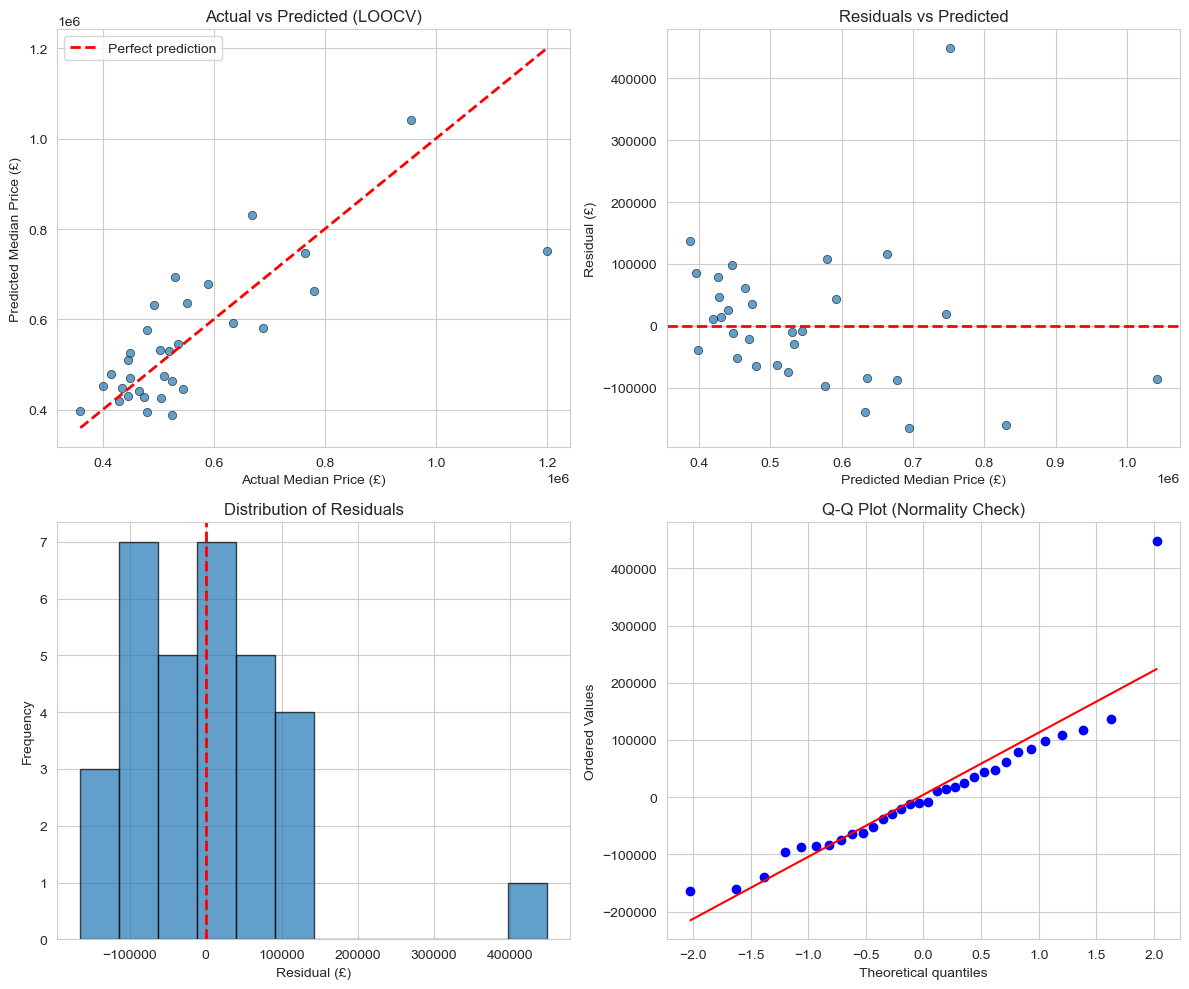

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
residuals = y - y_pred_cv

# Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y, y_pred_cv, alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual Median Price (£)')
ax1.set_ylabel('Predicted Median Price (£)')
ax1.set_title('Actual vs Predicted (LOOCV)')
ax1.legend()

# Residuals vs Predicted
ax2 = axes[0, 1]
ax2.scatter(y_pred_cv, residuals, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Median Price (£)')
ax2.set_ylabel('Residual (£)')
ax2.set_title('Residuals vs Predicted')

# Residual Distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=12, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Residual (£)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Residuals')

# Q-Q Plot
ax4 = axes[1, 1]
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.show()

### vi. Notable Predictions: Outliers and Model Limitations

Examining which boroughs the model struggles to predict can reveal factors not captured by our predictors.

In [55]:
# adding predictions and residuals to dataframe for inspection
results_df = model_df[['borough_name', target_col] + feature_cols].copy()
results_df['predicted_price'] = y_pred_cv
results_df['residual'] = residuals
results_df['residual_pct'] = (residuals / y.values) * 100

print("NOTABLE PREDICTIONS:")

print("\nMost under-predicted:")
under = results_df.nlargest(3, 'residual')[['borough_name', 'median_price', 'predicted_price', 'residual_pct']]
for _, row in under.iterrows():
    print(f"  • {row['borough_name']}: Actual £{row['median_price']:,.0f}, "
          f"Predicted £{row['predicted_price']:,.0f} ({row['residual_pct']:+.1f}%)")

print("\nMost over-predicted:")
over = results_df.nsmallest(3, 'residual')[['borough_name', 'median_price', 'predicted_price', 'residual_pct']]
for _, row in over.iterrows():
    print(f"  • {row['borough_name']}: Actual £{row['median_price']:,.0f}, "
          f"Predicted £{row['predicted_price']:,.0f} ({row['residual_pct']:+.1f}%)")

NOTABLE PREDICTIONS:

Most under-predicted:
  • Kensington and Chelsea: Actual £1,200,000, Predicted £751,942 (+37.3%)
  • Brent: Actual £525,000, Predicted £387,742 (+26.1%)
  • Camden: Actual £780,000, Predicted £663,162 (+15.0%)

Most over-predicted:
  • Lambeth: Actual £530,000, Predicted £694,546 (-31.0%)
  • Islington: Actual £670,000, Predicted £830,301 (-23.9%)
  • Tower Hamlets: Actual £492,500, Predicted £632,257 (-28.4%)


### Summary: Linear Regression Findings

#### Model Performance
Our linear regression model achieves an **R² of 0.56** under cross-validation, indicating that approximately **56% of the variation** in London borough house prices can be explained by earnings, job density, crime rates, and transport connectivity. The average prediction error of **£78,831** (14.2% of mean price) suggests the model captures meaningful signal while leaving some variation unexplained.

#### Key Predictors

| Factor | Effect on Price | Statistical Significance |
|--------|-----------------|-------------------------|
| Crime Rate | +£42,844 per crime/1000 | Highly significant (p<0.001) |
| Median Hourly Earnings | +£35,801 per £1/hour | Highly significant (p<0.001) |
| Transport Score | +£316 per point | Not significant (p=0.778) |
| Jobs Density (log) | -£10,800 per unit | Not significant (p=0.922) |

#### Key Insights

1. **Earnings strongly predict prices**: Each additional £1/hour in median borough wages corresponds to ~£36,000 higher house prices, reflecting the premium residents pay to live near high-paying jobs.

2. **The positive crime coefficient is counterintuitive but interpretable**: Higher crime rates are associated with *higher* prices. This reflects the central London paradox—boroughs like Westminster and Camden have elevated crime (due to visitor footfall, nightlife, and commercial activity) but command premium prices for their location. Crime rate is acting as a proxy for "centrality" rather than a true safety signal.

3. **Transport and job density are not significant**: Once earnings and the centrality effect (captured by crime) are controlled, transport connectivity and job density add little predictive power. This suggests these factors are already priced into wages—workers accept lower earnings in well-connected areas, equilibrating the housing market.

#### Model Limitations
The model systematically under-predicts prices in **prestige boroughs** like Kensington & Chelsea (+37%), Brent (+26%), and Camden (+15%), suggesting that factors beyond our measured variables—such as international investment demand, school quality, and neighbourhood character—drive prices in these areas.

Conversely, the model over-predicts for **inner-city boroughs undergoing change** like Lambeth (-31%), Islington (-24%), and Tower Hamlets (-28%). These areas have high economic indicators but may face headwinds from housing stock composition, ongoing regeneration, or buyer sentiment that our model doesn't capture.

## **Part 6: Conclusion**

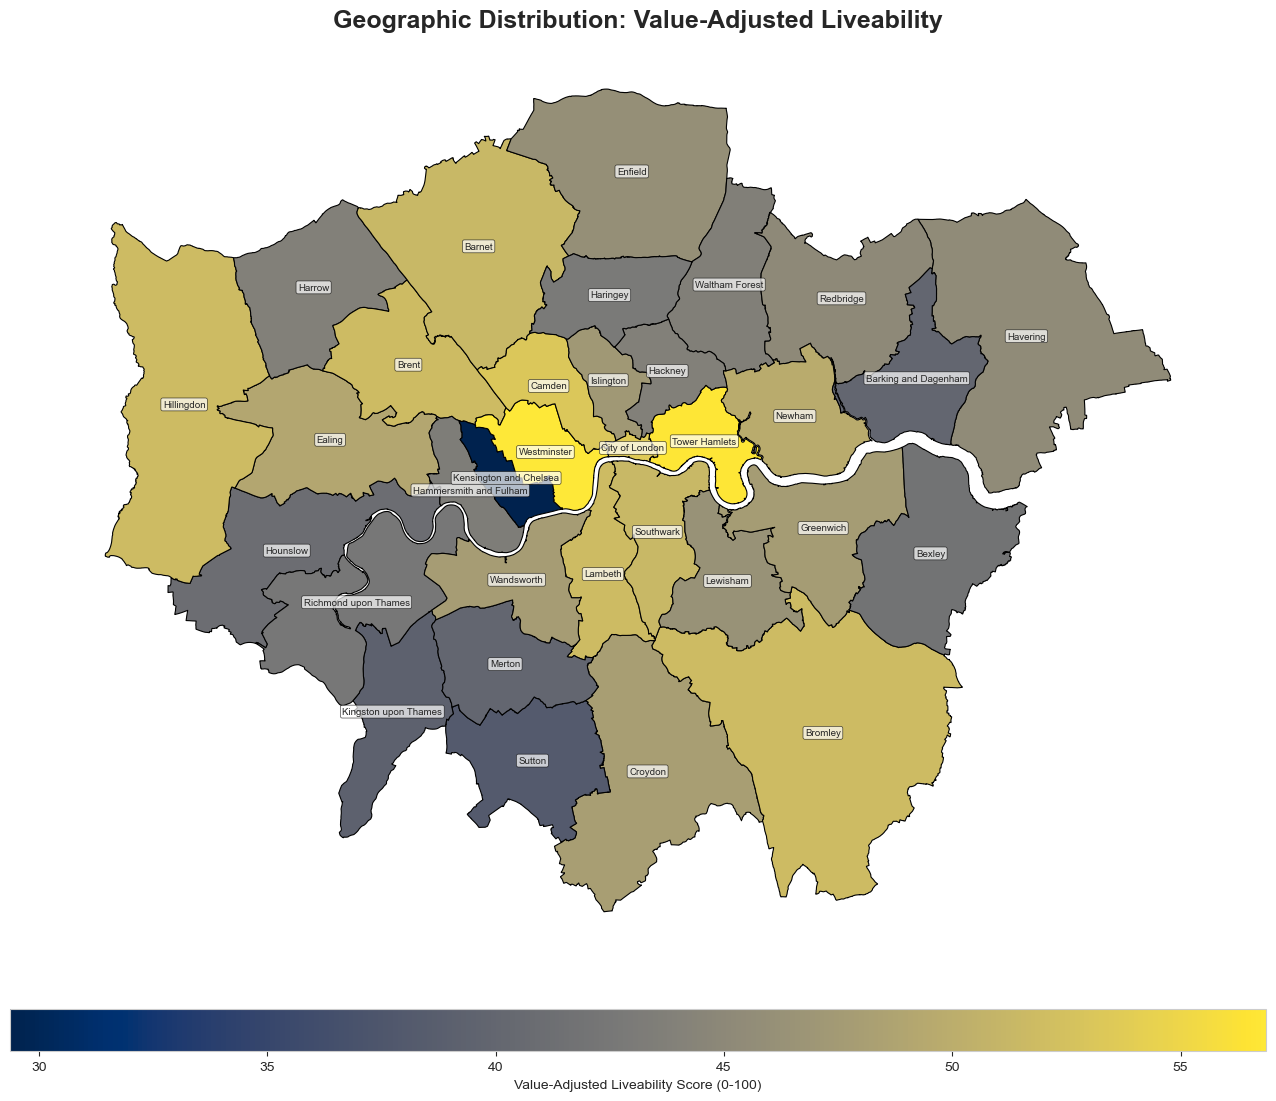

Best value boroughs:   borough_name  value_adjusted_liveability  median_price
   Westminster                       56.87      956000.0
 Tower Hamlets                       56.75      492500.0
City of London                       53.59      901250.0
        Camden                       53.18      780000.0
       Lambeth                       51.82      530000.0

Lowest value adjusted liveability:           borough_name  value_adjusted_liveability  median_price
Kensington and Chelsea                       29.37     1200000.0
                Sutton                       38.09      445750.0
  Kingston upon Thames                       39.25      525000.0
  Barking and Dagenham                       39.93      360000.0
                Merton                       39.96      520000.0


In [24]:
# Choropleth Map: Value-Adjusted Liveability
fig, ax = plt.subplots(figsize=(16, 12))

borough_map.plot(
    column='value_adjusted_liveability',
    ax=ax,
    legend=True,
    cmap='cividis',
    edgecolor='black',
    linewidth=0.8,
    legend_kwds={'label': 'Value-Adjusted Liveability Score (0-100)', 
                 'orientation': 'horizontal',
                 'shrink': 0.8, 
                 'aspect': 30,
                 'pad': 0.05}
)

for idx, row in borough_map.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['borough_name'], 
               xy=(centroid.x, centroid.y),
               ha='center', 
               va='center',
               fontsize=7, 
               fontweight='normal',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                        edgecolor='black', alpha=0.7, linewidth=0.5))

ax.set_title('Geographic Distribution: Value-Adjusted Liveability', 
             fontsize=18, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Best value boroughs: {df.nlargest(5, 'value_adjusted_liveability')[['borough_name', 'value_adjusted_liveability', 'median_price']].to_string(index=False)}")
print(f"\nLowest value adjusted liveability: {df.nsmallest(5, 'value_adjusted_liveability')[['borough_name', 'value_adjusted_liveability', 'median_price']].to_string(index=False)}")


### EDA and Data Visualisation Takeaways

- **Housing prices seem to reflect economic fundamentals and transport connectivity**

London median house prices correlate most strongly with earnings (r = 0.65), while being moderately correlated with job density and transport connectivity (r = 0.38). Buyers seem to pay for job access and income potential. This explains why Westminster and Kensington & Chelsea command premiums despite elevated crime. Additionally, their crime statistics seem to reflect commercial activity and tourism, and not necessarily residential danger.

- **Afforability trade-off**

Affordability correlates negatively with transport and economic opportunity. No borough combines low prices with strong connectivity or employment access.

- **Variation in prices and earnings are very different**

Median hourly earnings of Londoners are in the range of £16-24/hour regardless of location (50% variation), yet house prices vary 3.3x from £360k to £1.2M - a 233% price gap. Areas with similar median hourly incomes exhibit radically different housing markets, showing London's affordability crisis.

- **Job concentration in central London**

Employment opportunities seem to be concentrated in central London -  City of London (66 jobs per resident), Westminster (5.3), and remaining boroughs at 0.4-1.5. This shows why transport connectivity matters, as without tube access workers risk being excluded from London's economic hub.

- **Value-adjusted liveability map**

The value-adjusted map shows the tradeoff between quality and cost. Westminster and Tower Hamlets tie for top spots - Westminster provides great connectivity and economic opportunity while being fairly expensive, and Tower Hamlets is more affordable while still perfmoring reasonably well at transport, safety and economic opportunity. Generally boroughs bordering the central hubs provide good value, as they combine moderate prices, with decent transport and access to economic opportunity. Kensington & Chelsea gives very low value due to low transport connectivity, and unaffordable prices (median house prices equal 24 years of median annual earnings). Isolated outer boroughs (Sutton, Barking & Dagenham) remain poor value despite low prices, due to poor connectivity and access to economic opportunities.

### Regression Model Findings

- **Regression model shows earnings as the primary price driver**

Our linear regression model explains 56% of variation in house prices (CV R² = 0.56), with median hourly earnings as the strongest predictor, with prices increasing by ~£36,000 for every £1/hour rise in earnings. Interestingly, transport connectivity and job density are not statistically significant once earnings are included, suggesting these factors are already captured in local earnings.

- **Crime rate measures centrality, not danger**

The model also reveals a surprising, statistically significant positive relationship between crime rate and house prices, with prices increasing by £43,000 for every crime/1000 residents. This reflects the phenomenon whereby areas like Westminster, with many commercial premises, have higher crime rates but also higher housing prices. Crime rate, it appears, measures centrality.

- **Model limitations highlight unmeasured prestige factors**

The model consistently under-predicts prices in Kensington & Chelsea (+37%) and Camden (+15%), while over-predicting prices in Lambeth (-31%) and Tower Hamlets (-28%). This indicates that other, unmeasured factors such as international investment demand, architectural style, school catchment areas, and neighborhood prestige play a significant role in London's most expensive areas.

#### **AI Acknowledgement:**
##### We acknowledge the use of Claude Opus 4.5 (Anthropic, https://www.anthropic.com/claude/opus) to help debug our code when we ran into errors with the use of API and visualizations.